In [1]:
# GridBoard.py and Gridworld in the main repository have been directly copied from 
# Alexander Zai. “Deep Reinforcement Learning in Action MEAP V06”
# whereas the text in this notebook is my own implementation of the code in the book
# licenses are inherited from the ones used by A.Zai et al in the mentioned book
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from collections import OrderedDict
from torch.autograd import Variable
from Gridworld import *
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

In [2]:
def softmax_fn(av, tau = 1.12):
# This function receives average rewards and outputs the softmax probabilities 
# Arguments:
#   - av: expected averages
#   - tau: temperature. High val exaggerates differences; low value promotes homogenity
# Output:
#   - Softmaxed values

    softm = np.exp(av / tau) / np.sum( np.exp(av[:] / tau) )
    return softm

In [3]:

class QNet():
    def __init__(self, n_in, n_out, n_hidden1, n_hidden2, action_set, gridSize = 4, gamma = 0.9):
        self.n_in = n_in
        self.n_out = n_out
        self.action_set = action_set
        self.gridSize = gridSize
        self.newGridGame()
        self.gamma = gamma
       # self.one_hot_reward = np.ones(arms)

        # Neural network model definition 
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(n_in, n_hidden1)),
            ('ReLu1', nn.ReLU(inplace = True)),
            ('fc2', nn.Linear(n_hidden1, n_hidden2)),
            ('ReLu2', nn.ReLU(inplace = True)),
            ('fc3', nn.Linear(n_hidden2, n_out)),
            #('ReLu3', nn.ReLU(inplace = True))
        ])
        )
                                  
    def newGridGame(self):
        self.env = Gridworld(size=self.gridSize, mode='static') 
        self.refreshState()
                                  
    def refreshState(self):
        # Get state with some random noise
        state_ = self.env.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
        self.state = torch.from_numpy(state_).float()
        
    def forward(self):
        # Get reward prediction from the model
        y_pred = self.model(self.state).squeeze() 
        # Obtain the probability distribution of the reward prediction
        print("ypred: ", y_pred.data.numpy())
        av_softmax = softmax_fn(y_pred.data.numpy(), tau=2.0)  
        print("av_softmax: ", av_softmax)

        av_softmax /= av_softmax.sum() 

        return av_softmax, y_pred
    
    def getQReward(self):
        cur_reward = self.env.reward()
        # The reward of a Q_learning algorithm takes into account propect
        # So ,we need to get new state and the expected reward (maxQval)
        new_state_ = self.env.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
        new_state_ = torch.from_numpy(new_state_).float()
        with torch.no_grad(): # we do not want this pred to be considered in grads
            fut_qval = self.model(new_state_.reshape(1,64))
        
        # Are we in the endgame?
        if cur_reward == -1: 
            QReward = cur_reward + self.gamma*torch.max(fut_qval)
        else:
            QReward = cur_reward
        
        return QReward, cur_reward, new_state_
        
    def actuate(self, av_softmax, y_pred, action_map = None):
        # This function returns the reward to be used for backpropagation and the cur_reward obtained 
        # The backprop reward is such that only modifies the nodes related with obtaining cur_reward
        # To do this, we copy the forward output and modify the value of the array corresponding with the 
        # choice made. The new value of this position is the cur_reward.
        
        # Probabilistically choose an action 
        choice = np.random.choice(self.n_out, p=av_softmax) 
        # convert the choice to the action using the action set of the game
        action = self.action_set[choice]
        # Make the action
        self.env.makeMove(action)
        # Execute action and get the reward for it
        Qreward, status_, new_state = self.getQReward()
        print("Qreward: ",Qreward)
        # Copy qvals
        backprop_reward = y_pred.data.numpy().copy()
        # Update val corresponding to choice so it matches the QReward
        backprop_reward[choice] = Qreward
        self.state = new_state
        # Return reward
        return backprop_reward,status_
        

In [4]:
def train(Qmodel, loss_fn, optimizer, epochs = 5000):
    
    for epoch in range(epochs): # Episodic training, each epoch is a new game
        
        optimizer.zero_grad() # reset grads between epochs
        # Create a new game for each epoch
        Qmodel.newGridGame() # Also refreshes the model state
       
        # Track play status (has game ended?) 
        game_active = True
        while(game_active): # while current play is going on
            actions_prob, y_pred = Qmodel.forward() # get prob distribution and curr_reward
            # actuate based on prob - determines explore-exploit
            act_rewards, status = Qmodel.actuate(actions_prob, y_pred) 
            # Compute loss
            #print('in loss. y_pred {}, rewards: {}'.format(y_pred.data.numpy().size(),act_rewards.size())
            loss = loss_fn(y_pred, torch.Tensor([act_rewards]).detach()) # compute loss
            print('eph: {},  {}'.format(epoch, loss))
            losses.append(loss.item())
            loss.backward() # obtain backward propagation gradients
            optimizer.step() # apply backprop to network model
            
            if status == -1:
                game_active = True
            else:
                game_active = False           


In [6]:
# Set params 
action_map = {
    0:'u',
    1:'d',
    2:'l',
    3:'r'
}
n_out = len(action_map) # 4
gridSize = 4
n_in = 4*gridSize*gridSize
learning_rate = 1e-3
gamma = 0.9 # decay ratio

# Create RL object
Qnet = QNet(n_in, n_out, 150, 100, action_map, gridSize, gamma)
print(Qnet.model)

# Loss metric and optimization criterion for training
loss_fn = nn.MSELoss(size_average=True)
criterion = torch.optim.Adam(Qnet.model.parameters(), lr=learning_rate)


Sequential(
  (fc1): Linear(in_features=64, out_features=150, bias=True)
  (ReLu1): ReLU(inplace)
  (fc2): Linear(in_features=150, out_features=100, bias=True)
  (ReLu2): ReLU(inplace)
  (fc3): Linear(in_features=100, out_features=4, bias=True)
)


/Users/jluissamper/.virtualenvs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [7]:
losses =[]
train(Qnet, loss_fn, criterion, epochs = 1000)

ypred:  [ 0.13651186  0.01069374 -0.06702845 -0.01573973]
av_softmax:  [0.26532477 0.24914761 0.23965117 0.24587636]
Qreward:  tensor(-0.8859)
epoch 0. Loss = 0.2009829431772232
ypred:  [ 0.13002601 -0.00903662 -0.07212421  0.000786  ]
av_softmax:  [0.26496246 0.24716517 0.23949033 0.24838206]
Qreward:  tensor(-0.8673)
epoch 0. Loss = 0.18413801491260529
ypred:  [ 0.15144438 -0.08410516 -0.07145628 -0.01825189]
av_softmax:  [0.27011815 0.240107   0.24163035 0.2481445 ]
Qreward:  tensor(-0.8549)
epoch 0. Loss = 0.17497828602790833
ypred:  [ 0.16622677 -0.12711751 -0.06773788 -0.03617322]
av_softmax:  [0.2734534  0.23614809 0.24326439 0.24713413]
Qreward:  tensor(-0.8810)
epoch 0. Loss = 0.2741849720478058
ypred:  [ 0.12874025 -0.13730265 -0.07144342 -0.0222674 ]
av_softmax:  [0.2697252  0.23612994 0.24403505 0.25010976]
Qreward:  tensor(-0.8674)
epoch 0. Loss = 0.2480829358100891
ypred:  [ 0.1411427  -0.17658094 -0.06693789 -0.04723489]
av_softmax:  [0.27289492 0.23281053 0.24592988 0.2

/Users/jluissamper/.virtualenvs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Qreward:  tensor(-3.1739)
epoch 0. Loss = 0.2924724817276001
ypred:  [-2.6186917 -4.042814  -3.4672382 -3.1081274]
av_softmax:  [0.3415531  0.16757686 0.22345944 0.2674106 ]
Qreward:  tensor(-3.5790)
epoch 0. Loss = 0.2305532842874527
ypred:  [-3.0981653 -4.6175575 -4.025551  -3.5918663]
av_softmax:  [0.34746075 0.16254511 0.21853778 0.2714563 ]
Qreward:  tensor(-3.8098)
epoch 0. Loss = 0.1266142725944519
ypred:  [-3.371942  -4.8531723 -4.32494   -3.8574781]
av_softmax:  [0.34695387 0.16543473 0.21544223 0.27216917]
Qreward:  tensor(-3.9107)
epoch 0. Loss = 0.07255382090806961
ypred:  [-3.488997  -4.840524  -4.425589  -3.9556258]
av_softmax:  [0.341677   0.17383425 0.21391308 0.27057558]
Qreward:  tensor(-4.1530)
epoch 0. Loss = 0.01858011819422245
ypred:  [-3.7761788 -5.07338   -4.79093   -4.3098903]
av_softmax:  [0.34594485 0.18085195 0.20828429 0.26491886]
Qreward:  tensor(-4.4420)
epoch 0. Loss = 0.0043610031716525555
ypred:  [-4.115493  -5.2838883 -5.0874076 -4.5568066]
av_softmax

Qreward:  tensor(-2.2362)
epoch 0. Loss = 0.2996303141117096
ypred:  [-4.0382366 -2.9890895 -1.2238842 -1.5109525]
av_softmax:  [0.09697037 0.16385454 0.3960663  0.34310877]
Qreward:  tensor(-2.0774)
epoch 0. Loss = 0.2077912986278534
ypred:  [-3.662334  -2.766996  -1.0645297 -1.3411913]
av_softmax:  [0.1061381  0.16607013 0.38902485 0.33876696]
Qreward:  tensor(-1.9958)
epoch 0. Loss = 0.21680890023708344
ypred:  [-3.561963  -2.7384956 -0.9821696 -1.2375705]
av_softmax:  [0.10708024 0.1616304  0.38895947 0.34232986]
Qreward:  tensor(-1.8875)
epoch 0. Loss = 0.10559388250112534
ypred:  [-3.2782009 -2.5694244 -0.8729795 -1.1381977]
av_softmax:  [0.11534705 0.16440512 0.38396677 0.33628097]
Qreward:  tensor(-1.7782)
epoch 0. Loss = 0.20483699440956116
ypred:  [-3.019205  -2.408902  -0.7641538 -1.0109922]
av_softmax:  [0.12233457 0.1659873  0.37776995 0.33390823]
Qreward:  tensor(-1.7007)
epoch 0. Loss = 0.21926677227020264
ypred:  [-2.839713   -2.3085825  -0.68655694 -0.92560333]
av_soft

ypred:  [-0.14310646 -0.24515717 -0.06748786 -0.22160009]
av_softmax:  [0.25314525 0.24055246 0.26289976 0.24340256]
Qreward:  tensor(-1.0616)
epoch 0. Loss = 0.16663244366645813
ypred:  [-0.14641409 -0.25368214 -0.06949673 -0.21332678]
av_softmax:  [0.25290307 0.2396962  0.26281884 0.24458183]
Qreward:  tensor(-1.0633)
epoch 0. Loss = 0.18060393631458282
ypred:  [-0.14602809 -0.2561729  -0.07107101 -0.21425952]
av_softmax:  [0.25309625 0.2395345  0.26276192 0.2446073 ]
Qreward:  tensor(-1.0640)
epoch 0. Loss = 0.1631433218717575
ypred:  [-0.14538896 -0.258228   -0.07194124 -0.21632293]
av_softmax:  [0.2533118  0.23941576 0.2627873  0.24448507]
Qreward:  tensor(-1.0647)
epoch 0. Loss = 0.1626109480857849
ypred:  [-0.14527637 -0.2609946  -0.07279795 -0.21791518]
av_softmax:  [0.2534842  0.23923405 0.26283875 0.24444298]
Qreward:  tensor(-1.0657)
epoch 0. Loss = 0.2117820531129837
ypred:  [-0.14447734 -0.26279742 -0.07386912 -0.22074114]
av_softmax:  [0.25373778 0.23916206 0.2628558  0.2

Qreward:  tensor(-1.1858)
epoch 1. Loss = 0.1665954887866974
ypred:  [-0.21496545 -0.51609784 -0.20840889 -0.3715052 ]
av_softmax:  [0.26397625 0.22707787 0.26484308 0.24410276]
Qreward:  tensor(-1.1876)
epoch 1. Loss = 0.1664896011352539
ypred:  [-0.21711308 -0.5208188  -0.21024899 -0.3735604 ]
av_softmax:  [0.26403964 0.22684032 0.26494738 0.24417265]
Qreward:  tensor(-1.1893)
epoch 1. Loss = 0.16637718677520752
ypred:  [-0.21942726 -0.5256815  -0.21210217 -0.37578103]
av_softmax:  [0.26409677 0.22660048 0.26506582 0.24423692]
Qreward:  tensor(-1.1908)
epoch 1. Loss = 0.23944658041000366
ypred:  [-0.22160172 -0.5298435  -0.21363837 -0.3778944 ]
av_softmax:  [0.26413193 0.22640553 0.26518568 0.24427687]
Qreward:  -10
epoch 1. Loss = 23.943218231201172
ypred:  [-0.22395882 -0.5340522  -0.21586066 -0.38035667]
av_softmax:  [0.26418594 0.22624229 0.26525784 0.244314  ]
Qreward:  tensor(-1.1943)
epoch 2. Loss = 0.23537813127040863
ypred:  [-0.2261758  -0.53788716 -0.21788436 -0.38260216]


ypred:  [-0.37834984 -0.7699854  -0.40482557 -0.6172302 ]
av_softmax:  [0.2705314  0.22242065 0.26697373 0.24007419]
Qreward:  tensor(-1.3429)
epoch 3. Loss = 0.23257386684417725
ypred:  [-0.3875903  -0.79063857 -0.4132797  -0.6285958 ]
av_softmax:  [0.2709149  0.22146855 0.26745737 0.2401592 ]
Qreward:  tensor(-1.3480)
epoch 3. Loss = 0.23061704635620117
ypred:  [-0.39391083 -0.8044706  -0.4179554  -0.63521457]
av_softmax:  [0.27109003 0.22078097 0.26785043 0.2402786 ]
Qreward:  tensor(-1.3509)
epoch 3. Loss = 0.2175893634557724
ypred:  [-0.3975889  -0.81122935 -0.42014736 -0.63813925]
av_softmax:  [0.27110362 0.2204522  0.26806295 0.24038118]
Qreward:  tensor(-1.3660)
epoch 3. Loss = 0.1324378401041031
ypred:  [-0.41549993 -0.8493725  -0.43656486 -0.6593927 ]
av_softmax:  [0.27176127 0.21876274 0.26891398 0.24056195]
Qreward:  tensor(-1.3726)
epoch 3. Loss = 0.2290114313364029
ypred:  [-0.4238317  -0.86381567 -0.44272345 -0.66814995]
av_softmax:  [0.2718772  0.21818832 0.26932114 0.2

ypred:  [-1.2815012 -1.883239  -1.259945  -1.6710367]
av_softmax:  [0.27979565 0.2070977  0.28282762 0.23027903]
Qreward:  tensor(-2.0979)
epoch 6. Loss = 0.16662605106830597
ypred:  [-1.2605208 -1.8417672 -1.2409986 -1.642099 ]
av_softmax:  [0.27902463 0.2086539  0.28176156 0.23055996]
Qreward:  tensor(-2.2346)
epoch 6. Loss = 0.0877617597579956
ypred:  [-1.4275032 -2.0617707 -1.397097  -1.8376071]
av_softmax:  [0.28104433 0.20466587 0.28534973 0.22894011]
Qreward:  tensor(-2.1467)
epoch 6. Loss = 0.0018022514414042234
ypred:  [-1.3211725 -1.9006672 -1.2978888 -1.7063451]
av_softmax:  [0.27894115 0.20877422 0.2822075  0.2300771 ]
Qreward:  tensor(-2.1992)
epoch 6. Loss = 0.2030942142009735
ypred:  [-1.3859677 -1.9756745 -1.3584462 -1.778996 ]
av_softmax:  [0.27932286 0.20799519 0.2831931  0.2294888 ]
Qreward:  tensor(-2.2012)
epoch 6. Loss = 0.1661633551120758
ypred:  [-1.3891187 -1.9652864 -1.3612442 -1.7778107]
av_softmax:  [0.27877623 0.20899819 0.28268883 0.2295368 ]
Qreward:  ten

Qreward:  tensor(-3.6955)
epoch 8. Loss = 0.17826640605926514
ypred:  [-3.3773031 -3.6005862 -3.0418317 -3.7135   ]
av_softmax:  [0.25495508 0.22802287 0.30151603 0.21550605]
Qreward:  tensor(-3.6439)
epoch 8. Loss = 0.0906115472316742
ypred:  [-3.3224254 -3.5295665 -2.986031  -3.6376386]
av_softmax:  [0.2538736  0.22889559 0.30037558 0.21685521]
Qreward:  tensor(-3.5856)
epoch 8. Loss = 0.0007837862358428538
ypred:  [-3.2568536 -3.449181  -2.9220307 -3.5509605]
av_softmax:  [0.25292102 0.22973202 0.2990135  0.21833353]
Qreward:  tensor(-3.6762)
epoch 8. Loss = 0.012881329283118248
ypred:  [-3.3875885 -3.564611  -3.0265334 -3.6697547]
av_softmax:  [0.2511579  0.22988304 0.3008493  0.21810983]
Qreward:  tensor(-3.9244)
epoch 8. Loss = 0.07204506546258926
ypred:  [-3.7269528 -3.8871934 -3.3086667 -4.003387 ]
av_softmax:  [0.24835241 0.2292306  0.30612448 0.21629252]
Qreward:  tensor(-3.8580)
epoch 8. Loss = 0.005285588093101978
ypred:  [-3.6481032 -3.796411  -3.2341654 -3.9004197]
av_sof

Qreward:  tensor(-6.7372)
epoch 12. Loss = 0.08715718239545822
ypred:  [-6.395566  -6.8055544 -6.4430833 -6.7327085]
av_softmax:  [0.27502415 0.22404899 0.26856694 0.23235995]
Qreward:  tensor(-6.4207)
epoch 12. Loss = 0.0370311476290226
ypred:  [-6.0419893 -6.4385014 -6.099561  -6.3894987]
av_softmax:  [0.2753086  0.22579707 0.2674966  0.23139775]
Qreward:  tensor(-6.8374)
epoch 12. Loss = 0.15816155076026917
ypred:  [-6.5060077 -6.927683  -6.5849    -6.902676 ]
av_softmax:  [0.2784489  0.22551733 0.267679   0.22835478]
Qreward:  tensor(-6.5340)
epoch 12. Loss = 0.0001957980712177232
ypred:  [-6.168703  -6.5655284 -6.2513804 -6.57291  ]
av_softmax:  [0.27804455 0.22800528 0.2667849  0.22716533]
Qreward:  tensor(-6.5148)
epoch 12. Loss = 0.0008446987485513091
ypred:  [-6.147763  -6.532355  -6.2379694 -6.574938 ]
av_softmax:  [0.27865687 0.22990938 0.26636776 0.22506602]
Qreward:  tensor(-6.5754)
epoch 12. Loss = 0.000463557691546157
ypred:  [-6.218059  -6.591057  -6.3158555 -6.6731577]

Qreward:  tensor(-8.2629)
epoch 12. Loss = 0.01171520259231329
ypred:  [-9.08464  -8.559742 -8.347554 -8.04888 ]
av_softmax:  [0.18435891 0.23968685 0.2665141  0.30944008]
Qreward:  tensor(-8.3207)
epoch 12. Loss = 0.014286442659795284
ypred:  [-9.238607  -8.627656  -8.528765  -8.1092415]
av_softmax:  [0.18043281 0.24489614 0.25730956 0.31736147]
Qreward:  tensor(-8.0187)
epoch 12. Loss = 0.06504208594560623
ypred:  [-8.9163   -8.253932 -8.271019 -7.765354]
av_softmax:  [0.18013617 0.25086048 0.24872638 0.3202769 ]
Qreward:  tensor(-8.2971)
epoch 12. Loss = 0.07069730013608932
ypred:  [-9.364875 -8.57795  -8.728981 -8.078871]
av_softmax:  [0.1736536  0.2573727  0.23865274 0.3303209 ]
Qreward:  tensor(-8.2345)
epoch 12. Loss = 0.0060548861511051655
ypred:  [-9.358375 -8.484292 -8.76596  -8.011659]
av_softmax:  [0.17083272 0.26446956 0.22972715 0.33497062]
Qreward:  tensor(-8.3511)
epoch 12. Loss = 0.004433951806277037
ypred:  [-9.583572 -8.592398 -9.021684 -8.140803]
av_softmax:  [0.166

Qreward:  tensor(-2.9831)
epoch 12. Loss = 0.0543891116976738
ypred:  [-2.175129  -3.4362943 -2.4501226 -2.7292783]
av_softmax:  [0.3162739  0.16834676 0.27564445 0.23973493]
Qreward:  tensor(-2.8599)
epoch 12. Loss = 0.08305210620164871
ypred:  [-2.0389879 -3.2541862 -2.2932546 -2.5941064]
av_softmax:  [0.31417853 0.17111951 0.2766707  0.2380313 ]
Qreward:  tensor(-3.0784)
epoch 12. Loss = 0.058634866029024124
ypred:  [-2.2818322 -3.6801345 -2.5514889 -2.9141004]
av_softmax:  [0.32259786 0.1603334  0.28190726 0.23516147]
Qreward:  tensor(-3.1195)
epoch 12. Loss = 0.17541290819644928
ypred:  [-2.3286138 -3.7932007 -2.5942514 -3.0015488]
av_softmax:  [0.32565677 0.15657741 0.2851528  0.23261306]
Qreward:  tensor(-3.0860)
epoch 12. Loss = 0.0017836960032582283
ypred:  [-2.292546  -3.7702422 -2.546508  -2.9881973]
av_softmax:  [0.32630298 0.15586314 0.28739148 0.23044236]
Qreward:  tensor(-2.8852)
epoch 12. Loss = 0.028672972694039345
ypred:  [-2.0696967 -3.4333675 -2.2966423 -2.7400296]


Qreward:  tensor(-2.5712)
epoch 16. Loss = 0.17085786163806915
ypred:  [-1.7598685 -3.224362  -1.7482444 -2.8767545]
av_softmax:  [0.3269303  0.1571971  0.328836   0.18703656]
Qreward:  tensor(-2.5230)
epoch 16. Loss = 0.14559660851955414
ypred:  [-1.7071841 -3.1121497 -1.695054  -2.786029 ]
av_softmax:  [0.32419932 0.16059339 0.32617158 0.18903573]
Qreward:  tensor(-2.6089)
epoch 16. Loss = 0.20877188444137573
ypred:  [-1.8084317 -3.2905314 -1.7909949 -2.9428184]
av_softmax:  [0.32760197 0.15613945 0.33047062 0.18578795]
Qreward:  tensor(-2.5822)
epoch 16. Loss = 0.14968746900558472
ypred:  [-1.7808369 -3.2240286 -1.7618085 -2.8910537]
av_softmax:  [0.3257811  0.15832183 0.32889542 0.18700163]
Qreward:  -10
epoch 16. Loss = 16.966949462890625
ypred:  [-1.7784634 -3.2040968 -1.7577592 -2.8792932]
av_softmax:  [0.32495198 0.15931138 0.32833338 0.1874032 ]
Qreward:  tensor(-2.5523)
epoch 17. Loss = 0.15780708193778992
ypred:  [-1.7513106 -3.1396198 -1.7300415 -2.828753 ]
av_softmax:  [0.

Qreward:  tensor(-2.8225)
epoch 21. Loss = 0.15362125635147095
ypred:  [-2.107285  -3.273722  -2.0312493 -3.131992 ]
av_softmax:  [0.31289765 0.17462796 0.32502237 0.18745197]
Qreward:  tensor(-2.7670)
epoch 21. Loss = 0.10881169140338898
ypred:  [-2.045324  -3.1649845 -1.9695231 -3.0318475]
av_softmax:  [0.3105045  0.1773931  0.32249862 0.1896038 ]
Qreward:  tensor(-2.7903)
epoch 21. Loss = 0.1387542486190796
ypred:  [-2.0765896 -3.2056396 -1.9957608 -3.069211 ]
av_softmax:  [0.31068975 0.17666757 0.3235033  0.18913937]
Qreward:  tensor(-2.7948)
epoch 21. Loss = 0.018829040229320526
ypred:  [-2.0860121 -3.2106311 -2.0008547 -3.073432 ]
av_softmax:  [0.310198   0.17677917 0.32369104 0.18933177]
Qreward:  tensor(-2.8083)
epoch 21. Loss = 0.16297483444213867
ypred:  [-2.106252  -3.2323363 -2.015855  -3.092826 ]
av_softmax:  [0.30995014 0.17650853 0.3242808  0.1892605 ]
Qreward:  tensor(-2.8325)
epoch 21. Loss = 0.01693730615079403
ypred:  [-2.1402922 -3.2754018 -2.0435338 -3.131558 ]
av_

ypred:  [-2.581398  -3.4418614 -2.3890622 -3.256312 ]
av_softmax:  [0.2886099  0.18769985 0.31774327 0.20594701]
Qreward:  tensor(-3.1024)
epoch 25. Loss = 0.06785345822572708
ypred:  [-2.5292141 -3.3629367 -2.3431513 -3.1848469]
av_softmax:  [0.28759566 0.18955785 0.31563514 0.20721133]
Qreward:  tensor(-3.2452)
epoch 25. Loss = 0.0034625427797436714
ypred:  [-2.7004116 -3.5923958 -2.5018585 -3.395164 ]
av_softmax:  [0.28976268 0.18550283 0.3200057  0.20472875]
Qreward:  tensor(-3.1403)
epoch 25. Loss = 0.10190921276807785
ypred:  [-2.5714176 -3.4085948 -2.3848505 -3.227849 ]
av_softmax:  [0.2876907  0.18929324 0.31581908 0.20719704]
Qreward:  tensor(-3.1881)
epoch 25. Loss = 0.16130372881889343
ypred:  [-2.6277573 -3.4801128 -2.437945  -3.293947 ]
av_softmax:  [0.28824607 0.18822475 0.3169426  0.20658658]
Qreward:  tensor(-3.1565)
epoch 25. Loss = 0.12907269597053528
ypred:  [-2.5880566 -3.4200163 -2.4028425 -3.2397697]
av_softmax:  [0.28746924 0.18964161 0.31536254 0.20752656]
Qrewa

Qreward:  tensor(-3.8379)
epoch 26. Loss = 0.027097050100564957
ypred:  [-3.3230925 -3.8778594 -3.1595361 -3.9475908]
av_softmax:  [0.27973765 0.2119751  0.30357552 0.2047118 ]
Qreward:  tensor(-3.5952)
epoch 26. Loss = 0.04746037349104881
ypred:  [-3.0399783 -3.5297503 -2.8900313 -3.6039996]
av_softmax:  [0.27663168 0.21654554 0.29816896 0.20865376]
Qreward:  tensor(-3.4478)
epoch 26. Loss = 0.0016806097701191902
ypred:  [-2.8681788 -3.3160963 -2.725815  -3.3937726]
av_softmax:  [0.2745727  0.21947917 0.29482973 0.21111841]
Qreward:  tensor(-3.3224)
epoch 26. Loss = 9.946460522769485e-06
ypred:  [-2.7222376 -3.1342595 -2.5860891 -3.214758 ]
av_softmax:  [0.2727778  0.22199315 0.29199356 0.21323553]
Qreward:  tensor(-3.3424)
epoch 26. Loss = 0.14301499724388123
ypred:  [-2.7480469 -3.1570532 -2.608498  -3.2400346]
av_softmax:  [0.2725356  0.22213072 0.29223073 0.21310295]
Qreward:  tensor(-3.2364)
epoch 26. Loss = 3.341420324431965e-06
ypred:  [-2.6250281 -3.0036137 -2.4906485 -3.08872

epoch 26. Loss = 0.1485050916671753
ypred:  [-3.9309382 -4.2528896 -3.846874  -4.277877 ]
av_softmax:  [0.2677388  0.22792944 0.27923226 0.2250995 ]
Qreward:  tensor(-4.5227)
epoch 26. Loss = 0.01819925755262375
ypred:  [-4.0495396 -4.380219  -3.9711742 -4.406125 ]
av_softmax:  [0.26850945 0.22759014 0.2792392  0.22466119]
Qreward:  tensor(-4.5557)
epoch 26. Loss = 0.005594328977167606
ypred:  [-4.078098  -4.4076905 -4.0080953 -4.4360833]
av_softmax:  [0.2688317  0.22798713 0.27840775 0.2247734 ]
Qreward:  tensor(-4.4971)
epoch 26. Loss = 0.0019992755260318518
ypred:  [-4.0018854 -4.3193297 -3.9425497 -4.3515515]
av_softmax:  [0.2686047  0.22918251 0.27669305 0.22551976]
Qreward:  tensor(-4.6357)
epoch 26. Loss = 0.12011474370956421
ypred:  [-4.1532717 -4.4829855 -4.1007032 -4.517106 ]
av_softmax:  [0.26966402 0.22867915 0.2768459  0.22481091]
Qreward:  tensor(-4.6372)
epoch 26. Loss = 0.0036038279067724943
ypred:  [-4.1443996 -4.4694133 -4.1018615 -4.507328 ]
av_softmax:  [0.26986507 

Qreward:  tensor(-5.8260)
epoch 29. Loss = 0.07373224943876266
ypred:  [-5.3677053 -5.697647  -5.4902263 -5.797881 ]
av_softmax:  [0.27816665 0.23586263 0.26163748 0.22433321]
Qreward:  tensor(-5.8308)
epoch 29. Loss = 0.00027064720052294433
ypred:  [-5.372907  -5.700813  -5.4957304 -5.802753 ]
av_softmax:  [0.27810058 0.23604676 0.2615358  0.22431692]
Qreward:  tensor(-5.5400)
epoch 29. Loss = 0.017264045774936676
ypred:  [-5.0492334 -5.3503246 -5.1658053 -5.447725 ]
av_softmax:  [0.27601686 0.23744033 0.26038885 0.22615401]
Qreward:  tensor(-5.9776)
epoch 29. Loss = 0.2154889702796936
ypred:  [-5.536157  -5.872545  -5.6630793 -5.9788294]
av_softmax:  [0.2789285  0.23574758 0.2617774  0.22354648]
Qreward:  tensor(-5.7903)
epoch 29. Loss = 0.004046181216835976
ypred:  [-5.3282533 -5.646855  -5.451063  -5.7495227]
av_softmax:  [0.2775271  0.23665841 0.26099822 0.22481635]
Qreward:  tensor(-5.8446)
epoch 29. Loss = 0.009773257188498974
ypred:  [-5.3891735 -5.71074   -5.513355  -5.8137207

Qreward:  tensor(-6.6699)
epoch 33. Loss = 0.028435153886675835
ypred:  [-6.310435 -6.663701 -6.550953 -6.747998]
av_softmax:  [0.28342465 0.23753458 0.25131    0.22773087]
Qreward:  tensor(-6.6778)
epoch 33. Loss = 4.941769293509424e-05
ypred:  [-6.3195586 -6.6670647 -6.556609  -6.7569113]
av_softmax:  [0.28310043 0.23794717 0.2514581  0.22749434]
Qreward:  tensor(-6.8595)
epoch 33. Loss = 0.009259392507374287
ypred:  [-6.523365  -6.878897  -6.7629375 -6.975964 ]
av_softmax:  [0.28395155 0.23770669 0.25189626 0.22644545]
Qreward:  tensor(-6.6478)
epoch 33. Loss = 0.003873684676364064
ypred:  [-6.288146 -6.619736 -6.514344 -6.721328]
av_softmax:  [0.28204438 0.23895359 0.25188315 0.22711888]
Qreward:  tensor(-6.7599)
epoch 33. Loss = 0.004910143092274666
ypred:  [-6.4143863 -6.7476854 -6.6388474 -6.8567157]
av_softmax:  [0.28233284 0.23899364 0.25235987 0.22631367]
Qreward:  tensor(-6.3082)
epoch 33. Loss = 0.02732972986996174
ypred:  [-5.912201 -6.206095 -6.113674 -6.313285]
av_softma

epoch 34. Loss = 0.004482920281589031
ypred:  [-6.0808916 -6.1853304 -6.0108805 -6.4335012]
av_softmax:  [0.26156726 0.2482589  0.27088574 0.21928817]
Qreward:  tensor(-6.4117)
epoch 34. Loss = 0.00011880524834850803
ypred:  [-6.099348  -6.188464  -6.0246334 -6.44704  ]
av_softmax:  [0.2607623  0.2493983  0.27068794 0.2191515 ]
Qreward:  tensor(-6.3269)
epoch 34. Loss = 0.0036084954626858234
ypred:  [-6.0081544 -6.078799  -5.930514  -6.342674 ]
av_softmax:  [0.2596824  0.25066996 0.26996157 0.21968608]
Qreward:  tensor(-6.4773)
epoch 34. Loss = 0.07475203275680542
ypred:  [-6.183955  -6.242591  -6.0991983 -6.5231724]
av_softmax:  [0.2591753  0.25168714 0.2703948  0.2187427 ]
Qreward:  tensor(-6.7538)
epoch 34. Loss = 0.10711394250392914
ypred:  [-6.5019927 -6.5503097 -6.4078846 -6.8544993]
av_softmax:  [0.25888526 0.25270593 0.27135798 0.21705084]
Qreward:  tensor(-6.8645)
epoch 34. Loss = 0.03285038843750954
ypred:  [-6.6323543 -6.6649384 -6.5322404 -6.9843645]
av_softmax:  [0.2581454

Qreward:  tensor(-7.6364)
epoch 34. Loss = 0.2475721538066864
ypred:  [-8.44543   -7.608504  -8.063677  -7.3475585]
av_softmax:  [0.18310514 0.278251   0.22161399 0.31702992]
Qreward:  tensor(-8.0977)
epoch 34. Loss = 0.1406652331352234
ypred:  [-9.040396  -8.17208   -8.615894  -7.8608294]
av_softmax:  [0.17909215 0.27645785 0.22143988 0.32301012]
Qreward:  tensor(-7.5528)
epoch 34. Loss = 0.09588559716939926
ypred:  [-8.357384  -7.5628633 -7.9525685 -7.2609553]
av_softmax:  [0.18374753 0.2733691  0.22497073 0.31791273]
Qreward:  tensor(-7.8930)
epoch 34. Loss = 0.027248753234744072
ypred:  [-8.790603  -7.980167  -8.347946  -7.6382914]
av_softmax:  [0.1809448  0.27135012 0.22577079 0.32193434]
Qreward:  tensor(-7.7175)
epoch 34. Loss = 0.017244504764676094
ypred:  [-8.566903  -7.7922535 -8.12014   -7.444673 ]
av_softmax:  [0.18261644 0.26900038 0.22832488 0.32005826]
Qreward:  tensor(-7.2761)
epoch 34. Loss = 0.007104647811502218
ypred:  [-8.003429  -7.2885027 -7.5721607 -6.9558873]
av

Qreward:  tensor(-4.6700)
epoch 34. Loss = 0.0475400872528553
ypred:  [-4.498679  -4.198307  -4.0545545 -4.769102 ]
av_softmax:  [0.23341413 0.27123898 0.29145238 0.20389453]
Qreward:  tensor(-4.7773)
epoch 34. Loss = 0.019403722137212753
ypred:  [-4.616208 -4.349219 -4.173016 -4.885658]
av_softmax:  [0.23447546 0.2679621  0.2926411  0.2049213 ]
Qreward:  tensor(-4.8082)
epoch 34. Loss = 0.10085795819759369
ypred:  [-4.6395426 -4.411876  -4.2082467 -4.8994613]
av_softmax:  [0.23588455 0.26432404 0.29265383 0.20713757]
Qreward:  tensor(-4.7332)
epoch 34. Loss = 0.0689060240983963
ypred:  [-4.532312  -4.348007  -4.12672   -4.7721534]
av_softmax:  [0.2376231  0.26056132 0.29104614 0.21076949]
Qreward:  tensor(-4.7318)
epoch 34. Loss = 0.0004075783654116094
ypred:  [-4.5175223 -4.374512  -4.128623  -4.744522 ]
av_softmax:  [0.23915032 0.256877   0.2904821  0.21349053]
Qreward:  tensor(-4.6993)
epoch 34. Loss = 0.08140847831964493
ypred:  [-4.459047  -4.3579044 -4.091475  -4.669926 ]
av_sof

Qreward:  tensor(-5.0905)
epoch 37. Loss = 0.0961950346827507
ypred:  [-4.595829  -5.7446785 -4.8625207 -4.558094 ]
av_softmax:  [0.28924826 0.16285506 0.2531392  0.29475746]
Qreward:  tensor(-5.1940)
epoch 37. Loss = 0.08946546912193298
ypred:  [-4.7074375 -5.8779626 -4.9776177 -4.6721373]
av_softmax:  [0.28998926 0.16151232 0.2533454  0.29515305]
Qreward:  tensor(-5.1047)
epoch 37. Loss = 0.04676774889230728
ypred:  [-4.6069083 -5.73968   -4.86999   -4.5719085]
av_softmax:  [0.28885284 0.1639451  0.25324985 0.29395223]
Qreward:  tensor(-5.0582)
epoch 37. Loss = 0.00885835476219654
ypred:  [-4.553724  -5.6621337 -4.8119626 -4.519302 ]
av_softmax:  [0.2881215  0.16553411 0.25322106 0.29312328]
Qreward:  tensor(-5.2355)
epoch 37. Loss = 0.12822942435741425
ypred:  [-4.7482986 -5.9001703 -5.013425  -4.7174835]
av_softmax:  [0.28955686 0.16278265 0.25360772 0.29405278]
Qreward:  tensor(-5.2445)
epoch 37. Loss = 0.06154889985918999
ypred:  [-4.7567844 -5.900578  -5.019575  -4.727968 ]
av_s

Qreward:  tensor(-5.9710)
epoch 38. Loss = 0.030072495341300964
ypred:  [-7.384934  -5.5336156 -6.8979163 -8.002323 ]
av_softmax:  [0.18071242 0.4560334  0.23053801 0.1327161 ]
Qreward:  tensor(-5.7145)
epoch 38. Loss = 0.008178710006177425
ypred:  [-7.001556  -5.2457895 -6.5394635 -7.5408864]
av_softmax:  [0.18418396 0.4431101  0.2320566  0.14064933]
Qreward:  tensor(-5.4823)
epoch 38. Loss = 0.013984672725200653
ypred:  [-6.653546  -4.986485  -6.2146425 -7.1221128]
av_softmax:  [0.18733747 0.43114397 0.2333089  0.1482097 ]
Qreward:  tensor(-5.4785)
epoch 38. Loss = 0.0605245903134346
ypred:  [-6.637418  -4.9823    -6.1976976 -7.068202 ]
av_softmax:  [0.187271   0.42842504 0.23332138 0.1509826 ]
Qreward:  tensor(-5.6404)
epoch 38. Loss = 0.5096744298934937
ypred:  [-6.8562665 -5.1600566 -6.3986373 -7.2676477]
av_softmax:  [0.1849656  0.43193486 0.2325219  0.1505777 ]
Qreward:  tensor(-5.4851)
epoch 38. Loss = 0.026407303288578987
ypred:  [-6.615038  -4.987405  -6.1742754 -6.9682827]
a

Qreward:  tensor(-4.2911)
epoch 41. Loss = 0.09546495229005814
ypred:  [-4.652489  -5.7824388 -4.598681  -3.6573787]
av_softmax:  [0.23583017 0.13403986 0.24226111 0.38786885]
Qreward:  tensor(-4.4188)
epoch 41. Loss = 0.14494436979293823
ypred:  [-4.821556  -5.9958134 -4.7663856 -3.8005066]
av_softmax:  [0.23529102 0.13080327 0.24187194 0.39203373]
Qreward:  tensor(-4.4204)
epoch 41. Loss = 0.029923589900135994
ypred:  [-4.8162384 -5.9853997 -4.762833  -3.8044713]
av_softmax:  [0.23569052 0.13135964 0.24206886 0.39088097]
Qreward:  tensor(-4.4449)
epoch 41. Loss = 0.034481633454561234
ypred:  [-4.8404865 -6.0134177 -4.7880383 -3.832275 ]
av_softmax:  [0.23594002 0.13125107 0.24220918 0.39059976]
Qreward:  tensor(-4.2982)
epoch 41. Loss = 0.05427257716655731
ypred:  [-4.6272845 -5.7372346 -4.5800467 -3.6692247]
av_softmax:  [0.23738904 0.13628188 0.24306266 0.3832664 ]
Qreward:  tensor(-4.4437)
epoch 41. Loss = 0.4183160662651062
ypred:  [-4.818341  -5.9796395 -4.7685165 -3.8318624]
av

Qreward:  tensor(-5.3822)
epoch 45. Loss = 0.09822241961956024
ypred:  [-5.009654  -5.5351367 -4.9897037 -4.9012055]
av_softmax:  [0.26077747 0.20052244 0.2633918  0.27530834]
Qreward:  tensor(-5.4104)
epoch 45. Loss = 0.044251952320337296
ypred:  [-5.0304365 -5.536462  -5.008176  -4.931989 ]
av_softmax:  [0.2605452  0.20230241 0.26346132 0.27369106]
Qreward:  tensor(-5.3275)
epoch 45. Loss = 0.03909755498170853
ypred:  [-4.9306417 -5.40029   -4.9075336 -4.842655 ]
av_softmax:  [0.25992215 0.20552298 0.26294267 0.2716122 ]
Qreward:  tensor(-5.3716)
epoch 45. Loss = 0.048615723848342896
ypred:  [-4.9714856 -5.4235353 -4.945576  -4.893702 ]
av_softmax:  [0.2597136  0.20717308 0.2631     0.2700133 ]
Qreward:  tensor(-5.4970)
epoch 45. Loss = 0.07601172477006912
ypred:  [-5.1003437 -5.545062  -5.0704026 -5.033241 ]
av_softmax:  [0.25975162 0.20796435 0.26366946 0.2686145 ]
Qreward:  tensor(-5.4973)
epoch 45. Loss = 0.03939426690340042
ypred:  [-5.0916715 -5.5106764 -5.059423  -5.034998 ]
a

ypred:  [-7.921105  -7.5217443 -7.499826  -7.7815037]
av_softmax:  [0.22085908 0.26967168 0.2726433  0.23682594]
Qreward:  tensor(-7.7656)
epoch 49. Loss = 0.017665261402726173
ypred:  [-7.941208  -7.537867  -7.521039  -7.8054366]
av_softmax:  [0.22087392 0.27022702 0.27251032 0.23638874]
Qreward:  tensor(-8.1432)
epoch 49. Loss = 0.010204915888607502
ypred:  [-8.3752775 -7.9415402 -7.9347787 -8.236432 ]
av_softmax:  [0.21927623 0.27238077 0.27330318 0.23503982]
Qreward:  tensor(-7.8854)
epoch 49. Loss = 0.0307993832975626
ypred:  [-8.069706  -7.651942  -7.645525  -7.9376016]
av_softmax:  [0.22041762 0.27162057 0.27249345 0.2354683 ]
Qreward:  tensor(-8.0119)
epoch 49. Loss = 0.0013794247061014175
ypred:  [-8.21244  -7.783715 -7.78134  -8.079855]
av_softmax:  [0.2198694  0.27243397 0.27275762 0.23493904]
Qreward:  tensor(-7.5298)
epoch 49. Loss = 0.01611873134970665
ypred:  [-7.663543  -7.2361465 -7.263357  -7.5264487]
av_softmax:  [0.22071564 0.27330092 0.26960775 0.23637567]
Qreward:

ypred:  [-6.280992  -5.388731  -5.7628984 -6.23212  ]
av_softmax:  [0.20480527 0.31995815 0.26536506 0.20987155]
Qreward:  tensor(-5.4964)
epoch 49. Loss = 0.0028957598842680454
ypred:  [-5.790575  -4.9652324 -5.3161736 -5.7528305]
av_softmax:  [0.20843777 0.31491783 0.26423562 0.21240881]
Qreward:  tensor(-5.3403)
epoch 49. Loss = 0.035167694091796875
ypred:  [-5.588469  -4.796649  -5.1323767 -5.5630884]
av_softmax:  [0.21032041 0.31248054 0.2641926  0.21300647]
Qreward:  tensor(-5.1120)
epoch 49. Loss = 0.05086599662899971
ypred:  [-5.297016  -4.5479383 -4.867418  -5.281546 ]
av_softmax:  [0.2126891  0.30931816 0.26365215 0.21434064]
Qreward:  tensor(-5.2769)
epoch 49. Loss = 0.00010157475480809808
ypred:  [-5.4807167 -4.7233105 -5.0355234 -5.482108 ]
av_softmax:  [0.21235883 0.3101266  0.2653034  0.21221115]
Qreward:  tensor(-5.1047)
epoch 49. Loss = 0.03635723516345024
ypred:  [-5.2543807 -4.533153  -4.830226  -5.265236 ]
av_softmax:  [0.21436045 0.30743775 0.26500168 0.21320012]
Q

ypred:  [-5.8952827 -6.2193074 -5.7229314 -6.1387978]
av_softmax:  [0.26138383 0.22228882 0.2849078  0.23141958]
Qreward:  -10
epoch 52. Loss = 4.573328971862793
ypred:  [-5.9788203 -6.30559   -5.807371  -6.2188487]
av_softmax:  [0.26139155 0.22199048 0.2847877  0.23183021]
Qreward:  tensor(-6.1006)
epoch 53. Loss = 0.010504189878702164
ypred:  [-5.865679  -6.179667  -5.7018905 -6.091781 ]
av_softmax:  [0.26088172 0.22297798 0.28314558 0.23299474]
Qreward:  tensor(-6.2020)
epoch 53. Loss = 0.0030357169453054667
ypred:  [-5.976089  -6.29546   -5.8115716 -6.2016883]
av_softmax:  [0.2609959  0.22247595 0.28337282 0.23315535]
Qreward:  tensor(-5.7831)
epoch 53. Loss = 0.06561917811632156
ypred:  [-5.485725  -5.7629633 -5.3411765 -5.678722 ]
av_softmax:  [0.25950295 0.22591276 0.27895272 0.23563161]
Qreward:  tensor(-6.1846)
epoch 53. Loss = 0.12210188060998917
ypred:  [-5.9442058 -6.2539406 -5.786073  -6.1565437]
av_softmax:  [0.2605471 0.2231661 0.2819839 0.2343029]
Qreward:  tensor(-5.93

Qreward:  tensor(-6.3407)
epoch 53. Loss = 0.04613827168941498
ypred:  [-6.1674914 -5.958344  -6.0093155 -6.3073077]
av_softmax:  [0.2424233  0.2691474  0.26237464 0.22605474]
Qreward:  tensor(-6.6122)
epoch 53. Loss = 0.09085988998413086
ypred:  [-6.49678   -6.262557  -6.3226714 -6.6432467]
av_softmax:  [0.24127872 0.27125633 0.26322442 0.22424056]
Qreward:  tensor(-6.5305)
epoch 53. Loss = 0.003178546903654933
ypred:  [-6.426643  -6.1716733 -6.2498937 -6.563335 ]
av_softmax:  [0.24025169 0.2729181  0.26245028 0.22438   ]
Qreward:  tensor(-6.7399)
epoch 53. Loss = 0.024532146751880646
ypred:  [-6.6886535 -6.406804  -6.497629  -6.8277926]
av_softmax:  [0.23898543 0.27515298 0.26293707 0.22292447]
Qreward:  tensor(-6.7088)
epoch 53. Loss = 0.0035388574469834566
ypred:  [-6.677252  -6.3730373 -6.481344  -6.807893 ]
av_softmax:  [0.23787072 0.27694935 0.26235044 0.2228295 ]
Qreward:  tensor(-6.9605)
epoch 53. Loss = 0.05738688260316849
ypred:  [-6.9884934 -6.6534085 -6.7760434 -7.121613 ]

Qreward:  tensor(-8.1014)
epoch 53. Loss = 0.05621126666665077
ypred:  [-9.1311   -7.928154 -8.638511 -8.420726]
av_softmax:  [0.18081455 0.32995123 0.23131177 0.2579224 ]
Qreward:  tensor(-8.1144)
epoch 53. Loss = 0.023454217240214348
ypred:  [-9.150265  -7.9395576 -8.647813  -8.404087 ]
av_softmax:  [0.17954245 0.32890376 0.23081987 0.26073393]
Qreward:  tensor(-8.0249)
epoch 53. Loss = 0.0018222358776256442
ypred:  [-9.042061  -7.8391204 -8.536917  -8.269017 ]
av_softmax:  [0.1790836  0.3267917  0.23054008 0.2635846 ]
Qreward:  tensor(-8.0980)
epoch 53. Loss = 0.007311106659471989
ypred:  [-9.138332  -7.9199843 -8.617623  -8.322732 ]
av_softmax:  [0.17731097 0.32605928 0.23004147 0.26658824]
Qreward:  tensor(-8.3419)
epoch 53. Loss = 0.04449794813990593
ypred:  [-9.450676 -8.192423 -8.900178 -8.57349 ]
av_softmax:  [0.1741143  0.32663342 0.22928388 0.2699684 ]
Qreward:  tensor(-8.3886)
epoch 53. Loss = 0.008546323515474796
ypred:  [-9.513996 -8.245757 -8.94858  -8.593743]
av_softmax

Qreward:  tensor(-8.1712)
epoch 53. Loss = 0.0005696399020962417
ypred:  [-9.766464  -8.63255   -7.985108  -7.9066496]
av_softmax:  [0.12930003 0.22794229 0.31507593 0.32768175]
Qreward:  tensor(-8.0889)
epoch 53. Loss = 0.002690953202545643
ypred:  [-9.641713 -8.526882 -7.858089 -7.818923]
av_softmax:  [0.13031879 0.22755663 0.3179187  0.32420585]
Qreward:  tensor(-8.3353)
epoch 53. Loss = 0.06666018813848495
ypred:  [-9.946626 -8.808443 -8.078003 -8.085289]
av_softmax:  [0.12741572 0.22510038 0.32433164 0.3231522 ]
Qreward:  tensor(-8.2639)
epoch 53. Loss = 0.008641007356345654
ypred:  [-9.843029  -8.721566  -7.9694667 -8.018536 ]
av_softmax:  [0.1283101  0.22479333 0.32741588 0.31948066]
Qreward:  tensor(-8.1410)
epoch 53. Loss = 0.0073576197028160095
ypred:  [-9.704275  -8.602682  -7.8340936 -7.923973 ]
av_softmax:  [0.12957436 0.2247641  0.33008352 0.31557804]
Qreward:  tensor(-7.8340)
epoch 53. Loss = 2.251056230306858e-09
ypred:  [-9.311726  -8.254117  -7.4978433 -7.620372 ]
av_

Qreward:  tensor(-4.6364)
epoch 53. Loss = 0.1188962459564209
ypred:  [-4.8784513 -4.2030616 -3.988566  -4.9405975]
av_softmax:  [0.2027773  0.28423554 0.31641388 0.19657327]
Qreward:  tensor(-4.8228)
epoch 53. Loss = 0.000774940534029156
ypred:  [-5.1180906 -4.414058  -4.1954937 -5.220275 ]
av_softmax:  [0.20168385 0.28678066 0.31989726 0.1916382 ]
Qreward:  tensor(-4.3832)
epoch 53. Loss = 0.00023737092851661146
ypred:  [-4.5011587 -3.86511   -3.7124703 -4.601958 ]
av_softmax:  [0.20795768 0.28581905 0.30848673 0.19773644]
Qreward:  tensor(-4.3549)
epoch 53. Loss = 0.059963859617710114
ypred:  [-4.446467  -3.8152585 -3.6819458 -4.570902 ]
av_softmax:  [0.20936444 0.28705698 0.30684325 0.19673526]
Qreward:  tensor(-4.4077)
epoch 53. Loss = 0.08773813396692276
ypred:  [-4.499789  -3.8613148 -3.7393844 -4.654111 ]
av_softmax:  [0.20989005 0.28882504 0.30698115 0.19430383]
Qreward:  tensor(-4.3099)
epoch 53. Loss = 0.009014181792736053
ypred:  [-4.3527346 -3.7302394 -3.6337316 -4.5236545

ypred:  [-2.5186486 -2.1857233 -2.5767322 -3.0604725]
av_softmax:  [0.25541615 0.301677   0.24810508 0.19480172]
Qreward:  tensor(-3.2105)
epoch 54. Loss = 0.11965163052082062
ypred:  [-2.8099008 -2.453276  -2.8708203 -3.433294 ]
av_softmax:  [0.25658116 0.30666548 0.2488836  0.18786967]
Qreward:  tensor(-2.9996)
epoch 54. Loss = 0.07460823655128479
ypred:  [-2.5498917 -2.2204087 -2.615069  -3.104549 ]
av_softmax:  [0.25609306 0.30195633 0.24788186 0.19406871]
Qreward:  tensor(-2.9653)
epoch 54. Loss = 0.1387140303850174
ypred:  [-2.5056548 -2.1835668 -2.5738862 -3.0497932]
av_softmax:  [0.25621334 0.3009832  0.24761984 0.19518371]
Qreward:  tensor(-2.9928)
epoch 54. Loss = 0.04386970400810242
ypred:  [-2.5363727 -2.2151108 -2.6072845 -3.0901172]
av_softmax:  [0.25657025 0.301278   0.24763268 0.19451906]
Qreward:  tensor(-3.0058)
epoch 54. Loss = 0.0017780013149604201
ypred:  [-2.5490785 -2.230444  -2.6224322 -3.107188 ]
av_softmax:  [0.2568584  0.3012204  0.2476083  0.19431297]
Qrewar

Qreward:  tensor(-3.5101)
epoch 54. Loss = 0.06416400521993637
ypred:  [-2.8306885 -2.81438   -2.9109817 -3.3359988]
av_softmax:  [0.26698193 0.26916787 0.25647584 0.20737441]
Qreward:  tensor(-3.5623)
epoch 54. Loss = 0.10605823248624802
ypred:  [-2.8798325 -2.8733609 -2.9591594 -3.389851 ]
av_softmax:  [0.26743236 0.26829913 0.2570327  0.20723584]
Qreward:  tensor(-3.7221)
epoch 54. Loss = 0.1455131471157074
ypred:  [-3.0460918 -3.0527754 -3.1250525 -3.5876436]
av_softmax:  [0.26876372 0.2678671  0.25835958 0.2050096 ]
Qreward:  tensor(-3.7341)
epoch 54. Loss = 0.1183282807469368
ypred:  [-3.056841  -3.073021  -3.1347857 -3.5932763]
av_softmax:  [0.26892847 0.2667616  0.2586493  0.2056607 ]
Qreward:  tensor(-3.6115)
epoch 54. Loss = 8.306548988912255e-05
ypred:  [-2.9203465 -2.9412494 -2.996786  -3.4179235]
av_softmax:  [0.26796368 0.26517764 0.25791538 0.2089433 ]
Qreward:  tensor(-3.9761)
epoch 54. Loss = 0.27864328026771545
ypred:  [-3.328857  -3.3725429 -3.4056728 -3.9107394]
av_

Qreward:  -10
epoch 54. Loss = 5.688738822937012
ypred:  [-5.151534  -5.733994  -5.1588798 -5.3211255]
av_softmax:  [0.27304664 0.20405973 0.27204564 0.25084797]
Qreward:  tensor(-5.6823)
epoch 55. Loss = 0.06848298013210297
ypred:  [-5.260347  -5.855909  -5.2646146 -5.4190445]
av_softmax:  [0.27292204 0.20263478 0.2723403  0.2521029 ]
Qreward:  -10
epoch 55. Loss = 5.605968952178955
ypred:  [-5.294696  -5.893672  -5.2981734 -5.4385605]
av_softmax:  [0.27247554 0.20195822 0.2720022  0.2535641 ]
Qreward:  tensor(-5.7829)
epoch 56. Loss = 0.05957438051700592
ypred:  [-5.3633347 -5.9702277 -5.365629  -5.496207 ]
av_softmax:  [0.27226847 0.20100747 0.27195626 0.25476775]
Qreward:  tensor(-5.8104)
epoch 56. Loss = 0.024683844298124313
ypred:  [-5.3890877 -5.9982586 -5.3905845 -5.5094905]
av_softmax:  [0.271868   0.20048335 0.27166462 0.25598407]
Qreward:  tensor(-5.8079)
epoch 56. Loss = 0.022266747429966927
ypred:  [-5.381923  -5.989055  -5.382918  -5.4893007]
av_softmax:  [0.27134016 0.20

ypred:  [-5.8846483 -6.0652986 -5.9413877 -6.038535 ]
av_softmax:  [0.26235664 0.23969798 0.25501826 0.2429271 ]
Qreward:  tensor(-6.3858)
epoch 58. Loss = 0.04936782270669937
ypred:  [-5.996554  -6.176836  -6.0525913 -6.15302  ]
av_softmax:  [0.26240373 0.23978512 0.25515357 0.24265757]
Qreward:  10
epoch 58. Loss = 63.97243118286133
ypred:  [-6.575679  -6.7798853 -6.6351852 -6.7698145]
av_softmax:  [0.2644722  0.23880155 0.2567192  0.24000704]
Qreward:  tensor(-6.7374)
epoch 59. Loss = 0.00045114755630493164
ypred:  [-6.3812456 -6.5748053 -6.4431605 -6.5604925]
av_softmax:  [0.2637445  0.2394156  0.25570473 0.24113509]
Qreward:  tensor(-6.8021)
epoch 59. Loss = 0.014587748795747757
ypred:  [-6.4527116 -6.6476684 -6.5171533 -6.635423 ]
av_softmax:  [0.26398402 0.23946573 0.25561383 0.24093638]
Qreward:  tensor(-6.5931)
epoch 59. Loss = 0.0004482050717342645
ypred:  [-6.2196574 -6.402761  -6.2857122 -6.385535 ]
av_softmax:  [0.26312786 0.24010786 0.25457937 0.24218488]
Qreward:  tensor

Qreward:  tensor(-6.8780)
epoch 59. Loss = 0.0008857641951180995
ypred:  [-6.660002  -6.571023  -6.554747  -6.8004627]
av_softmax:  [0.2480337  0.25931776 0.26143667 0.23121186]
Qreward:  tensor(-6.7742)
epoch 59. Loss = 0.010319543071091175
ypred:  [-6.549173  -6.4469466 -6.4396863 -6.67791  ]
av_softmax:  [0.24713506 0.26009527 0.2610412  0.2317285 ]
Qreward:  tensor(-7.0498)
epoch 59. Loss = 0.09085744619369507
ypred:  [-6.873634  -6.7566266 -6.748682  -7.016232 ]
av_softmax:  [0.24655436 0.26140898 0.2624494  0.22958732]
Qreward:  tensor(-6.9298)
epoch 59. Loss = 0.0018685492686927319
ypred:  [-6.743281  -6.613483  -6.614784  -6.8728204]
av_softmax:  [0.24565849 0.26213017 0.26195976 0.23025158]
Qreward:  tensor(-6.8650)
epoch 59. Loss = 1.5152802916418295e-05
ypred:  [-6.680326  -6.5377994 -6.5466957 -6.8007407]
av_softmax:  [0.24482614 0.26290995 0.26174307 0.23052076]
Qreward:  tensor(-6.8456)
epoch 59. Loss = 0.006826954893767834
ypred:  [-6.6720347 -6.516525  -6.5318055 -6.786

Qreward:  tensor(-7.8494)
epoch 59. Loss = 0.003597103990614414
ypred:  [-8.524394 -7.656549 -8.103134 -8.333363]
av_softmax:  [0.20500284 0.31638074 0.25306687 0.22554949]
Qreward:  tensor(-8.2639)
epoch 59. Loss = 0.001205176580697298
ypred:  [-9.045809 -8.118982 -8.587856 -8.849075]
av_softmax:  [0.20201328 0.3210981  0.25399375 0.22289486]
Qreward:  tensor(-8.2251)
epoch 59. Loss = 0.09733583778142929
ypred:  [-9.0076885 -8.074714  -8.544452  -8.799702 ]
av_softmax:  [0.20142546 0.3211495  0.2539247  0.22350031]
Qreward:  tensor(-8.2601)
epoch 59. Loss = 0.02021026238799095
ypred:  [-9.062111 -8.11461  -8.58764  -8.84282 ]
av_softmax:  [0.20041573 0.32186896 0.25407496 0.22364035]
Qreward:  tensor(-8.5173)
epoch 59. Loss = 0.07420534640550613
ypred:  [-9.386885 -8.398989 -8.884492 -9.156824]
av_softmax:  [0.1981672  0.32475114 0.25475633 0.22232527]
Qreward:  tensor(-8.5592)
epoch 59. Loss = 0.006419610232114792
ypred:  [-9.451389 -8.448763 -8.93614  -9.208698]
av_softmax:  [0.1970

ypred:  [-10.239723  -9.221762  -9.661323  -9.423567]
av_softmax:  [0.18172307 0.30231354 0.24266557 0.27329782]
Qreward:  tensor(-9.4510)
epoch 60. Loss = 0.011062085628509521
ypred:  [-10.353458   -9.334944   -9.7846575  -9.505388 ]
av_softmax:  [0.18112217 0.30139723 0.24070504 0.27677557]
Qreward:  tensor(-9.4916)
epoch 60. Loss = 4.780531526193954e-05
ypred:  [-10.387218  -9.376225  -9.833977  -9.51146 ]
av_softmax:  [0.18096624 0.30000737 0.2386341  0.2803923 ]
Qreward:  tensor(-9.1417)
epoch 60. Loss = 0.119818776845932
ypred:  [-9.9513235 -8.990171  -9.440887  -9.077573 ]
av_softmax:  [0.1832975  0.2963931  0.23658997 0.28371945]
Qreward:  tensor(-9.2122)
epoch 60. Loss = 0.012324401177465916
ypred:  [-10.017691  -9.062113  -9.520977  -9.11489 ]
av_softmax:  [0.1829849  0.2950641  0.23457149 0.28737956]
Qreward:  tensor(-8.9557)
epoch 60. Loss = 0.2819611430168152
ypred:  [-9.697142 -8.781667 -9.235716 -8.791993]
av_softmax:  [0.18476276 0.29201645 0.23270825 0.29051256]
Qrewar

epoch 62. Loss = 0.0018201195634901524
ypred:  [-7.2256923 -6.621442  -7.014676  -6.577878 ]
av_softmax:  [0.20633341 0.27911353 0.22929317 0.28525984]
Qreward:  tensor(-7.5728)
epoch 62. Loss = 0.030121468007564545
ypred:  [-7.985007  -7.3252597 -7.7471256 -7.301052 ]
av_softmax:  [0.20305295 0.28240448 0.22869916 0.28584343]
Qreward:  tensor(-7.4160)
epoch 62. Loss = 0.0033049758058041334
ypred:  [-7.7936625 -7.1475782 -7.5629077 -7.1272006]
av_softmax:  [0.20411955 0.28195512 0.22908272 0.2848426 ]
Qreward:  tensor(-7.6424)
epoch 62. Loss = 0.0015804305439814925
ypred:  [-8.053695  -7.3881946 -7.8137493 -7.3788714]
av_softmax:  [0.20310421 0.28328952 0.22899313 0.28461316]
Qreward:  tensor(-7.4341)
epoch 62. Loss = 0.0007629476604051888
ypred:  [-7.8036566 -7.155873  -7.5726976 -7.1479173]
av_softmax:  [0.20437706 0.28255084 0.22939517 0.28367698]
Qreward:  tensor(-7.6499)
epoch 62. Loss = 0.0014892029576003551
ypred:  [-8.051994  -7.385378  -7.8120885 -7.387718 ]
av_softmax:  [0.20

Qreward:  tensor(-7.3450)
epoch 63. Loss = 0.0071972692385315895
ypred:  [-7.2264905 -7.054128  -7.32881   -7.3317394]
av_softmax:  [0.25069776 0.27326152 0.23819467 0.23784606]
Qreward:  tensor(-7.8284)
epoch 63. Loss = 0.09057380259037018
ypred:  [-7.766506  -7.591937  -7.874204  -7.8994975]
av_softmax:  [0.25160718 0.27455556 0.23841673 0.23542054]
Qreward:  tensor(-7.3690)
epoch 63. Loss = 0.012421305291354656
ypred:  [-7.2476425 -7.081933  -7.350791  -7.354167 ]
av_softmax:  [0.25098836 0.27266976 0.23837197 0.23796993]
Qreward:  tensor(-7.6105)
epoch 63. Loss = 0.032917141914367676
ypred:  [-7.516078  -7.3505735 -7.6213045 -7.635523 ]
av_softmax:  [0.25144294 0.27313557 0.23855571 0.23686577]
Qreward:  tensor(-7.9692)
epoch 63. Loss = 0.051329486072063446
ypred:  [-7.917063 -7.750182 -8.02493  -8.055401]
av_softmax:  [0.25203612 0.27396846 0.23880301 0.23519234]
Qreward:  tensor(-8.0753)
epoch 63. Loss = 9.873070666799322e-05
ypred:  [-8.034574 -7.868696 -8.141963 -8.176806]
av_s

Qreward:  tensor(-8.4125)
epoch 64. Loss = 0.008768242783844471
ypred:  [-8.497347 -8.251188 -8.347489 -8.391153]
av_softmax:  [0.23455934 0.26528054 0.2528098  0.24735028]
Qreward:  tensor(-8.5312)
epoch 64. Loss = 0.004903830122202635
ypred:  [-8.628374 -8.381892 -8.474127 -8.523671]
av_softmax:  [0.23446228 0.2652136  0.25326043 0.24706368]
Qreward:  tensor(-8.1690)
epoch 64. Loss = 0.011330503039062023
ypred:  [-8.2145815 -7.9770255 -8.068723  -8.101805 ]
av_softmax:  [0.23475376 0.26436087 0.25251395 0.24837148]
Qreward:  tensor(-8.4542)
epoch 64. Loss = 0.014354575425386429
ypred:  [-8.534954 -8.293114 -8.380452 -8.426976]
av_softmax:  [0.23450392 0.26464584 0.25333768 0.24751255]
Qreward:  tensor(-8.2806)
epoch 64. Loss = 3.940178794437088e-05
ypred:  [-8.336265 -8.098803 -8.185293 -8.223951]
av_softmax:  [0.2346185  0.26419616 0.25301445 0.24817087]
Qreward:  tensor(-8.1849)
epoch 64. Loss = 0.0003806320019066334
ypred:  [-8.22626   -7.9913187 -8.076805  -8.111115 ]
av_softmax:

Qreward:  tensor(-8.2789)
epoch 64. Loss = 0.013734586536884308
ypred:  [-8.423791  -8.099503  -8.313911  -8.2797365]
av_softmax:  [0.23216985 0.2730387  0.24528208 0.24950936]
Qreward:  tensor(-8.0517)
epoch 64. Loss = 0.0005724430084228516
ypred:  [-8.166413  -7.8463964 -8.062223  -8.020343 ]
av_softmax:  [0.23240869 0.2727364  0.24483691 0.25001794]
Qreward:  tensor(-8.2336)
epoch 64. Loss = 0.0011284054489806294
ypred:  [-8.378207 -8.04936  -8.271258 -8.236718]
av_softmax:  [0.23218285 0.27367702 0.24493667 0.24920349]
Qreward:  tensor(-8.0798)
epoch 64. Loss = 0.00023091374896466732
ypred:  [-8.204915 -7.878032 -8.102136 -8.062769]
av_softmax:  [0.23234475 0.27359903 0.24459697 0.24945919]
Qreward:  tensor(-8.0482)
epoch 64. Loss = 0.007235588971525431
ypred:  [-8.1718855 -7.8430886 -8.070776  -8.031148 ]
av_softmax:  [0.23237212 0.27389327 0.24442166 0.24931292]
Qreward:  tensor(-8.1871)
epoch 64. Loss = 0.0295884869992733
ypred:  [-8.334701 -7.99851  -8.231839 -8.198346]
av_soft

Qreward:  tensor(-8.9107)
epoch 66. Loss = 0.025123218074440956
ypred:  [-9.07172  -8.78103  -9.155106 -8.89301 ]
av_softmax:  [0.23758206 0.27474907 0.22788025 0.25978854]
Qreward:  tensor(-9.0547)
epoch 66. Loss = 0.01872345246374607
ypred:  [-9.234834 -8.94162  -9.320052 -9.055593]
av_softmax:  [0.23753285 0.275039   0.22762437 0.25980374]
Qreward:  tensor(-8.9875)
epoch 66. Loss = 0.015299011953175068
ypred:  [-9.157544 -8.867049 -9.24304  -8.975726]
av_softmax:  [0.23754954 0.27468464 0.22760877 0.260157  ]
Qreward:  tensor(-8.7207)
epoch 66. Loss = 0.005351782776415348
ypred:  [-8.854462 -8.571432 -8.938737 -8.668306]
av_softmax:  [0.23762551 0.27374876 0.22782058 0.26080516]
Qreward:  tensor(-8.7173)
epoch 66. Loss = 0.0005995206884108484
ypred:  [-8.849643 -8.567702 -8.934139 -8.661486]
av_softmax:  [0.23760484 0.27357593 0.22777556 0.26104364]
Qreward:  tensor(-8.8358)
epoch 66. Loss = 0.0024198482278734446
ypred:  [-8.983034 -8.699266 -9.068279 -8.793851]
av_softmax:  [0.2375

ypred:  [-8.5396595 -8.247153  -8.565933  -8.285479 ]
av_softmax:  [0.23364715 0.27044404 0.23059784 0.26531097]
Qreward:  tensor(-8.6528)
epoch 69. Loss = 0.0018885135650634766
ypred:  [-8.803489 -8.508311 -8.833266 -8.547003]
av_softmax:  [0.23358554 0.27073407 0.2301335  0.26554686]
Qreward:  tensor(-8.2118)
epoch 69. Loss = 0.021979648619890213
ypred:  [-8.29693  -8.016455 -8.3305   -8.039373]
av_softmax:  [0.23411852 0.26936445 0.2302217  0.26629534]
Qreward:  tensor(-8.2752)
epoch 69. Loss = 0.0007631715852767229
ypred:  [-8.365718 -8.086238 -8.402468 -8.106659]
av_softmax:  [0.23418874 0.2693111  0.22992481 0.26657534]
Qreward:  tensor(-8.3959)
epoch 69. Loss = 0.020909687504172325
ypred:  [-8.500595 -8.22033  -8.540404 -8.24038 ]
av_softmax:  [0.2342102  0.26944152 0.22959442 0.26675385]
Qreward:  tensor(-8.3372)
epoch 69. Loss = 0.006676034070551395
ypred:  [-8.430951 -8.154221 -8.473642 -8.17041 ]
av_softmax:  [0.23438899 0.26917115 0.22943884 0.26700103]
Qreward:  tensor(-8.

ypred:  [-7.9427166 -7.3612757 -7.8543873 -7.638528 ]
av_softmax:  [0.21993415 0.29413787 0.22986513 0.25606275]
Qreward:  tensor(-7.6945)
epoch 72. Loss = 0.006394572090357542
ypred:  [-8.021481 -7.426469 -7.924608 -7.708752]
av_softmax:  [0.21903999 0.2949365  0.22991058 0.25611293]
Qreward:  tensor(-7.7248)
epoch 72. Loss = 0.022253800183534622
ypred:  [-8.066504  -7.460222  -7.9614024 -7.745252 ]
av_softmax:  [0.21823071 0.29550734 0.23000553 0.2562564 ]
Qreward:  tensor(-7.8760)
epoch 72. Loss = 0.009072542190551758
ypred:  [-8.254841 -7.627895 -8.138635 -7.923381]
av_softmax:  [0.21700226 0.29689565 0.22998424 0.25611785]
Qreward:  tensor(-7.8065)
epoch 72. Loss = 0.050248220562934875
ypred:  [-8.180484  -7.5507483 -8.058169  -7.841603 ]
av_softmax:  [0.216554   0.2966959  0.2302112  0.25653893]
Qreward:  tensor(-7.6607)
epoch 72. Loss = 0.0030231981072574854
ypred:  [-8.014561  -7.3889246 -7.8882904 -7.6696796]
av_softmax:  [0.21642002 0.2959052  0.23052429 0.25715053]
Qreward: 

ypred:  [-7.270402  -7.0155096 -7.1397038 -7.036053 ]
av_softmax:  [0.23106584 0.26247317 0.2466701  0.2597909 ]
Qreward:  tensor(-7.8230)
epoch 76. Loss = 0.16300246119499207
ypred:  [-7.854111  -7.5949326 -7.7135677 -7.6249824]
av_softmax:  [0.2308112  0.26274642 0.24761419 0.2588282 ]
Qreward:  tensor(-7.5687)
epoch 76. Loss = 0.00017244566697627306
ypred:  [-7.5553856 -7.3124056 -7.426024  -7.3304067]
av_softmax:  [0.23174664 0.26168323 0.2472316  0.2593385 ]
Qreward:  tensor(-7.5156)
epoch 76. Loss = 0.0020048441365361214
ypred:  [-7.4856906 -7.2541103 -7.3623257 -7.2653723]
av_softmax:  [0.23240462 0.26093465 0.24719125 0.25946948]
Qreward:  tensor(-7.4281)
epoch 76. Loss = 0.0010812085820361972
ypred:  [-7.376755  -7.157511  -7.2604113 -7.1610494]
av_softmax:  [0.23311995 0.26012835 0.2470832  0.25966856]
Qreward:  tensor(-7.5176)
epoch 76. Loss = 0.03241899609565735
ypred:  [-7.468258  -7.258276  -7.354831  -7.2580676]
av_softmax:  [0.233652   0.25951743 0.24728616 0.25954446]


Qreward:  tensor(-10.4798)
epoch 77. Loss = 6.224059325177222e-05
ypred:  [-10.518277  -10.66053   -10.860507  -10.6318865]
av_softmax:  [0.2689005  0.2504389  0.22660913 0.25405145]
Qreward:  tensor(-10.2827)
epoch 77. Loss = 0.08347196877002716
ypred:  [-10.299686  -10.424448  -10.633921  -10.3800335]
av_softmax:  [0.26693374 0.25079092 0.22585274 0.25642258]
Qreward:  -10
epoch 77. Loss = 0.1004638522863388
ypred:  [-10.3612995 -10.474482  -10.694379  -10.417041 ]
av_softmax:  [0.2656689  0.25105193 0.22491243 0.2583668 ]
Qreward:  tensor(-10.7426)
epoch 78. Loss = 0.0005804109969176352
ypred:  [-10.809452 -10.919914 -11.152885 -10.853784]
av_softmax:  [0.26549408 0.25122815 0.22360383 0.25967392]
Qreward:  tensor(-10.5484)
epoch 78. Loss = 0.017041411250829697
ypred:  [-10.595216  -10.6908245 -10.930254  -10.611613 ]
av_softmax:  [0.26378852 0.25147492 0.2231019  0.26163462]
Qreward:  tensor(-10.7184)
epoch 78. Loss = 0.003791237948462367
ypred:  [-10.785011 -10.874609 -11.123648 -

ypred:  [-8.4881525 -7.747831  -8.071442  -8.389616 ]
av_softmax:  [0.21141112 0.30611643 0.26038468 0.22208783]
Qreward:  tensor(-7.9193)
epoch 79. Loss = 0.055290523916482925
ypred:  [-8.378941  -7.6401906 -7.950199  -8.27277  ]
av_softmax:  [0.21095124 0.3052106  0.26138586 0.22245222]
Qreward:  tensor(-7.8122)
epoch 79. Loss = 0.00740050571039319
ypred:  [-8.25586   -7.5205193 -7.8165374 -8.140984 ]
av_softmax:  [0.21056439 0.30413207 0.2622906  0.22301295]
Qreward:  tensor(-7.8584)
epoch 79. Loss = 0.028544532135128975
ypred:  [-8.316929 -7.570588 -7.856219 -8.19547 ]
av_softmax:  [0.2094684  0.30421758 0.26373053 0.2225835 ]
Qreward:  tensor(-7.6705)
epoch 79. Loss = 0.0024971349630504847
ypred:  [-8.096916 -7.363616 -7.632774 -7.963966]
av_softmax:  [0.209519   0.30231348 0.26424733 0.22392014]
Qreward:  tensor(-7.8111)
epoch 79. Loss = 0.020426880568265915
ypred:  [-8.270615  -7.5181684 -7.777973  -8.13116  ]
av_softmax:  [0.20797381 0.30297044 0.26606292 0.22299281]
Qreward:  

Qreward:  tensor(-6.5925)
epoch 80. Loss = 0.018946673721075058
ypred:  [-6.4713554 -6.2720222 -6.353797  -6.2457623]
av_softmax:  [0.23338595 0.2578454  0.24751541 0.2612532 ]
Qreward:  tensor(-6.5935)
epoch 80. Loss = 0.014365489594638348
ypred:  [-6.4595766 -6.265477  -6.363833  -6.2474713]
av_softmax:  [0.23458584 0.2584937  0.24608904 0.2608314 ]
Qreward:  tensor(-6.5884)
epoch 80. Loss = 0.012602758593857288
ypred:  [-6.441008  -6.2525883 -6.3674603 -6.2425294]
av_softmax:  [0.23581682 0.25911325 0.24465014 0.26041973]
Qreward:  tensor(-6.8444)
epoch 80. Loss = 0.05686263367533684
ypred:  [-6.7131634 -6.5249944 -6.657395  -6.5300856]
av_softmax:  [0.23681034 0.26017228 0.24350654 0.25951084]
Qreward:  tensor(-6.9418)
epoch 80. Loss = 0.020221244543790817
ypred:  [-6.8147316 -6.6307726 -6.781385  -6.6470914]
av_softmax:  [0.23806188 0.26099733 0.24206443 0.2588764 ]
Qreward:  tensor(-6.8800)
epoch 80. Loss = 0.002430603140965104
ypred:  [-6.7388062 -6.5626345 -6.730756  -6.5854044

Qreward:  tensor(-9.3346)
epoch 84. Loss = 0.00929834321141243
ypred:  [ -9.247358  -9.347418 -10.236244  -9.574187]
av_softmax:  [0.29322496 0.2789159  0.178841   0.24901807]
Qreward:  tensor(-9.1063)
epoch 84. Loss = 0.31921860575675964
ypred:  [-8.993394 -9.072879 -9.934097 -9.280466]
av_softmax:  [0.28967798 0.27839124 0.18098573 0.250945  ]
Qreward:  tensor(-9.0488)
epoch 84. Loss = 0.00014541308337356895
ypred:  [-8.927189 -8.989172 -9.83759  -9.185423]
av_softmax:  [0.28713557 0.27837327 0.18213603 0.25235516]
Qreward:  tensor(-9.2852)
epoch 84. Loss = 0.032049499452114105
ypred:  [ -9.189626  -9.23783  -10.099055  -9.435456]
av_softmax:  [0.28611046 0.279297   0.18157399 0.25301853]
Qreward:  tensor(-9.1264)
epoch 84. Loss = 0.23649510741233826
ypred:  [-9.012608 -9.040436 -9.878336 -9.222373]
av_softmax:  [0.28286457 0.278956   0.1834797  0.25469977]
Qreward:  tensor(-9.3111)
epoch 84. Loss = 0.018311165273189545
ypred:  [ -9.215262   -9.226344  -10.069403   -9.4065275]
av_sof

Qreward:  tensor(-7.0053)
epoch 86. Loss = 0.09612539410591125
ypred:  [-7.6937423 -6.9545465 -6.6827726 -6.856397 ]
av_softmax:  [0.17778143 0.25727686 0.2947241  0.27021757]
Qreward:  tensor(-7.0380)
epoch 86. Loss = 0.10749991983175278
ypred:  [-7.720375  -6.9793663 -6.718767  -6.8926415]
av_softmax:  [0.17821603 0.25813967 0.29406485 0.26957947]
Qreward:  tensor(-6.9525)
epoch 86. Loss = 0.0008969253394752741
ypred:  [-7.592862 -6.86483  -6.62333  -6.788747]
av_softmax:  [0.17992765 0.2589334  0.2921656  0.26897338]
Qreward:  tensor(-6.8429)
epoch 86. Loss = 0.14062893390655518
ypred:  [-7.4333677 -6.7219534 -6.5007977 -6.6562176]
av_softmax:  [0.18194625 0.25967178 0.29003343 0.26834846]
Qreward:  tensor(-6.8107)
epoch 86. Loss = 0.00196811999194324
ypred:  [-7.3741293 -6.6707773 -6.4648557 -6.6164303]
av_softmax:  [0.18322898 0.26045045 0.28869575 0.26762483]
Qreward:  tensor(-6.8684)
epoch 86. Loss = 0.00976204127073288
ypred:  [-7.4296665 -6.7246118 -6.5285783 -6.6832623]
av_so

Qreward:  -10
epoch 88. Loss = 1.2021421194076538
ypred:  [-7.4034853 -7.5098763 -7.6535945 -7.6998754]
av_softmax:  [0.27078944 0.2567611  0.23895779 0.2334917 ]
Qreward:  tensor(-7.7176)
epoch 89. Loss = 0.024662047624588013
ypred:  [-7.4765077 -7.5779066 -7.722763  -7.7659593]
av_softmax:  [0.2702721  0.256911   0.23896131 0.23385553]
Qreward:  tensor(-7.5929)
epoch 89. Loss = 0.0033850620966404676
ypred:  [-7.336747  -7.429536  -7.5752964 -7.6067443]
av_softmax:  [0.2691104  0.2569104  0.23885272 0.2351264 ]
Qreward:  tensor(-7.4665)
epoch 89. Loss = 0.0003416977997403592
ypred:  [-7.1949615 -7.2797685 -7.4262753 -7.446657 ]
av_softmax:  [0.26802373 0.2568962  0.23875038 0.23632966]
Qreward:  tensor(-7.6144)
epoch 89. Loss = 0.008847272954881191
ypred:  [-7.358941 -7.441638 -7.58908  -7.611809]
av_softmax:  [0.26795056 0.25709715 0.23882551 0.23612675]
Qreward:  tensor(-7.5971)
epoch 89. Loss = 0.006040535401552916
ypred:  [-7.339229  -7.4169984 -7.5651045 -7.582795 ]
av_softmax:  

Qreward:  tensor(-8.0422)
epoch 93. Loss = 0.004982647951692343
ypred:  [-7.8327656 -7.852624  -7.973432  -7.9229746]
av_softmax:  [0.2578582  0.25531054 0.24034525 0.24648601]
Qreward:  tensor(-8.2098)
epoch 93. Loss = 0.013965281657874584
ypred:  [-8.019144 -8.045203 -8.160695 -8.115579]
av_softmax:  [0.25828764 0.2549441  0.2406391  0.24612918]
Qreward:  tensor(-8.0149)
epoch 93. Loss = 4.4823536882176995e-06
ypred:  [-7.8027916 -7.8317566 -7.9433503 -7.891152 ]
av_softmax:  [0.25809538 0.25438446 0.24057932 0.2469409 ]
Qreward:  tensor(-8.1118)
epoch 93. Loss = 0.007092635612934828
ypred:  [-7.9111695 -7.946517  -8.05241   -8.002917 ]
av_softmax:  [0.25843403 0.25390667 0.24081287 0.24684647]
Qreward:  tensor(-8.2192)
epoch 93. Loss = 0.018586942926049232
ypred:  [-8.031147 -8.073678 -8.173233 -8.126652]
av_softmax:  [0.25881588 0.25337014 0.24106675 0.24674723]
Qreward:  tensor(-8.1657)
epoch 93. Loss = 1.4298370842880104e-05
ypred:  [-7.9720325 -8.020241  -8.114196  -8.064948 ]
a

ypred:  [-9.196719 -9.807656 -9.504137 -9.312089]
av_softmax:  [0.28262585 0.20823254 0.24235778 0.26678392]
Qreward:  tensor(-9.0765)
epoch 94. Loss = 0.013874087482690811
ypred:  [-8.972965 -9.561251 -9.272814 -9.06723 ]
av_softmax:  [0.2809064  0.20932306 0.2417967  0.26797375]
Qreward:  tensor(-9.1225)
epoch 94. Loss = 0.005647595971822739
ypred:  [-9.022539 -9.607802 -9.32027  -9.10378 ]
av_softmax:  [0.28025523 0.20915362 0.2414918  0.2690993 ]
Qreward:  tensor(-8.9173)
epoch 94. Loss = 0.008689923211932182
ypred:  [-8.796115 -9.358023 -9.085533 -8.85536 ]
av_softmax:  [0.2784624  0.2102567  0.24094628 0.2703346 ]
Qreward:  tensor(-8.9287)
epoch 94. Loss = 0.04607366397976875
ypred:  [-8.8086195 -9.363716  -9.094396  -8.852157 ]
av_softmax:  [0.2775498  0.21028255 0.24059437 0.27157325]
Qreward:  tensor(-9.1296)
epoch 94. Loss = 0.000309795665089041
ypred:  [-9.030289 -9.592467 -9.31624  -9.062419]
av_softmax:  [0.27733102 0.20937409 0.24038361 0.27291128]
Qreward:  tensor(-8.930

Qreward:  tensor(-6.7232)
epoch 95. Loss = 0.008843371644616127
ypred:  [-7.207891  -6.3646    -7.0458255 -6.6723223]
av_softmax:  [0.20341991 0.3101071  0.22058986 0.2658831 ]
Qreward:  tensor(-6.7920)
epoch 95. Loss = 0.04566170275211334
ypred:  [-7.279079  -6.4418955 -7.109073  -6.740511 ]
av_softmax:  [0.2033526  0.3090593  0.22139408 0.26619402]
Qreward:  tensor(-6.8387)
epoch 95. Loss = 0.002408461645245552
ypred:  [-7.321396  -6.4947495 -7.144413  -6.781486 ]
av_softmax:  [0.20348927 0.3076419  0.22231708 0.26655167]
Qreward:  tensor(-6.8510)
epoch 95. Loss = 0.05531160533428192
ypred:  [-7.319193  -6.509117  -7.1370316 -6.78056  ]
av_softmax:  [0.20392406 0.30575544 0.22336972 0.26695073]
Qreward:  tensor(-6.8412)
epoch 95. Loss = 0.021882833912968636
ypred:  [-7.287529  -6.498051  -7.1013703 -6.751958 ]
av_softmax:  [0.20455702 0.30356193 0.22451133 0.26736972]
Qreward:  tensor(-6.9061)
epoch 95. Loss = 0.00594044616445899
ypred:  [-7.348924  -6.5709705 -7.1551366 -6.811894 ]


Qreward:  tensor(-7.2649)
epoch 99. Loss = 0.01985795423388481
ypred:  [-7.2309127 -7.7726955 -6.9598327 -7.3646064]
av_softmax:  [0.26020032 0.1984546  0.2979697  0.24337536]
Qreward:  tensor(-6.8164)
epoch 99. Loss = 0.07513947039842606
ypred:  [-6.7023444 -7.190398  -6.462464  -6.8062143]
av_softmax:  [0.2590481  0.20295553 0.2920585  0.24593784]
Qreward:  tensor(-6.8910)
epoch 99. Loss = 0.0017955470830202103
ypred:  [-6.784838  -7.2671394 -6.545071  -6.8833704]
av_softmax:  [0.2587311  0.20329104 0.29168454 0.24629334]
Qreward:  tensor(-6.8586)
epoch 99. Loss = 0.0013605753192678094
ypred:  [-6.7424974 -7.2090755 -6.5092535 -6.830367 ]
av_softmax:  [0.2582221  0.20449245 0.29016274 0.24712278]
Qreward:  tensor(-6.9293)
epoch 99. Loss = 0.0024465681053698063
ypred:  [-6.8203273 -7.279664  -6.5878234 -6.901619 ]
av_softmax:  [0.25784856 0.20493731 0.28963587 0.24757823]
Qreward:  tensor(-6.9166)
epoch 99. Loss = 0.032956428825855255
ypred:  [-6.800662  -7.2451186 -6.5737944 -6.87149

epoch 101. Loss = 0.02156824618577957
ypred:  [-7.788068 -7.861142 -7.868996 -8.140225]
av_softmax:  [0.26574418 0.25620985 0.2552057  0.22284028]
Qreward:  tensor(-8.0174)
epoch 101. Loss = 0.005502443294972181
ypred:  [-7.8433814 -7.9193316 -7.9230394 -8.213899 ]
av_softmax:  [0.2663414  0.2564167  0.25594175 0.22130023]
Qreward:  tensor(-8.2616)
epoch 101. Loss = 0.043736375868320465
ypred:  [-8.117037 -8.198447 -8.194334 -8.52108 ]
av_softmax:  [0.26743132 0.25676405 0.25729266 0.21851204]
Qreward:  -10
epoch 101. Loss = 0.8151074051856995
ypred:  [-8.175782 -8.259314 -8.252041 -8.598132]
av_softmax:  [0.268002   0.25703925 0.25797564 0.21698311]
Qreward:  tensor(-8.2840)
epoch 102. Loss = 0.024676278233528137
ypred:  [-8.138074 -8.222241 -8.213747 -8.57002 ]
av_softmax:  [0.26828232 0.25722626 0.25832108 0.2161704 ]
Qreward:  tensor(-8.1768)
epoch 102. Loss = 0.0005154989194124937
ypred:  [-8.0138445 -8.097244  -8.089373  -8.447172 ]
av_softmax:  [0.26829082 0.2573332  0.258348   

Qreward:  tensor(-8.6051)
epoch 103. Loss = 0.022418277338147163
ypred:  [-8.714896 -8.473531 -8.654232 -8.445942]
av_softmax:  [0.23239587 0.26220456 0.23955293 0.26584658]
Qreward:  tensor(-8.3596)
epoch 103. Loss = 0.0018624941585585475
ypred:  [-8.4567375 -8.204355  -8.394431  -8.174448 ]
av_softmax:  [0.23160295 0.2627533  0.2389317  0.26671198]
Qreward:  tensor(-8.5942)
epoch 103. Loss = 0.009981678798794746
ypred:  [-8.738527 -8.460705 -8.663735 -8.435041]
av_softmax:  [0.2298329  0.2640831  0.23859045 0.26749355]
Qreward:  tensor(-8.5598)
epoch 103. Loss = 0.0024572876282036304
ypred:  [-8.717292 -8.422494 -8.636405 -8.397359]
av_softmax:  [0.22864668 0.26495945 0.23808347 0.26831037]
Qreward:  tensor(-8.5189)
epoch 103. Loss = 0.0034497317392379045
ypred:  [-8.688989 -8.377735 -8.602295 -8.352999]
av_softmax:  [0.22749916 0.26580775 0.23757738 0.26911572]
Qreward:  tensor(-8.4322)
epoch 103. Loss = 0.0015673587331548333
ypred:  [-8.6070385 -8.281514  -8.515923  -8.256538 ]
av_

ypred:  [-8.553566 -8.710761 -8.810948 -8.848867]
av_softmax:  [0.27274787 0.25213137 0.23981233 0.23530842]
Qreward:  tensor(-8.7395)
epoch 103. Loss = 0.00020615341782104224
ypred:  [-8.574685 -8.764632 -8.843737 -8.895797]
av_softmax:  [0.2750882  0.2501644  0.24046294 0.23428445]
Qreward:  tensor(-8.6848)
epoch 103. Loss = 0.0063142175786197186
ypred:  [-8.514757  -8.735415  -8.793717  -8.8568535]
av_softmax:  [0.27715185 0.24820037 0.24106953 0.23357831]
Qreward:  tensor(-8.6852)
epoch 103. Loss = 0.002945313695818186
ypred:  [-8.514047 -8.767201 -8.803844 -8.880479]
av_softmax:  [0.27942297 0.24620125 0.24173154 0.23264426]
Qreward:  tensor(-8.7204)
epoch 103. Loss = 0.0017401931108906865
ypred:  [-8.554784 -8.842227 -8.856143 -8.94826 ]
av_softmax:  [0.28187612 0.24414104 0.24244821 0.23153463]
Qreward:  tensor(-8.7955)
epoch 103. Loss = 0.0005447883740998805
ypred:  [-8.637866 -8.961875 -8.951713 -9.06153 ]
av_softmax:  [0.28455108 0.24199288 0.24322562 0.23023044]
Qreward:  te

ypred:  [-6.6465206 -7.4606986 -6.9900727 -6.959657 ]
av_softmax:  [0.29736894 0.19792429 0.25043455 0.2542722 ]
Qreward:  tensor(-7.0811)
epoch 107. Loss = 0.03603038564324379
ypred:  [-6.7372985 -7.5295997 -7.076144  -7.0442038]
av_softmax:  [0.29631397 0.19939126 0.250134   0.25416076]
Qreward:  tensor(-6.9163)
epoch 107. Loss = 0.008009686134755611
ypred:  [-6.5552063 -7.2911263 -6.8787107 -6.836895 ]
av_softmax:  [0.29313293 0.20289047 0.24935412 0.25462246]
Qreward:  tensor(-6.7395)
epoch 107. Loss = 0.008490607142448425
ypred:  [-6.3595614 -7.0385084 -6.6673217 -6.615496 ]
av_softmax:  [0.28990528 0.20645466 0.2485575  0.25508246]
Qreward:  10
epoch 107. Loss = 66.9088134765625
ypred:  [-6.5526814 -7.2246385 -6.8646317 -6.814086 ]
av_softmax:  [0.2900486  0.2072799  0.24815993 0.2545116 ]
Qreward:  tensor(-6.9392)
epoch 108. Loss = 0.020373214036226273
ypred:  [-6.571916  -7.2197323 -6.882125  -6.8281803]
av_softmax:  [0.28906915 0.20908856 0.24753737 0.2543049 ]
Qreward:  tenso

Qreward:  tensor(-7.5823)
epoch 110. Loss = 0.0013856302248314023
ypred:  [-7.349841 -7.41374  -7.392623 -7.44371 ]
av_softmax:  [0.25630894 0.24824944 0.2508845  0.24455717]
Qreward:  tensor(-7.5837)
epoch 110. Loss = 0.007218198850750923
ypred:  [-7.3529134 -7.417669  -7.3932176 -7.440832 ]
av_softmax:  [0.25606993 0.24791177 0.2509612  0.24505708]
Qreward:  tensor(-7.7568)
epoch 110. Loss = 0.03304461017251015
ypred:  [-7.5473995 -7.6157436 -7.5840244 -7.6354914]
av_softmax:  [0.25607085 0.24746819 0.25142422 0.24503674]
Qreward:  tensor(-7.6976)
epoch 110. Loss = 0.0016756383702158928
ypred:  [-7.4817886 -7.5500236 -7.516661  -7.5612288]
av_softmax:  [0.25573936 0.24716134 0.25131887 0.24578047]
Qreward:  tensor(-7.8008)
epoch 110. Loss = 0.015726372599601746
ypred:  [-7.5984707 -7.6693997 -7.6303477 -7.6749253]
av_softmax:  [0.25563422 0.24672714 0.2515921  0.24604645]
Qreward:  tensor(-7.7961)
epoch 110. Loss = 0.004013610538095236
ypred:  [-7.5937967 -7.6658545 -7.623695  -7.663

ypred:  [-10.12145  -10.224479 -10.203743 -10.065971]
av_softmax:  [0.25396138 0.24121003 0.24372388 0.26110476]
Qreward:  tensor(-10.1178)
epoch 118. Loss = 0.0028437268920242786
ypred:  [-10.180153 -10.279251 -10.260984 -10.12555 ]
av_softmax:  [0.25382477 0.24155448 0.2437708  0.26084998]
Qreward:  tensor(-9.9333)
epoch 118. Loss = 0.009235548786818981
ypred:  [ -9.976878 -10.06787  -10.057039  -9.919968]
av_softmax:  [0.25347903 0.24220516 0.24352036 0.26079544]
Qreward:  tensor(-10.1519)
epoch 118. Loss = 0.0017655070405453444
ypred:  [-10.215881 -10.304758 -10.294166 -10.161828]
av_softmax:  [0.2534505  0.24243414 0.24372154 0.26039383]
Qreward:  tensor(-10.0277)
epoch 118. Loss = 0.0044996654614806175
ypred:  [-10.078978 -10.160292 -10.156533 -10.023089]
av_softmax:  [0.25313503 0.24304971 0.24350688 0.2603084 ]
Qreward:  tensor(-9.9837)
epoch 118. Loss = 0.0022675564978271723
ypred:  [-10.030345 -10.105203 -10.107037  -9.973518]
av_softmax:  [0.2528788  0.24358876 0.24336548 0.

epoch 119. Loss = 0.0005026532453484833
ypred:  [-9.084065 -9.030576 -9.094791 -9.091295]
av_softmax:  [0.24887085 0.25561664 0.24753971 0.24797282]
Qreward:  tensor(-9.2344)
epoch 119. Loss = 0.0048744226805865765
ypred:  [-9.206807  -9.1564045 -9.214096  -9.208186 ]
av_softmax:  [0.24868234 0.25502908 0.24777767 0.24851093]
Qreward:  tensor(-9.2727)
epoch 119. Loss = 0.0033840632531791925
ypred:  [-9.246606 -9.199715 -9.251389 -9.240204]
av_softmax:  [0.24847558 0.25437006 0.24788211 0.24927223]
Qreward:  tensor(-9.0602)
epoch 119. Loss = 0.008102087303996086
ypred:  [-9.005918 -8.962862 -9.011312 -8.986535]
av_softmax:  [0.2482125  0.2536139  0.24754398 0.25062966]
Qreward:  tensor(-9.2789)
epoch 119. Loss = 0.024973340332508087
ypred:  [-9.245845 -9.207013 -9.246743 -9.221163]
av_softmax:  [0.24804206 0.25290507 0.24793068 0.25112215]
Qreward:  tensor(-9.1126)
epoch 119. Loss = 0.002946452470496297
ypred:  [-9.057989 -9.023668 -9.059174 -9.020767]
av_softmax:  [0.24780066 0.2520897

Qreward:  tensor(-7.9529)
epoch 119. Loss = 0.038119781762361526
ypred:  [-8.30009   -7.6830416 -8.282585  -8.229892 ]
av_softmax:  [0.22696699 0.3089961  0.22896218 0.23507476]
Qreward:  tensor(-7.9571)
epoch 119. Loss = 0.02648151107132435
ypred:  [-8.319012  -7.6865563 -8.299873  -8.259882 ]
av_softmax:  [0.22667697 0.3109878  0.2288565  0.23347868]
Qreward:  tensor(-7.8363)
epoch 119. Loss = 0.05372685566544533
ypred:  [-8.18911  -7.552643 -8.169778 -8.138852]
av_softmax:  [0.22676472 0.3117328  0.22896723 0.23253524]
Qreward:  tensor(-7.8784)
epoch 119. Loss = 0.02414005808532238
ypred:  [-8.252275 -7.597833 -8.22977  -8.213394]
av_softmax:  [0.22634391 0.3139635  0.22890532 0.23078723]
Qreward:  tensor(-7.7845)
epoch 119. Loss = 0.008715278469026089
ypred:  [-8.152904 -7.493477 -8.129166 -8.122907]
av_softmax:  [0.2263662  0.31477794 0.22906895 0.22978695]
Qreward:  tensor(-7.7350)
epoch 119. Loss = 0.03883710131049156
ypred:  [-8.10605  -7.438178 -8.07988  -8.085577]
av_softmax:

epoch 120. Loss = 0.04512336477637291
ypred:  [-6.077572  -5.8489723 -5.966567  -6.037879 ]
av_softmax:  [0.23819709 0.26703992 0.25179136 0.24297167]
Qreward:  tensor(-6.2624)
epoch 120. Loss = 0.01260447222739458
ypred:  [-6.0935965 -5.8673334 -5.9856186 -6.0568495]
av_softmax:  [0.2384475  0.26700854 0.2516749  0.24286911]
Qreward:  tensor(-6.3600)
epoch 120. Loss = 0.022975079715251923
ypred:  [-6.204735  -5.9773836 -6.0974703 -6.172976 ]
av_softmax:  [0.23857859 0.26730072 0.25172344 0.2423973 ]
Qreward:  tensor(-6.4014)
epoch 120. Loss = 0.02309420146048069
ypred:  [-6.250018  -6.023973  -6.145627  -6.2226567]
av_softmax:  [0.2388337  0.2674119  0.25163084 0.24212357]
Qreward:  -10
epoch 120. Loss = 3.71404767036438
ypred:  [-6.1949997 -5.973767  -6.0977325 -6.1706834]
av_softmax:  [0.23928975 0.26727858 0.2512149  0.24221683]
Qreward:  tensor(-6.2567)
epoch 121. Loss = 0.020008081570267677
ypred:  [-6.075293  -5.8608603 -5.986091  -6.0523486]
av_softmax:  [0.23978953 0.26692772 

ypred:  [-9.516329 -9.794015 -9.550474 -9.66603 ]
av_softmax:  [0.264458   0.23017487 0.2599813  0.24538584]
Qreward:  tensor(-9.5601)
epoch 121. Loss = 0.0028069757390767336
ypred:  [-9.595789 -9.881262 -9.633612 -9.73919 ]
av_softmax:  [0.2646162  0.2294176  0.25965896 0.24630728]
Qreward:  tensor(-9.7953)
epoch 121. Loss = 0.009950641542673111
ypred:  [ -9.8579235 -10.157163   -9.898378  -10.000385 ]
av_softmax:  [0.26509318 0.22825465 0.2597849  0.24686721]
Qreward:  tensor(-9.6465)
epoch 121. Loss = 0.03130302578210831
ypred:  [-9.6921835 -9.991318  -9.7381115 -9.819715 ]
av_softmax:  [0.26478818 0.228004   0.2587769  0.2484309 ]
Qreward:  tensor(-9.5103)
epoch 121. Loss = 0.008269215933978558
ypred:  [-9.53541  -9.834631 -9.586798 -9.648192]
av_softmax:  [0.26449108 0.22773825 0.2577818  0.24998881]
Qreward:  tensor(-9.5411)
epoch 121. Loss = 0.0005214270786382258
ypred:  [-9.569237 -9.874942 -9.625082 -9.672571]
av_softmax:  [0.26452476 0.22703002 0.25724068 0.25120455]
Qreward:

Qreward:  tensor(-8.0541)
epoch 121. Loss = 1.8560791431809776e-05
ypred:  [-8.880008 -7.706353 -9.379655 -8.030206]
av_softmax:  [0.19582304 0.35214347 0.15253404 0.2994994 ]
Qreward:  tensor(-8.0696)
epoch 121. Loss = 0.0003885994083248079
ypred:  [-8.919487 -7.72055  -9.43322  -8.068594]
av_softmax:  [0.19512591 0.35535365 0.15092432 0.29859602]
Qreward:  tensor(-7.9126)
epoch 121. Loss = 0.006082634441554546
ypred:  [-8.743281  -7.5496364 -9.260595  -7.9093256]
av_softmax:  [0.19585589 0.35574055 0.15121795 0.29718566]
Qreward:  tensor(-7.8535)
epoch 121. Loss = 0.0007796466816216707
ypred:  [-8.6872635 -7.4833074 -9.214403  -7.86075  ]
av_softmax:  [0.1958571  0.3575815  0.15047777 0.2960836 ]
Qreward:  tensor(-7.8489)
epoch 121. Loss = 0.1757269948720932
ypred:  [-8.699771  -7.4767895 -9.241083  -7.8757386]
av_softmax:  [0.19546847 0.360283   0.14911875 0.29512978]
Qreward:  tensor(-7.6825)
epoch 121. Loss = 0.009334058500826359
ypred:  [-8.507105  -7.2956133 -9.051661  -7.702475

Qreward:  tensor(-4.3496)
epoch 122. Loss = 0.018914852291345596
ypred:  [-4.1177187 -3.7303567 -4.753346  -4.1111135]
av_softmax:  [0.25350112 0.3076766  0.1844825  0.25433972]
Qreward:  tensor(-4.3062)
epoch 122. Loss = 0.049993935972452164
ypred:  [-4.0563197 -3.6822338 -4.6717196 -4.056249 ]
av_softmax:  [0.25375235 0.3059439  0.18654245 0.2537613 ]
Qreward:  tensor(-4.2938)
epoch 122. Loss = 0.09350968152284622
ypred:  [-4.0341005 -3.669153  -4.636184  -4.0398374]
av_softmax:  [0.25397694 0.30481872 0.18795483 0.2532495 ]
Qreward:  tensor(-4.4299)
epoch 122. Loss = 0.03916046768426895
ypred:  [-4.198468  -3.8211055 -4.8192024 -4.206764 ]
av_softmax:  [0.2540202  0.30676904 0.18624197 0.25296873]
Qreward:  tensor(-4.3742)
epoch 122. Loss = 0.007009751629084349
ypred:  [-4.1235824 -3.7597363 -4.7210617 -4.13837  ]
av_softmax:  [0.25420016 0.30491865 0.1885536  0.2523276 ]
Qreward:  tensor(-4.4101)
epoch 122. Loss = 0.02052862010896206
ypred:  [-4.1611624 -3.8000057 -4.754611  -4.180

ypred:  [-4.8744006 -5.0542374 -4.9651585 -5.1948547]
av_softmax:  [0.26870227 0.24559541 0.25678137 0.22892097]
Qreward:  tensor(-5.3874)
epoch 124. Loss = 0.009270591661334038
ypred:  [-4.89755   -5.085601  -4.981318  -5.2249703]
av_softmax:  [0.26894525 0.24481001 0.25791338 0.22833131]
Qreward:  tensor(-5.4262)
epoch 124. Loss = 0.02899998053908348
ypred:  [-4.9416914 -5.142091  -5.018344  -5.276995 ]
av_softmax:  [0.26934552 0.24366523 0.2592178  0.22777152]
Qreward:  tensor(-5.4094)
epoch 124. Loss = 0.004384620580822229
ypred:  [-4.9233193 -5.1228495 -4.9924455 -5.263559 ]
av_softmax:  [0.269205   0.243644   0.26005942 0.22709158]
Qreward:  tensor(-5.4398)
epoch 124. Loss = 0.0077651734463870525
ypred:  [-4.957809  -5.167285  -5.0193863 -5.305553 ]
av_softmax:  [0.2694949  0.24269643 0.26132393 0.2264847 ]
Qreward:  tensor(-5.4578)
epoch 124. Loss = 0.005794166587293148
ypred:  [-4.978334  -5.1946125 -5.0322175 -5.333066 ]
av_softmax:  [0.2696585  0.24201922 0.26249042 0.2258317

Qreward:  tensor(-6.0534)
epoch 129. Loss = 0.0018525884952396154
ypred:  [-5.833952  -5.9598455 -5.6190634 -6.0311227]
av_softmax:  [0.25261834 0.23720698 0.28127256 0.22890213]
Qreward:  tensor(-5.9616)
epoch 129. Loss = 0.02933843992650509
ypred:  [-5.716475 -5.823308 -5.516943 -5.918432]
av_softmax:  [0.2527263  0.23958077 0.2792404  0.22845253]
Qreward:  tensor(-6.1777)
epoch 129. Loss = 0.053174104541540146
ypred:  [-5.9915257 -6.1333485 -5.757321  -6.1729574]
av_softmax:  [0.25194907 0.23470175 0.28324983 0.23009932]
Qreward:  tensor(-6.0706)
epoch 129. Loss = 0.002619966398924589
ypred:  [-5.854563  -5.9748096 -5.6381903 -6.0421457]
av_softmax:  [0.25211927 0.23740773 0.28092527 0.22954772]
Qreward:  tensor(-6.1332)
epoch 129. Loss = 0.06126412749290466
ypred:  [-5.9340997 -6.0623164 -5.708079  -6.113519 ]
av_softmax:  [0.2517786  0.236144   0.28190228 0.23017511]
Qreward:  tensor(-6.1403)
epoch 129. Loss = 0.04671342298388481
ypred:  [-5.9427056 -6.069246  -5.7164006 -6.118614

Qreward:  tensor(-7.3699)
epoch 130. Loss = 0.0035279730800539255
ypred:  [-7.293374  -7.506736  -7.1149583 -7.403042 ]
av_softmax:  [0.25388682 0.22819664 0.27757648 0.24034002]
Qreward:  tensor(-7.3312)
epoch 130. Loss = 0.0012886814074590802
ypred:  [-7.2432456 -7.4384623 -7.07229   -7.3584623]
av_softmax:  [0.2537903  0.23018883 0.27643788 0.23958302]
Qreward:  tensor(-7.3814)
epoch 130. Loss = 0.0008147433982230723
ypred:  [-7.305595  -7.498028  -7.1287293 -7.4157066]
av_softmax:  [0.25334668 0.23010653 0.2767713  0.23977548]
Qreward:  tensor(-7.3710)
epoch 130. Loss = 0.0040367841720581055
ypred:  [-7.2905293 -7.469084  -7.117503  -7.4027605]
av_softmax:  [0.25313976 0.23151958 0.27601486 0.23932587]
Qreward:  tensor(-7.1601)
epoch 130. Loss = 0.014726413413882256
ypred:  [-7.018947 -7.149209 -6.881572 -7.157527]
av_softmax:  [0.2537361  0.23773672 0.27177715 0.23675002]
Qreward:  tensor(-7.5926)
epoch 130. Loss = 0.08227743953466415
ypred:  [-7.569047  -7.7593694 -7.3663025 -7.6

Qreward:  tensor(-9.6100)
epoch 131. Loss = 0.018072688952088356
ypred:  [-9.805959 -9.554449 -9.844054 -9.690909]
av_softmax:  [0.23955835 0.27166015 0.2350385  0.25374296]
Qreward:  tensor(-9.5635)
epoch 131. Loss = 0.004058565944433212
ypred:  [-9.750844 -9.501731 -9.787243 -9.663093]
av_softmax:  [0.2404156  0.2723058  0.23607975 0.25119883]
Qreward:  tensor(-9.5300)
epoch 131. Loss = 0.004426715429872274
ypred:  [-9.709913 -9.463835 -9.743256 -9.647642]
av_softmax:  [0.24119513 0.27277452 0.23720744 0.24882299]
Qreward:  tensor(-9.5438)
epoch 131. Loss = 0.006901225540786982
ypred:  [-9.718647 -9.47815  -9.744991 -9.6769  ]
av_softmax:  [0.24179213 0.27268758 0.23862807 0.24689223]
Qreward:  tensor(-9.6475)
epoch 131. Loss = 0.0012666264083236456
ypred:  [-9.822376 -9.592424 -9.834261 -9.792532]
av_softmax:  [0.24207473 0.27157065 0.2406405  0.24571408]
Qreward:  tensor(-9.6882)
epoch 131. Loss = 0.004500304814428091
ypred:  [-9.859397 -9.636906 -9.86176  -9.848193]
av_softmax:  [

epoch 133. Loss = 0.013273137621581554
ypred:  [-8.715248 -8.502524 -8.741748 -8.307025]
av_softmax:  [0.23118731 0.25713214 0.22814432 0.2835362 ]
Qreward:  tensor(-8.3453)
epoch 133. Loss = 0.006182672455906868
ypred:  [-8.520423 -8.298248 -8.566776 -8.169268]
av_softmax:  [0.23328964 0.26069945 0.22794494 0.27806598]
Qreward:  tensor(-8.4918)
epoch 133. Loss = 0.00020485464483499527
ypred:  [-8.682186  -8.466341  -8.7200165 -8.332741 ]
av_softmax:  [0.23331016 0.25989854 0.22893853 0.2778528 ]
Qreward:  tensor(-8.3676)
epoch 133. Loss = 0.002438555471599102
ypred:  [-8.486527 -8.261486 -8.543859 -8.194654]
av_softmax:  [0.23540713 0.26344305 0.22875486 0.27239493]
Qreward:  tensor(-8.3999)
epoch 133. Loss = 0.01052863895893097
ypred:  [-8.49588  -8.270472 -8.556585 -8.231179]
av_softmax:  [0.23635562 0.26455307 0.2292894  0.2698019 ]
Qreward:  tensor(-8.4734)
epoch 133. Loss = 0.00012605918163899332
ypred:  [-8.556994  -8.333299  -8.6171255 -8.313246 ]
av_softmax:  [0.23706026 0.265

ypred:  [-7.9265103 -8.102857  -8.03888   -7.8181643]
av_softmax:  [0.2553213  0.23377277 0.2413716  0.26953432]
Qreward:  tensor(-7.9085)
epoch 135. Loss = 0.0020387631375342607
ypred:  [-7.7723064 -7.929741  -7.893571  -7.6870666]
av_softmax:  [0.2558191  0.23645392 0.24076912 0.2669578 ]
Qreward:  tensor(-8.0504)
epoch 135. Loss = 0.0061453101225197315
ypred:  [-7.9479647 -8.123176  -8.054593  -7.845639 ]
av_softmax:  [0.25531706 0.23390163 0.24206153 0.2687197 ]
Qreward:  tensor(-8.0437)
epoch 135. Loss = 0.0022890418767929077
ypred:  [-7.9351406 -8.106736  -8.040674  -7.8391156]
av_softmax:  [0.255391   0.23439272 0.24226423 0.2679521 ]
Qreward:  tensor(-7.9930)
epoch 135. Loss = 0.005916581489145756
ypred:  [-7.8655105 -8.026922  -7.974119  -7.782975 ]
av_softmax:  [0.25564072 0.23581962 0.24212852 0.26641113]
Qreward:  tensor(-8.0088)
epoch 135. Loss = 0.005135674029588699
ypred:  [-7.880349  -8.0407095 -7.985901  -7.8013096]
av_softmax:  [0.2556333  0.23593676 0.24249186 0.2659

Qreward:  tensor(-9.7852)
epoch 136. Loss = 0.13229219615459442
ypred:  [-10.189296  -9.762434  -9.820276 -10.424673]
av_softmax:  [0.23097253 0.28592503 0.27777418 0.20532829]
Qreward:  tensor(-9.8239)
epoch 136. Loss = 0.0333840511739254
ypred:  [-10.226253  -9.803775  -9.858219 -10.456652]
av_softmax:  [0.23103057 0.28537065 0.27770704 0.20589173]
Qreward:  tensor(-9.8953)
epoch 136. Loss = 0.00034379883436486125
ypred:  [-10.297813  -9.881279  -9.927542 -10.520643]
av_softmax:  [0.230974   0.28445423 0.27794993 0.20662183]
Qreward:  tensor(-9.9375)
epoch 136. Loss = 2.493443025741726e-05
ypred:  [-10.337557  -9.926776  -9.96915  -10.554547]
av_softmax:  [0.23108307 0.28377104 0.27782208 0.20732385]
Qreward:  tensor(-9.8635)
epoch 136. Loss = 0.002790074795484543
ypred:  [-10.251182  -9.843291  -9.898815 -10.470289]
av_softmax:  [0.2317432  0.28417066 0.27639005 0.20769611]
Qreward:  tensor(-9.8015)
epoch 136. Loss = 0.0004355855053290725
ypred:  [-10.178369  -9.774048  -9.840779 -1

Qreward:  tensor(-7.6905)
epoch 136. Loss = 0.006077986676245928
ypred:  [-7.550207  -7.8691607 -8.254619  -7.4054427]
av_softmax:  [0.27542204 0.23482202 0.19365901 0.29609692]
Qreward:  tensor(-7.5818)
epoch 136. Loss = 0.02063985913991928
ypred:  [-7.4126434 -7.7124805 -8.118376  -7.2857175]
av_softmax:  [0.27556032 0.23719628 0.1936283  0.29361504]
Qreward:  tensor(-7.5564)
epoch 136. Loss = 0.005165344104170799
ypred:  [-7.3819027 -7.6785994 -8.091257  -7.2578373]
av_softmax:  [0.27566984 0.23766345 0.19335477 0.29331192]
Qreward:  tensor(-7.5550)
epoch 136. Loss = 0.00749044818803668
ypred:  [-7.3812737 -7.6789036 -8.0945    -7.2558994]
av_softmax:  [0.27575058 0.23762214 0.19303738 0.2935899 ]
Qreward:  tensor(-7.5944)
epoch 136. Loss = 0.0017834844766184688
ypred:  [-7.4344115 -7.7406516 -8.152636  -7.3001423]
av_softmax:  [0.27580407 0.23664725 0.1925929  0.29495573]
Qreward:  tensor(-7.5813)
epoch 136. Loss = 0.019765803590416908
ypred:  [-7.421043 -7.72517  -8.141699 -7.2876

Qreward:  tensor(-6.6191)
epoch 137. Loss = 0.001503331703133881
ypred:  [-6.5335164 -6.2525377 -6.302994  -6.857811 ]
av_softmax:  [0.24252304 0.27910444 0.27215126 0.20622122]
Qreward:  tensor(-6.5015)
epoch 137. Loss = 0.009849347174167633
ypred:  [-6.4019103 -6.122076  -6.1876407 -6.733966 ]
av_softmax:  [0.24329211 0.27982935 0.2708046  0.20607394]
Qreward:  tensor(-6.6508)
epoch 137. Loss = 0.0017290518153458834
ypred:  [-6.5557537 -6.2890196 -6.3231564 -6.867392 ]
av_softmax:  [0.24261747 0.27723157 0.27253982 0.20761116]
Qreward:  tensor(-6.7027)
epoch 137. Loss = 0.0054003107361495495
ypred:  [-6.6048203 -6.347378  -6.3670063 -6.9059057]
av_softmax:  [0.24249013 0.27580172 0.27310818 0.20859993]
Qreward:  tensor(-6.6686)
epoch 137. Loss = 0.01407464500516653
ypred:  [-6.5618396 -6.3099    -6.3303127 -6.8611517]
av_softmax:  [0.24283737 0.2754378  0.27264085 0.20908394]
Qreward:  tensor(-6.6642)
epoch 137. Loss = 0.009694035165011883
ypred:  [-6.5500565 -6.3051686 -6.321227  -6

Qreward:  tensor(-7.5404)
epoch 140. Loss = 0.019952138885855675
ypred:  [-7.280205  -7.4634542 -7.2729855 -7.3265295]
av_softmax:  [0.25686026 0.2343715  0.2577891  0.25097913]
Qreward:  tensor(-7.4634)
epoch 140. Loss = 0.009067455306649208
ypred:  [-7.189172  -7.3587008 -7.187786  -7.2525187]
av_softmax:  [0.25718546 0.23628365 0.2573637  0.24916716]
Qreward:  tensor(-7.3750)
epoch 140. Loss = 0.008629309944808483
ypred:  [-7.0912633 -7.24605   -7.0961294 -7.1725287]
av_softmax:  [0.25751445 0.23833625 0.25688866 0.24726065]
Qreward:  tensor(-7.4237)
epoch 140. Loss = 0.007890471257269382
ypred:  [-7.145954  -7.305735  -7.1453924 -7.226638 ]
av_softmax:  [0.2574692  0.23770007 0.25754154 0.24728915]
Qreward:  tensor(-7.4486)
epoch 140. Loss = 0.005103057716041803
ypred:  [-7.176415  -7.3380084 -7.1721416 -7.2597136]
av_softmax:  [0.25748467 0.23749903 0.25803542 0.24698085]
Qreward:  tensor(-7.4579)
epoch 140. Loss = 0.009817146696150303
ypred:  [-7.190057 -7.351255 -7.183246 -7.278

Qreward:  tensor(-8.4776)
epoch 141. Loss = 0.008186602964997292
ypred:  [-8.3456955 -8.427207  -8.313881  -8.530966 ]
av_softmax:  [0.2572265  0.24695382 0.26135102 0.23446865]
Qreward:  tensor(-8.5349)
epoch 141. Loss = 3.893329449056182e-06
ypred:  [-8.410159 -8.492214 -8.377721 -8.57748 ]
av_softmax:  [0.25668028 0.24636242 0.26087734 0.23607996]
Qreward:  tensor(-8.4400)
epoch 141. Loss = 0.0009699873044155538
ypred:  [-8.293658 -8.357412 -8.272718 -8.459102]
av_softmax:  [0.2564262  0.24838099 0.25912505 0.23606782]
Qreward:  tensor(-8.5327)
epoch 141. Loss = 0.0013531805016100407
ypred:  [-8.399773 -8.46793  -8.375603 -8.54274 ]
av_softmax:  [0.25577635 0.24720672 0.25888616 0.23813075]
Qreward:  tensor(-8.4411)
epoch 141. Loss = 0.0010724148014560342
ypred:  [-8.287337 -8.33757  -8.274387 -8.428038]
av_softmax:  [0.2555088  0.24917124 0.25716856 0.2381514 ]
Qreward:  tensor(-8.4809)
epoch 141. Loss = 0.009364396333694458
ypred:  [-8.330226  -8.378029  -8.3183155 -8.453786 ]
av_

ypred:  [-8.450806 -8.222375 -8.39111  -8.474904]
av_softmax:  [0.24158593 0.27081627 0.24890538 0.23869246]
Qreward:  tensor(-8.4238)
epoch 142. Loss = 0.00018238453776575625
ypred:  [-8.464149  -8.239272  -8.392639  -8.5090685]
av_softmax:  [0.24194348 0.27073565 0.25075072 0.23657012]
Qreward:  tensor(-8.4364)
epoch 142. Loss = 0.009710756130516529
ypred:  [-8.474736 -8.253452 -8.391413 -8.54113 ]
av_softmax:  [0.24231353 0.27066296 0.25262198 0.23440152]
Qreward:  tensor(-8.3591)
epoch 142. Loss = 0.0027920901775360107
ypred:  [-8.39105  -8.168334 -8.302738 -8.488652]
av_softmax:  [0.242995   0.27161863 0.2539651  0.2314213 ]
Qreward:  tensor(-8.3971)
epoch 142. Loss = 0.013085266575217247
ypred:  [-8.428037 -8.210944 -8.325717 -8.544918]
av_softmax:  [0.2432864  0.27118075 0.25605676 0.22947605]
Qreward:  tensor(-8.2955)
epoch 142. Loss = 0.00022878835443407297
ypred:  [-8.317917 -8.098442 -8.212715 -8.468315]
av_softmax:  [0.24404812 0.27235404 0.25722888 0.22636898]
Qreward:  te

epoch 145. Loss = 0.01343773864209652
ypred:  [-7.6611085 -7.87082   -7.4159074 -8.6525545]
av_softmax:  [0.27472395 0.24737638 0.31055695 0.1673427 ]
Qreward:  tensor(-7.6972)
epoch 145. Loss = 0.019788065925240517
ypred:  [-7.6796966 -7.887687  -7.4381833 -8.663429 ]
av_softmax:  [0.27464497 0.24751817 0.30989575 0.16794103]
Qreward:  tensor(-7.6684)
epoch 145. Loss = 0.012017558328807354
ypred:  [-7.637675  -7.8355913 -7.406633  -8.61234  ]
av_softmax:  [0.27453664 0.24866994 0.30815586 0.16863762]
Qreward:  tensor(-7.6976)
epoch 145. Loss = 0.021171482279896736
ypred:  [-7.667046  -7.8635936 -7.439456  -8.6334305]
av_softmax:  [0.27444372 0.24875598 0.30752036 0.16927998]
Qreward:  tensor(-7.6511)
epoch 145. Loss = 0.011284463107585907
ypred:  [-7.6021667 -7.7848334 -7.388226  -8.558675 ]
av_softmax:  [0.27431238 0.25036857 0.30528256 0.17003655]
Qreward:  tensor(-7.6359)
epoch 145. Loss = 0.0002837857464328408
ypred:  [-7.5751667 -7.748353  -7.3712606 -8.522127 ]
av_softmax:  [0.2

ypred:  [-7.9328294 -8.027565  -7.920312  -7.643526 ]
av_softmax:  [0.24297489 0.23173402 0.24450037 0.28079078]
Qreward:  tensor(-7.7978)
epoch 147. Loss = 0.005952764302492142
ypred:  [-7.849905  -7.9380717 -7.8395247 -7.552123 ]
av_softmax:  [0.24256395 0.2321032  0.24382617 0.28150675]
Qreward:  tensor(-7.8213)
epoch 147. Loss = 0.003408378455787897
ypred:  [-7.9069805 -8.004192  -7.8887577 -7.5788374]
av_softmax:  [0.24154541 0.23008563 0.24375628 0.28461263]
Qreward:  tensor(-7.9235)
epoch 147. Loss = 0.0003024291363544762
ypred:  [-8.068031 -8.18613  -8.034358 -7.692343]
av_softmax:  [0.240022   0.22625925 0.24409738 0.28962144]
Qreward:  tensor(-7.8290)
epoch 147. Loss = 0.004671113565564156
ypred:  [-7.9685597 -8.077744  -7.938119  -7.5881095]
av_softmax:  [0.2397087  0.22697334 0.24338509 0.2899329 ]
Qreward:  tensor(-7.7916)
epoch 147. Loss = 0.020468473434448242
ypred:  [-7.943595  -8.052093  -7.9110165 -7.546548 ]
av_softmax:  [0.23905033 0.2264276  0.24297616 0.29154593]


ypred:  [-8.089666  -7.7386827 -7.560277  -7.672208 ]
av_softmax:  [0.21155171 0.25213417 0.27565888 0.26065528]
Qreward:  tensor(-7.8000)
epoch 148. Loss = 0.0009406444733031094
ypred:  [-8.082024  -7.7284937 -7.5622544 -7.676148 ]
av_softmax:  [0.21208335 0.2530898  0.27502552 0.25980133]
Qreward:  tensor(-7.7883)
epoch 148. Loss = 0.012768549844622612
ypred:  [-8.056851  -7.7001915 -7.5495577 -7.665744 ]
av_softmax:  [0.21276955 0.25430638 0.27419966 0.25872442]
Qreward:  tensor(-7.8653)
epoch 148. Loss = 0.00917575228959322
ypred:  [-8.14558   -7.790751  -7.6358128 -7.75138  ]
av_softmax:  [0.21266173 0.25394493 0.27439988 0.25899348]
Qreward:  tensor(-7.7859)
epoch 148. Loss = 0.032350946217775345
ypred:  [-8.032461  -7.6714253 -7.5480156 -7.667841 ]
av_softmax:  [0.2140456  0.25639185 0.2727108  0.25685176]
Qreward:  tensor(-7.8440)
epoch 148. Loss = 0.007758619729429483
ypred:  [-8.094637  -7.7349305 -7.612543  -7.732346 ]
av_softmax:  [0.21421477 0.256424   0.2726056  0.2567555

Qreward:  tensor(-8.1369)
epoch 152. Loss = 0.0007251657661981881
ypred:  [-7.9308395 -8.049222  -8.313195  -8.354147 ]
av_softmax:  [0.27950475 0.26344064 0.23086692 0.22618778]
Qreward:  tensor(-8.0464)
epoch 152. Loss = 1.9800611426035175e-06
ypred:  [-7.830284 -7.939962 -8.209619 -8.253748]
av_softmax:  [0.27909154 0.26419854 0.2308741  0.22583576]
Qreward:  tensor(-8.1177)
epoch 152. Loss = 0.007897419854998589
ypred:  [-7.9096365 -8.030085  -8.283451  -8.32401  ]
av_softmax:  [0.27902237 0.2627145  0.23145482 0.22680831]
Qreward:  tensor(-8.1387)
epoch 152. Loss = 0.013122821226716042
ypred:  [-7.933365 -8.05855  -8.302157 -8.341206]
av_softmax:  [0.2788265  0.26190904 0.23187385 0.22739063]
Qreward:  tensor(-8.0908)
epoch 152. Loss = 0.00619707815349102
ypred:  [-7.880213 -8.001642 -8.244869 -8.285286]
av_softmax:  [0.27846807 0.26206398 0.23205517 0.22741279]
Qreward:  tensor(-8.0996)
epoch 152. Loss = 0.005278847645968199
ypred:  [-7.890202 -8.014644 -8.249487 -8.288964]
av_so

ypred:  [-8.709876 -8.765937 -8.265245 -8.460862]
av_softmax:  [0.2296784  0.22332983 0.28686035 0.26013145]
Qreward:  tensor(-8.3664)
epoch 154. Loss = 0.0025588213466107845
ypred:  [-8.615364 -8.661094 -8.185134 -8.381203]
av_softmax:  [0.23032932 0.22512265 0.28560942 0.25893858]
Qreward:  tensor(-8.4719)
epoch 154. Loss = 0.00894414633512497
ypred:  [-8.744211 -8.800892 -8.302316 -8.496128]
av_softmax:  [0.22981222 0.22339068 0.2866352  0.2601619 ]
Qreward:  tensor(-8.4448)
epoch 154. Loss = 0.000658657809253782
ypred:  [-8.706326 -8.757751 -8.272295 -8.465492]
av_softmax:  [0.23015253 0.22431007 0.285933   0.2596044 ]
Qreward:  tensor(-8.4186)
epoch 154. Loss = 0.0005492269992828369
ypred:  [-8.669468 -8.715602 -8.243197 -8.435538]
av_softmax:  [0.23047693 0.22522138 0.2852272  0.25907448]
Qreward:  tensor(-8.4208)
epoch 154. Loss = 0.007882891222834587
ypred:  [-8.668035 -8.712118 -8.245555 -8.436316]
av_softmax:  [0.23061422 0.22558667 0.28485665 0.25894243]
Qreward:  tensor(-8.

Qreward:  tensor(-8.9848)
epoch 157. Loss = 0.002797484863549471
ypred:  [-8.874354 -8.904764 -9.08546  -9.194849]
av_softmax:  [0.2676179  0.2635796  0.24080984 0.22799256]
Qreward:  tensor(-8.9373)
epoch 157. Loss = 0.016580330207943916
ypred:  [-8.82137  -8.851126 -9.040492 -9.151433]
av_softmax:  [0.2681449  0.26418504 0.24031885 0.22735122]
Qreward:  tensor(-8.9621)
epoch 157. Loss = 0.0030768669676035643
ypred:  [-8.84881  -8.884761 -9.072802 -9.183268]
av_softmax:  [0.2686555  0.26386946 0.24019094 0.22728418]
Qreward:  tensor(-8.9153)
epoch 157. Loss = 0.01794598624110222
ypred:  [-8.796606 -8.83186  -9.027291 -9.138597]
av_softmax:  [0.26907656 0.26437518 0.23976359 0.22678462]
Qreward:  tensor(-8.9608)
epoch 157. Loss = 0.001106472685933113
ypred:  [-8.847008 -8.890437 -9.080782 -9.190293]
av_softmax:  [0.26950654 0.26371735 0.23977609 0.22699997]
Qreward:  tensor(-8.8864)
epoch 157. Loss = 0.023089926689863205
ypred:  [-8.763868 -8.803816 -9.004099 -9.114203]
av_softmax:  [0

epoch 159. Loss = 0.0009284144616685808
ypred:  [-8.846611  -8.9390135 -8.812946  -8.860815 ]
av_softmax:  [0.25222287 0.24083495 0.2565043  0.25043792]
Qreward:  tensor(-9.0348)
epoch 159. Loss = 0.0075708068907260895
ypred:  [-8.97295  -9.074845 -8.929724 -8.974462]
av_softmax:  [0.25179902 0.23929177 0.25730044 0.25160882]
Qreward:  tensor(-9.0164)
epoch 159. Loss = 0.0018803166458383203
ypred:  [-8.953243 -9.050285 -8.91     -8.95575 ]
av_softmax:  [0.25168365 0.23976323 0.25718474 0.25136834]
Qreward:  tensor(-9.0108)
epoch 159. Loss = 0.000758384179789573
ypred:  [-8.948039 -9.04148  -8.904082 -8.95034 ]
av_softmax:  [0.25154537 0.24006337 0.25713512 0.2512561 ]
Qreward:  tensor(-8.8883)
epoch 159. Loss = 6.209020648384467e-05
ypred:  [-8.804153 -8.880605 -8.768575 -8.819316]
av_softmax:  [0.25170583 0.24226578 0.2562236  0.2498048 ]
Qreward:  tensor(-9.0625)
epoch 159. Loss = 0.014788220636546612
ypred:  [-9.012166 -9.105098 -8.962562 -9.007698]
av_softmax:  [0.25113347 0.239731

ypred:  [-9.164607 -9.264374 -9.224537 -9.195376]
av_softmax:  [0.25598013 0.24352424 0.2484235  0.25207213]
Qreward:  tensor(-9.2487)
epoch 163. Loss = 6.162517092889175e-05
ypred:  [-9.176045 -9.273546 -9.236257 -9.206682]
av_softmax:  [0.25591415 0.24373744 0.24832453 0.25202385]
Qreward:  tensor(-9.3186)
epoch 163. Loss = 0.005083966068923473
ypred:  [-9.25363  -9.354774 -9.310816 -9.278543]
av_softmax:  [0.2557468  0.24313468 0.24853776 0.25258076]
Qreward:  tensor(-9.3083)
epoch 163. Loss = 0.00022168947907630354
ypred:  [-9.242308  -9.338588  -9.3008585 -9.269286 ]
av_softmax:  [0.2557054  0.24368732 0.24832803 0.25227928]
Qreward:  tensor(-9.3324)
epoch 163. Loss = 0.0002483758726157248
ypred:  [-9.268929 -9.363659 -9.326966 -9.294823]
av_softmax:  [0.25560585 0.2437813  0.24829505 0.25231785]
Qreward:  tensor(-9.3139)
epoch 163. Loss = 0.0005047079175710678
ypred:  [-9.249198 -9.337912 -9.30899  -9.278064]
av_softmax:  [0.2555695  0.24448098 0.24804212 0.25190738]
Qreward:  te

ypred:  [-10.044665 -10.295298  -9.862293 -10.063021]
av_softmax:  [0.25198087 0.22230205 0.2760382  0.24967885]
Qreward:  tensor(-9.8955)
epoch 164. Loss = 0.005562134087085724
ypred:  [-10.060214 -10.318844  -9.872583 -10.066179]
av_softmax:  [0.2516308  0.22110729 0.27638045 0.2508814 ]
Qreward:  -10
epoch 164. Loss = 0.00405874801799655
ypred:  [ -9.977795 -10.233469  -9.792699  -9.980197]
av_softmax:  [0.25152412 0.22134037 0.27591333 0.25122216]
Qreward:  tensor(-9.8646)
epoch 165. Loss = 0.0032048122957348824
ypred:  [-10.031814 -10.298592  -9.839681 -10.020599]
av_softmax:  [0.2511566  0.21979332 0.27648127 0.2525688 ]
Qreward:  tensor(-9.8880)
epoch 165. Loss = 0.0051692514680325985
ypred:  [-10.063564  -10.338769   -9.866466  -10.0415535]
av_softmax:  [0.25087303 0.2186221  0.27685568 0.25364926]
Qreward:  tensor(-9.8829)
epoch 165. Loss = 0.05196233466267586
ypred:  [-10.060962 -10.340185  -9.861846 -10.031959]
av_softmax:  [0.2506903  0.21802431 0.2769332  0.2543522 ]
Qrewa

Qreward:  tensor(-9.1063)
epoch 167. Loss = 0.002575346501544118
ypred:  [-9.057183 -9.007856 -9.253969 -9.182434]
av_softmax:  [0.25836068 0.26481196 0.2341504  0.24267696]
Qreward:  tensor(-9.0457)
epoch 167. Loss = 0.004674308001995087
ypred:  [-8.990166 -8.940886 -9.18832  -9.117981]
av_softmax:  [0.25848404 0.26493225 0.23410198 0.24248172]
Qreward:  tensor(-9.0938)
epoch 167. Loss = 0.005842031445354223
ypred:  [-9.035716 -8.995027 -9.231092 -9.156668]
av_softmax:  [0.25847802 0.26379055 0.23442188 0.24330962]
Qreward:  tensor(-9.1042)
epoch 167. Loss = 0.002978010568767786
ypred:  [-9.041873 -9.007167 -9.235436 -9.158563]
av_softmax:  [0.25849256 0.26301733 0.23464768 0.24384236]
Qreward:  tensor(-9.1554)
epoch 167. Loss = 0.005492508877068758
ypred:  [-9.089963 -9.064819 -9.279966 -9.19857 ]
av_softmax:  [0.25845358 0.2617233  0.23503028 0.24479286]
Qreward:  tensor(-9.1230)
epoch 167. Loss = 0.0014291880652308464
ypred:  [-9.051275 -9.029432 -9.240383 -9.158281]
av_softmax:  [

Qreward:  tensor(-8.5011)
epoch 167. Loss = 0.011436017230153084
ypred:  [-8.809282 -8.472573 -8.318547 -8.720752]
av_softmax:  [0.22189152 0.2625767  0.28359756 0.23193425]
Qreward:  tensor(-8.5011)
epoch 167. Loss = 0.00020279872114770114
ypred:  [-8.803581 -8.447698 -8.317328 -8.716544]
av_softmax:  [0.22151019 0.26465058 0.2824764  0.23136283]
Qreward:  tensor(-8.4619)
epoch 167. Loss = 0.005226111505180597
ypred:  [-8.750177 -8.373607 -8.274664 -8.669644]
av_softmax:  [0.2214022  0.26727188 0.2808267  0.23049922]
Qreward:  tensor(-8.4156)
epoch 167. Loss = 0.004963312763720751
ypred:  [-8.684792 -8.287558 -8.221958 -8.611832]
av_softmax:  [0.2213735  0.2700125  0.2790157  0.22959828]
Qreward:  tensor(-8.4612)
epoch 167. Loss = 0.005669548176229
ypred:  [-8.737529 -8.323739 -8.273747 -8.658569]
av_softmax:  [0.22069675 0.27142462 0.2782946  0.22958407]
Qreward:  tensor(-8.4020)
epoch 167. Loss = 0.0015309868613258004
ypred:  [-8.656641 -8.222424 -8.208243 -8.586271]
av_softmax:  [0

ypred:  [-5.909783  -5.916709  -6.2329698 -5.73287  ]
av_softmax:  [0.25381893 0.25294146 0.21594585 0.2772938 ]
Qreward:  tensor(-6.1443)
epoch 167. Loss = 0.042319029569625854
ypred:  [-5.85393   -5.8810153 -6.1807346 -5.6882143]
av_softmax:  [0.25495988 0.25153035 0.21652454 0.2769852 ]
Qreward:  tensor(-6.1054)
epoch 167. Loss = 0.0014204764738678932
ypred:  [-5.800046  -5.8472795 -6.130216  -5.6458597]
av_softmax:  [0.25610662 0.25012904 0.2171327  0.27663165]
Qreward:  tensor(-6.0491)
epoch 167. Loss = 0.0016456363955512643
ypred:  [-5.7199397 -5.783091  -6.05432   -5.5846314]
av_softmax:  [0.25740346 0.24940276 0.2177733  0.27542046]
Qreward:  tensor(-6.0288)
epoch 167. Loss = 0.015089296735823154
ypred:  [-5.692232  -5.7789226 -6.0285945 -5.5632653]
av_softmax:  [0.25843874 0.24747594 0.21843259 0.27565277]
Qreward:  tensor(-6.0204)
epoch 167. Loss = 0.014574045315384865
ypred:  [-5.680762  -5.7937403 -6.0183144 -5.5544744]
av_softmax:  [0.25940642 0.24515897 0.21912007 0.27631

ypred:  [-5.2613316 -5.878886  -5.5532374 -5.4685497]
av_softmax:  [0.2857045  0.20980544 0.24690534 0.25758478]
Qreward:  tensor(-5.7552)
epoch 172. Loss = 0.06098449230194092
ypred:  [-5.288801 -5.906742 -5.577141 -5.489269]
av_softmax:  [0.28534177 0.20949864 0.247032   0.25812757]
Qreward:  tensor(-5.7409)
epoch 172. Loss = 0.05108907073736191
ypred:  [-5.273365  -5.8775973 -5.560207  -5.480291 ]
av_softmax:  [0.28511548 0.21077223 0.24702099 0.2570913 ]
Qreward:  tensor(-5.7422)
epoch 172. Loss = 0.05494661629199982
ypred:  [-5.2754707 -5.870816  -5.5594034 -5.483405 ]
av_softmax:  [0.28478268 0.21146373 0.2470918  0.25666177]
Qreward:  tensor(-5.7890)
epoch 172. Loss = 0.0016749553615227342
ypred:  [-5.328112  -5.929575  -5.6058626 -5.5215364]
av_softmax:  [0.28421763 0.21039966 0.24736501 0.2580177 ]
Qreward:  tensor(-5.7539)
epoch 172. Loss = 0.005480323452502489
ypred:  [-5.2895527 -5.868287  -5.566053  -5.496335 ]
av_softmax:  [0.28397858 0.21262532 0.24731152 0.25608456]
Qre

ypred:  [-7.838388  -7.006402  -7.4005113 -7.902723 ]
av_softmax:  [0.21146236 0.32055056 0.26321876 0.20476842]
Qreward:  tensor(-7.5026)
epoch 172. Loss = 0.04001642391085625
ypred:  [-8.100555  -7.2650123 -7.6301966 -8.114353 ]
av_softmax:  [0.20934367 0.31790382 0.26484817 0.20790441]
Qreward:  tensor(-7.4783)
epoch 172. Loss = 0.011374348774552345
ypred:  [-8.082216 -7.237735 -7.610226 -8.093144]
av_softmax:  [0.20893861 0.31870988 0.2645514  0.20780006]
Qreward:  tensor(-7.4090)
epoch 172. Loss = 0.010124295018613338
ypred:  [-8.013181  -7.159516  -7.5450153 -8.029327 ]
av_softmax:  [0.20885094 0.3200423  0.26393515 0.2071716 ]
Qreward:  tensor(-7.4194)
epoch 172. Loss = 0.003947635181248188
ypred:  [-8.032376 -7.17177  -7.557955 -8.037879]
av_softmax:  [0.20821689 0.32018003 0.26395828 0.2076448 ]
Qreward:  tensor(-7.4464)
epoch 172. Loss = 0.018860068172216415
ypred:  [-8.069029  -7.2023706 -7.5861425 -8.060305 ]
av_softmax:  [0.20747575 0.32000723 0.2641343  0.20838276]
Qrewar

Qreward:  tensor(-9.3496)
epoch 172. Loss = 0.3646128177642822
ypred:  [-10.663765 -10.801397  -9.617386  -9.253292]
av_softmax:  [0.17714086 0.16536069 0.29890767 0.35859072]
Qreward:  tensor(-9.3243)
epoch 172. Loss = 0.0012599827023223042
ypred:  [-10.602856 -10.752032  -9.559713  -9.224992]
av_softmax:  [0.1784317  0.16560702 0.30059898 0.3553623 ]
Qreward:  tensor(-9.2078)
epoch 172. Loss = 0.03095237910747528
ypred:  [-10.406996  -10.5490885  -9.385421   -9.097858 ]
av_softmax:  [0.18108284 0.16866396 0.30179325 0.34845993]
Qreward:  tensor(-9.2335)
epoch 172. Loss = 0.004596910905092955
ypred:  [-10.418799 -10.582589  -9.389425  -9.124542]
av_softmax:  [0.18166849 0.16738367 0.30395225 0.3469956 ]
Qreward:  tensor(-9.2470)
epoch 172. Loss = 0.0037470334209501743
ypred:  [-10.412605 -10.596035  -9.377506  -9.138696]
av_softmax:  [0.18244877 0.16645992 0.30613276 0.34495854]
Qreward:  tensor(-9.2166)
epoch 172. Loss = 0.3575926423072815
ypred:  [-10.340842  -10.5351095  -9.309324 

Qreward:  tensor(-8.4677)
epoch 179. Loss = 0.013896787539124489
ypred:  [-8.698936 -8.915598 -8.297318 -8.403643]
av_softmax:  [0.233709   0.20971426 0.28568384 0.27089292]
Qreward:  -10
epoch 179. Loss = 0.7247810959815979
ypred:  [-8.721641 -8.944173 -8.322084 -8.422815]
av_softmax:  [0.2338096  0.20918958 0.28551233 0.2714885 ]
Qreward:  tensor(-8.4833)
epoch 180. Loss = 0.014204716309905052
ypred:  [-8.710293 -8.930132 -8.315615 -8.417757]
av_softmax:  [0.23410599 0.209737   0.28517786 0.27097914]
Qreward:  tensor(-8.4930)
epoch 180. Loss = 0.011800723150372505
ypred:  [-8.718082 -8.940292 -8.326279 -8.425963]
av_softmax:  [0.23427337 0.20963831 0.2849719  0.27111638]
Qreward:  tensor(-8.4938)
epoch 180. Loss = 0.012575526721775532
ypred:  [-8.71503  -8.937124 -8.326948 -8.426398]
av_softmax:  [0.2345056  0.20985821 0.28472397 0.2709123 ]
Qreward:  tensor(-8.4760)
epoch 180. Loss = 0.005556800868362188
ypred:  [-8.689612 -8.906131 -8.307238 -8.410966]
av_softmax:  [0.2348754  0.21

ypred:  [-8.351929  -8.2396145 -8.83394   -8.86591  ]
av_softmax:  [0.27647397 0.2924442  0.21726358 0.21381824]
Qreward:  tensor(-8.3779)
epoch 180. Loss = 0.004778355825692415
ypred:  [-8.318201 -8.190192 -8.803587 -8.839725]
av_softmax:  [0.27616116 0.2944146  0.21665187 0.21277237]
Qreward:  tensor(-8.4144)
epoch 180. Loss = 0.0023119125980883837
ypred:  [-8.358406 -8.230645 -8.84759  -8.87097 ]
av_softmax:  [0.276021   0.2942287  0.21613102 0.21361923]
Qreward:  tensor(-8.4157)
epoch 180. Loss = 0.0008198827272281051
ypred:  [-8.366629 -8.232223 -8.858809 -8.87668 ]
av_softmax:  [0.27576616 0.2949354  0.2156082  0.21369022]
Qreward:  tensor(-8.3989)
epoch 180. Loss = 0.0002610072842799127
ypred:  [-8.358354 -8.213776 -8.852919 -8.869032]
av_softmax:  [0.27544114 0.29608986 0.2150975  0.21337152]
Qreward:  tensor(-8.3759)
epoch 180. Loss = 7.661190466023982e-05
ypred:  [-8.344223 -8.188236 -8.840721 -8.856407]
av_softmax:  [0.27507654 0.2973895  0.21460526 0.21292868]
Qreward:  ten

Qreward:  tensor(-7.6125)
epoch 180. Loss = 0.007154775317758322
ypred:  [-8.135577 -8.118685 -7.718463 -7.316899]
av_softmax:  [0.21069469 0.2124818  0.25955465 0.31726882]
Qreward:  tensor(-7.5865)
epoch 180. Loss = 0.004356784746050835
ypred:  [-8.124908 -8.119144 -7.692767 -7.288307]
av_softmax:  [0.20993173 0.21053763 0.26056516 0.31896552]
Qreward:  tensor(-7.5583)
epoch 180. Loss = 0.00452195480465889
ypred:  [-8.108921 -8.112564 -7.662026 -7.257409]
av_softmax:  [0.20923534 0.20885457 0.2616237  0.32028642]
Qreward:  tensor(-7.5284)
epoch 180. Loss = 0.08531207591295242
ypred:  [-8.08803   -8.09919   -7.6266623 -7.2244453]
av_softmax:  [0.20859793 0.2074372  0.26272094 0.32124397]
Qreward:  tensor(-7.4876)
epoch 180. Loss = 0.017314517870545387
ypred:  [-8.043057 -8.052751 -7.568882 -7.180012]
av_softmax:  [0.20823282 0.20722604 0.263946   0.32059523]
Qreward:  tensor(-7.4656)
epoch 180. Loss = 0.020392274484038353
ypred:  [-8.0372    -8.059441  -7.5474415 -7.156019 ]
av_softma

Qreward:  tensor(-6.3977)
epoch 183. Loss = 0.0077543784864246845
ypred:  [-6.561638  -6.758919  -5.9993186 -6.2288413]
av_softmax:  [0.22666605 0.20537494 0.3002566  0.26770243]
Qreward:  tensor(-6.4010)
epoch 183. Loss = 0.04034465178847313
ypred:  [-6.563572  -6.751297  -6.0031233 -6.246446 ]
av_softmax:  [0.22698075 0.20664504 0.30039236 0.26598185]
Qreward:  tensor(-6.4033)
epoch 183. Loss = 0.040030352771282196
ypred:  [-6.5625343 -6.747452  -6.0058703 -6.252645 ]
av_softmax:  [0.22726215 0.20719191 0.30019617 0.26534978]
Qreward:  tensor(-6.4061)
epoch 183. Loss = 0.029129642993211746
ypred:  [-6.562394  -6.7423787 -6.009221  -6.262373 ]
av_softmax:  [0.22756205 0.20797765 0.3000681  0.26439217]
Qreward:  tensor(-6.4105)
epoch 183. Loss = 0.040265005081892014
ypred:  [-6.5662136 -6.7328672 -6.014516  -6.286955 ]
av_softmax:  [0.2279178  0.20969586 0.3003156  0.26207075]
Qreward:  tensor(-6.4105)
epoch 183. Loss = 0.0038188279140740633
ypred:  [-6.5574484 -6.7379236 -6.014843  -6

Qreward:  tensor(-6.9910)
epoch 185. Loss = 0.008418920449912548
ypred:  [-6.656936 -6.789981 -7.373541 -7.17239 ]
av_softmax:  [0.29348665 0.27459845 0.20510659 0.22680832]
Qreward:  tensor(-6.9915)
epoch 185. Loss = 0.027985136955976486
ypred:  [-6.657881 -6.795677 -7.374269 -7.173147]
av_softmax:  [0.29366526 0.27411354 0.20525363 0.22696762]
Qreward:  tensor(-6.9914)
epoch 185. Loss = 0.027811909094452858
ypred:  [-6.6582766 -6.7983613 -7.3737497 -7.1750345]
av_softmax:  [0.29377946 0.27390653 0.20542741 0.22688662]
Qreward:  tensor(-6.9945)
epoch 185. Loss = 0.008146442472934723
ypred:  [-6.66217   -6.8086953 -7.3766356 -7.173267 ]
av_softmax:  [0.29381886 0.27306253 0.2055585  0.22756022]
Qreward:  tensor(-6.9990)
epoch 185. Loss = 0.009056607261300087
ypred:  [-6.6676073 -6.821751  -7.380765  -7.170148 ]
av_softmax:  [0.2937977  0.27200475 0.20567816 0.22851941]
Qreward:  tensor(-7.0001)
epoch 185. Loss = 0.00723270932212472
ypred:  [-6.669099  -6.8235703 -7.379965  -7.171631 ]


epoch 186. Loss = 0.018137170001864433
ypred:  [-7.399412  -7.4235296 -7.4402246 -7.3334494]
av_softmax:  [0.24991591 0.24692035 0.24486776 0.25829592]
Qreward:  tensor(-7.5999)
epoch 186. Loss = 0.007775345351547003
ypred:  [-7.4191303 -7.4384594 -7.44425   -7.3554983]
av_softmax:  [0.24936238 0.24696401 0.24625    0.25742367]
Qreward:  tensor(-7.6223)
epoch 186. Loss = 0.007921803742647171
ypred:  [-7.4650326 -7.4985332 -7.476398  -7.3816695]
av_softmax:  [0.24873859 0.24460684 0.24732909 0.2593255 ]
Qreward:  tensor(-7.6407)
epoch 186. Loss = 0.01677417941391468
ypred:  [-7.4650397 -7.4791183 -7.459007  -7.402447 ]
av_softmax:  [0.24827464 0.2465331  0.24902469 0.2561676 ]
Qreward:  tensor(-7.6623)
epoch 186. Loss = 0.016875119879841805
ypred:  [-7.4888864 -7.5006857 -7.4671965 -7.42733  ]
av_softmax:  [0.24775295 0.24629562 0.25045446 0.25549692]
Qreward:  tensor(-7.6853)
epoch 186. Loss = 0.016641847789287567
ypred:  [-7.51748   -7.5300336 -7.4803586 -7.4540825]
av_softmax:  [0.24

Qreward:  tensor(-8.5832)
epoch 186. Loss = 0.0009578182362020016
ypred:  [-8.701356 -8.528743 -8.378698 -8.593193]
av_softmax:  [0.23143958 0.25230163 0.27195796 0.24430078]
Qreward:  tensor(-8.6002)
epoch 186. Loss = 0.01226592343300581
ypred:  [-8.707364 -8.532864 -8.401203 -8.579812]
av_softmax:  [0.23135069 0.2524429  0.26962045 0.24658598]
Qreward:  tensor(-8.5202)
epoch 186. Loss = 0.0008874395862221718
ypred:  [-8.596769 -8.440073 -8.310432 -8.434979]
av_softmax:  [0.23149861 0.25036556 0.26713184 0.251004  ]
Qreward:  tensor(-8.5254)
epoch 186. Loss = 0.0020457017235457897
ypred:  [-8.589494 -8.441112 -8.318777 -8.399195]
av_softmax:  [0.23138598 0.2492056  0.26492468 0.25448367]
Qreward:  tensor(-8.4492)
epoch 186. Loss = 0.004922747611999512
ypred:  [-8.48102  -8.345943 -8.229591 -8.266047]
av_softmax:  [0.23162596 0.24780995 0.26265416 0.25790995]
Qreward:  tensor(-8.5416)
epoch 186. Loss = 0.009574218653142452
ypred:  [-8.580471  -8.4326105 -8.343087  -8.355376 ]
av_softma

ypred:  [-6.8286257 -6.9179573 -6.786895  -6.579666 ]
av_softmax:  [0.24331133 0.23268275 0.24844146 0.27556446]
Qreward:  tensor(-6.9617)
epoch 187. Loss = 0.004429253749549389
ypred:  [-7.019538  -7.137654  -6.908546  -6.7638545]
av_softmax:  [0.24177423 0.22790901 0.25557104 0.27474576]
Qreward:  tensor(-7.0352)
epoch 187. Loss = 0.004007299430668354
ypred:  [-7.0918303 -7.2146387 -6.943281  -6.85583  ]
av_softmax:  [0.24138324 0.22700718 0.2599945  0.2716151 ]
Qreward:  tensor(-7.1733)
epoch 187. Loss = 0.0016606618883088231
ypred:  [-7.239588  -7.344675  -7.0922937 -7.008685 ]
av_softmax:  [0.24110214 0.22876082 0.25952882 0.2706082 ]
Qreward:  tensor(-7.2543)
epoch 187. Loss = 0.015084376558661461
ypred:  [-7.3215    -7.447364  -7.106809  -7.1093817]
av_softmax:  [0.24014138 0.22549452 0.2673539  0.2670102 ]
Qreward:  tensor(-7.5310)
epoch 187. Loss = 0.001747042522765696
ypred:  [-7.6420913 -7.7829113 -7.374553  -7.404392 ]
av_softmax:  [0.23801923 0.22183669 0.27208662 0.268057

Qreward:  tensor(-8.5044)
epoch 187. Loss = 0.0009772480698302388
ypred:  [-8.770918 -8.558733 -8.431439 -8.313517]
av_softmax:  [0.21959266 0.24417049 0.2602164  0.27602044]
Qreward:  tensor(-8.4822)
epoch 187. Loss = 0.02084464766085148
ypred:  [-8.749604 -8.550485 -8.392096 -8.289116]
av_softmax:  [0.21933101 0.24229157 0.26226    0.27611744]
Qreward:  tensor(-8.4989)
epoch 187. Loss = 0.01100508589297533
ypred:  [-8.764676  -8.5743475 -8.381308  -8.303188 ]
av_softmax:  [0.2187866  0.24063015 0.26501358 0.2755697 ]
Qreward:  tensor(-8.4851)
epoch 187. Loss = 0.01953459531068802
ypred:  [-8.751537 -8.573825 -8.348765 -8.288435]
av_softmax:  [0.21850406 0.23880821 0.2672516  0.2754361 ]
Qreward:  tensor(-8.4634)
epoch 187. Loss = 0.0032830818090587854
ypred:  [-8.728937 -8.565145 -8.309268 -8.264579]
av_softmax:  [0.21833284 0.23696609 0.26930788 0.27539322]
Qreward:  tensor(-8.3965)
epoch 187. Loss = 0.00711220595985651
ypred:  [-8.661187 -8.515925 -8.235409 -8.195419]
av_softmax:  

epoch 191. Loss = 0.003976298496127129
ypred:  [-7.4693007 -7.5148916 -7.4204254 -7.5527945]
av_softmax:  [0.2524415  0.24675208 0.25868657 0.24211982]
Qreward:  tensor(-7.6784)
epoch 191. Loss = 0.010928833857178688
ypred:  [-7.4725857 -7.51728   -7.4240146 -7.55678  ]
av_softmax:  [0.25244492 0.24686603 0.25865072 0.2420383 ]
Qreward:  tensor(-7.6816)
epoch 191. Loss = 0.01092310156673193
ypred:  [-7.476761  -7.5200496 -7.4278016 -7.561149 ]
av_softmax:  [0.25239438 0.24699014 0.25864914 0.24196635]
Qreward:  tensor(-7.6850)
epoch 191. Loss = 0.006803926080465317
ypred:  [-7.481745  -7.5232844 -7.4317765 -7.565873 ]
av_softmax:  [0.25229898 0.24711281 0.25868183 0.24190634]
Qreward:  tensor(-7.6886)
epoch 191. Loss = 0.0037653862964361906
ypred:  [-7.487466  -7.5269403 -7.435931  -7.5710044]
av_softmax:  [0.2521655  0.24723724 0.25874755 0.24184966]
Qreward:  tensor(-7.6923)
epoch 191. Loss = 0.006839095149189234
ypred:  [-7.493856  -7.531095  -7.4402585 -7.576509 ]
av_softmax:  [0.2

Qreward:  tensor(-8.8303)
epoch 194. Loss = 0.0024043447338044643
ypred:  [-8.706181 -8.746332 -8.74017  -8.751107]
av_softmax:  [0.2537388  0.24869558 0.24946308 0.24810252]
Qreward:  tensor(-8.8356)
epoch 194. Loss = 0.0017831422155722976
ypred:  [-8.711534 -8.752559 -8.74745  -8.757284]
av_softmax:  [0.25385332 0.24869919 0.24933527 0.24811225]
Qreward:  tensor(-8.8404)
epoch 194. Loss = 0.0019281322602182627
ypred:  [-8.71641  -8.758394 -8.754113 -8.763072]
av_softmax:  [0.25396886 0.24869306 0.24922597 0.24811208]
Qreward:  tensor(-8.8448)
epoch 194. Loss = 0.004118998069316149
ypred:  [-8.720917 -8.763888 -8.760231 -8.768521]
av_softmax:  [0.2540807  0.24867983 0.24913499 0.24810444]
Qreward:  tensor(-8.8488)
epoch 194. Loss = 0.0016121889930218458
ypred:  [-8.7251   -8.769085 -8.765868 -8.773721]
av_softmax:  [0.25419083 0.24866153 0.24906181 0.24808583]
Qreward:  tensor(-8.8526)
epoch 194. Loss = 0.0015550744719803333
ypred:  [-8.728996 -8.774023 -8.771077 -8.778751]
av_softmax

epoch 194. Loss = 9.16876524570398e-05
ypred:  [-9.325696 -9.356162 -9.26684  -9.353783]
av_softmax:  [0.24994987 0.24617124 0.2574147  0.24646427]
Qreward:  tensor(-9.3402)
epoch 194. Loss = 4.6424138417933136e-05
ypred:  [-9.339773 -9.365277 -9.277253 -9.361877]
av_softmax:  [0.24949531 0.24633393 0.25741774 0.24675304]
Qreward:  tensor(-9.3495)
epoch 194. Loss = 3.813113289652392e-05
ypred:  [-9.353939 -9.374404 -9.287748 -9.369945]
av_softmax:  [0.2490351  0.24649988 0.25741494 0.2470501 ]
Qreward:  tensor(-9.3590)
epoch 194. Loss = 6.33641320746392e-06
ypred:  [-9.368188 -9.38354  -9.298321 -9.377988]
av_softmax:  [0.24856974 0.24666898 0.25740662 0.24735472]
Qreward:  tensor(-9.3685)
epoch 194. Loss = 5.6639484682818875e-05
ypred:  [-9.382513 -9.392675 -9.30896  -9.386006]
av_softmax:  [0.24809906 0.24684164 0.25739315 0.24766612]
Qreward:  tensor(-9.3781)
epoch 194. Loss = 1.576963404659182e-05
ypred:  [-9.396907 -9.401808 -9.319662 -9.393998]
av_softmax:  [0.24762368 0.24701764

ypred:  [-9.717923 -9.699233 -9.713923 -9.695759]
av_softmax:  [0.2485995  0.25093356 0.24909714 0.25136983]
Qreward:  tensor(-9.7262)
epoch 196. Loss = 0.00023140673874877393
ypred:  [-9.713389 -9.698442 -9.712198 -9.696371]
av_softmax:  [0.24896415 0.25083175 0.24911246 0.25109166]
Qreward:  tensor(-9.7267)
epoch 196. Loss = 0.00023047919967211783
ypred:  [-9.708834 -9.697686 -9.71047  -9.697058]
av_softmax:  [0.24933445 0.25072807 0.24913052 0.25080684]
Qreward:  tensor(-9.7274)
epoch 196. Loss = 0.00022943795192986727
ypred:  [-9.704262 -9.696965 -9.708741 -9.697838]
av_softmax:  [0.24971066 0.25062335 0.249152   0.25051403]
Qreward:  tensor(-9.7273)
epoch 196. Loss = 0.00022956797329243273
ypred:  [-9.6996765 -9.696302  -9.707018  -9.698705 ]
av_softmax:  [0.2500931  0.2505154  0.24917679 0.25021467]
Qreward:  tensor(-9.7267)
epoch 196. Loss = 0.00018219140474684536
ypred:  [-9.695097 -9.695693 -9.7053   -9.699654]
av_softmax:  [0.25047985 0.2504052  0.24920523 0.24990982]
Qreward

Qreward:  tensor(-9.4577)
epoch 198. Loss = 0.005706301424652338
ypred:  [-9.394806  -9.569681  -9.543517  -9.6050825]
av_softmax:  [0.26703572 0.24467842 0.24790034 0.24038556]
Qreward:  tensor(-9.4553)
epoch 198. Loss = 0.005606818478554487
ypred:  [-9.392424 -9.567314 -9.542134 -9.601483]
av_softmax:  [0.2670302  0.2446715  0.24777137 0.24052688]
Qreward:  tensor(-9.4532)
epoch 198. Loss = 0.005498376674950123
ypred:  [-9.390253 -9.56503  -9.540826 -9.597836]
av_softmax:  [0.26700756 0.24466464 0.2476436  0.24068421]
Qreward:  tensor(-9.4512)
epoch 198. Loss = 0.0009294608607888222
ypred:  [-9.388309 -9.562823 -9.539591 -9.594154]
av_softmax:  [0.26696664 0.24465922 0.24751781 0.24085636]
Qreward:  tensor(-9.4495)
epoch 198. Loss = 0.0032118347007781267
ypred:  [-9.386555 -9.560595 -9.538406 -9.590424]
av_softmax:  [0.26690635 0.24466206 0.24739146 0.24104013]
Qreward:  tensor(-9.4479)
epoch 198. Loss = 0.003175079822540283
ypred:  [-9.384959 -9.558249 -9.537253 -9.586635]
av_softma

ypred:  [-9.283883  -9.2427025 -9.319851  -9.256192 ]
av_softmax:  [0.24894682 0.25412586 0.24450979 0.25241756]
Qreward:  tensor(-9.3184)
epoch 201. Loss = 0.000968443404417485
ypred:  [-9.284994 -9.24144  -9.31912  -9.256519]
av_softmax:  [0.24879107 0.25426847 0.24458192 0.25235853]
Qreward:  tensor(-9.3173)
epoch 201. Loss = 0.001438541105017066
ypred:  [-9.286119 -9.240442 -9.318546 -9.257235]
av_softmax:  [0.24865934 0.2544037  0.24466023 0.25227666]
Qreward:  tensor(-9.3164)
epoch 201. Loss = 0.00144230539444834
ypred:  [-9.287266 -9.239742 -9.318119 -9.25831 ]
av_softmax:  [0.24855088 0.2545276  0.244746   0.2521755 ]
Qreward:  tensor(-9.3158)
epoch 201. Loss = 0.0014449867885559797
ypred:  [-9.288439 -9.239375 -9.317837 -9.259719]
av_softmax:  [0.24846528 0.254636   0.24483982 0.25205898]
Qreward:  tensor(-9.3154)
epoch 201. Loss = 0.00018223002552986145
ypred:  [-9.289652 -9.23931  -9.317686 -9.261434]
av_softmax:  [0.24839906 0.25473082 0.24494152 0.25192863]
Qreward:  tenso

Qreward:  tensor(-9.5677)
epoch 202. Loss = 0.007995993830263615
ypred:  [-9.51802   -9.742798  -9.5817585 -9.743492 ]
av_softmax:  [0.26626083 0.23795637 0.25790906 0.23787376]
Qreward:  tensor(-9.5662)
epoch 202. Loss = 6.0381265939213336e-05
ypred:  [-9.516369 -9.738115 -9.581831 -9.740831]
av_softmax:  [0.26619187 0.23825562 0.2576202  0.23793228]
Qreward:  tensor(-9.5647)
epoch 202. Loss = 0.0075154779478907585
ypred:  [-9.514704 -9.732438 -9.581648 -9.737751]
av_softmax:  [0.26607054 0.23862524 0.257312   0.23799218]
Qreward:  tensor(-9.5632)
epoch 202. Loss = 0.00058878114214167
ypred:  [-9.513054 -9.725875 -9.581242 -9.7343  ]
av_softmax:  [0.2659     0.23905884 0.2569872  0.23805396]
Qreward:  tensor(-9.5617)
epoch 202. Loss = 9.499526640865952e-05
ypred:  [-9.5114155 -9.7185135 -9.580619  -9.730512 ]
av_softmax:  [0.26568463 0.23954971 0.25664872 0.23811693]
Qreward:  tensor(-9.5603)
epoch 202. Loss = 0.0005967917386442423
ypred:  [-9.509815 -9.71044  -9.579808 -9.726429]
av_

epoch 204. Loss = 0.0005355898756533861
ypred:  [-9.283063 -9.396811 -9.398056 -9.371487]
av_softmax:  [0.26003814 0.24566148 0.24550854 0.2487918 ]
Qreward:  tensor(-9.3548)
epoch 204. Loss = 6.997580931056291e-05
ypred:  [-9.284238 -9.397408 -9.395931 -9.368029]
av_softmax:  [0.2597645  0.24547389 0.24565513 0.24910638]
Qreward:  tensor(-9.3558)
epoch 204. Loss = 3.729948366526514e-05
ypred:  [-9.285568 -9.397997 -9.393768 -9.364498]
av_softmax:  [0.25947222 0.24528855 0.2458077  0.24943158]
Qreward:  tensor(-9.3570)
epoch 204. Loss = 0.00041996431536972523
ypred:  [-9.287034  -9.3985405 -9.391567  -9.360895 ]
av_softmax:  [0.25916192 0.24510822 0.2459643  0.2497655 ]
Qreward:  tensor(-9.3583)
epoch 204. Loss = 1.6440756098745624e-06
ypred:  [-9.28862  -9.399043 -9.389332 -9.357226]
av_softmax:  [0.25883573 0.24493234 0.24612454 0.25010738]
Qreward:  tensor(-9.3598)
epoch 204. Loss = 0.0003858407726511359
ypred:  [-9.290311 -9.399476 -9.387058 -9.353492]
av_softmax:  [0.25849402 0.24

Qreward:  tensor(-9.2987)
epoch 204. Loss = 0.0014279624447226524
ypred:  [-9.446861 -9.219312 -9.222712 -9.343563]
av_softmax:  [0.23298605 0.26106083 0.2606174  0.24533574]
Qreward:  tensor(-9.2974)
epoch 204. Loss = 0.001393860555253923
ypred:  [-9.445028 -9.217999 -9.222488 -9.3485  ]
av_softmax:  [0.23324417 0.261282   0.26069623 0.24477758]
Qreward:  tensor(-9.2962)
epoch 204. Loss = 0.005537551827728748
ypred:  [-9.443    -9.216797 -9.222407 -9.353453]
av_softmax:  [0.23352781 0.26149172 0.2607592  0.24422128]
Qreward:  10
epoch 204. Loss = 94.507568359375
ypred:  [-9.429831 -9.213293 -9.220083 -9.356053]
av_softmax:  [0.23460439 0.26143074 0.26054466 0.2434202 ]
Qreward:  tensor(-9.2920)
epoch 205. Loss = 0.0012916958658024669
ypred:  [-9.417987 -9.210148 -9.218043 -9.358403]
av_softmax:  [0.23557729 0.26137564 0.26034585 0.24270116]
Qreward:  tensor(-9.2891)
epoch 205. Loss = 0.0015596660086885095
ypred:  [-9.407343 -9.207396 -9.216267 -9.360537]
av_softmax:  [0.23645851 0.261

Qreward:  tensor(-9.3196)
epoch 206. Loss = 0.0006261735688894987
ypred:  [-9.302469 -9.370202 -9.372883 -9.245427]
av_softmax:  [0.25245908 0.24405235 0.24372545 0.25976312]
Qreward:  tensor(-9.3209)
epoch 206. Loss = 0.0006080740131437778
ypred:  [-9.302945 -9.370434 -9.373208 -9.246922]
av_softmax:  [0.2524803  0.24410266 0.24376428 0.2596527 ]
Qreward:  tensor(-9.3222)
epoch 206. Loss = 0.0014178178971633315
ypred:  [-9.303421 -9.370427 -9.373423 -9.248598]
av_softmax:  [0.25249675 0.24417746 0.24381204 0.2595138 ]
Qreward:  tensor(-9.3237)
epoch 206. Loss = 0.00010319591092411429
ypred:  [-9.30391  -9.370208 -9.37354  -9.25044 ]
av_softmax:  [0.25250775 0.24427462 0.243868   0.25934967]
Qreward:  tensor(-9.3254)
epoch 206. Loss = 0.0005020333919674158
ypred:  [-9.304406 -9.369757 -9.373565 -9.252425]
av_softmax:  [0.25251278 0.2443952  0.24393031 0.25916177]
Qreward:  tensor(-9.3272)
epoch 206. Loss = 0.00012969342060387135
ypred:  [-9.30492  -9.369097 -9.373507 -9.254542]
av_soft

ypred:  [-9.40822  -9.4688   -9.410121 -9.562422]
av_softmax:  [0.25673866 0.24907874 0.25649482 0.23768777]
Qreward:  tensor(-9.4674)
epoch 207. Loss = 0.0008754911250434816
ypred:  [-9.40906  -9.470536 -9.411467 -9.559552]
av_softmax:  [0.2566708  0.2489012  0.25636205 0.23806602]
Qreward:  tensor(-9.4682)
epoch 207. Loss = 0.0020884531550109386
ypred:  [-9.410025  -9.4722595 -9.412851  -9.556383 ]
av_softmax:  [0.2565824  0.24872115 0.25622    0.23847644]
Qreward:  tensor(-9.4690)
epoch 207. Loss = 0.0008701660553924739
ypred:  [-9.4111395 -9.473981  -9.414281  -9.55295  ]
av_softmax:  [0.25647283 0.24853955 0.2560703  0.2389173 ]
Qreward:  tensor(-9.4700)
epoch 207. Loss = 0.0017191324150189757
ypred:  [-9.412377 -9.475682 -9.415739 -9.549193]
av_softmax:  [0.2563417  0.24835491 0.25591117 0.2393922 ]
Qreward:  tensor(-9.4711)
epoch 207. Loss = 0.0015231234719976783
ypred:  [-9.413715 -9.477359 -9.417212 -9.545062]
av_softmax:  [0.25618893 0.24816488 0.25574145 0.2399047 ]
Qreward:

Qreward:  tensor(-9.6075)
epoch 209. Loss = 0.00047536654165014625
ypred:  [-9.575898 -9.586736 -9.566433 -9.590528]
av_softmax:  [0.25049776 0.24914405 0.2516861  0.24867214]
Qreward:  tensor(-9.6098)
epoch 209. Loss = 9.27591827348806e-05
ypred:  [-9.580798 -9.591605 -9.569013 -9.596664]
av_softmax:  [0.25046214 0.2491124  0.25194243 0.24848303]
Qreward:  tensor(-9.6121)
epoch 209. Loss = 0.0002451250911690295
ypred:  [-9.585819 -9.59659  -9.571674 -9.602966]
av_softmax:  [0.25042638 0.24908136 0.2522038  0.24828851]
Qreward:  tensor(-9.6145)
epoch 209. Loss = 0.00020574283553287387
ypred:  [-9.59097  -9.601684 -9.574416 -9.609422]
av_softmax:  [0.250389   0.24905132 0.25247008 0.24808958]
Qreward:  tensor(-9.6170)
epoch 209. Loss = 1.425873051630333e-05
ypred:  [-9.596236 -9.606877 -9.577231 -9.616022]
av_softmax:  [0.25035068 0.24902222 0.25274095 0.24788618]
Qreward:  tensor(-9.6195)
epoch 209. Loss = 3.037490614588023e-06
ypred:  [-9.60161  -9.612163 -9.580112 -9.622761]
av_softm

Qreward:  tensor(-9.7625)
epoch 210. Loss = 0.00017403352831024677
ypred:  [-9.735556 -9.760117 -9.753796 -9.734335]
av_softmax:  [0.25129882 0.2482316  0.24901739 0.25145224]
Qreward:  tensor(-9.7609)
epoch 210. Loss = 1.5400678421428893e-07
ypred:  [-9.735018 -9.757832 -9.75361  -9.729208]
av_softmax:  [0.2511103  0.24826217 0.24878679 0.2518408 ]
Qreward:  tensor(-9.7563)
epoch 210. Loss = 1.7915338048624108e-06
ypred:  [-9.734539 -9.755534 -9.753435 -9.724064]
av_softmax:  [0.2509155  0.24829529 0.24855602 0.25223315]
Qreward:  tensor(-9.7517)
epoch 210. Loss = 7.326036575250328e-05
ypred:  [-9.734124 -9.753228 -9.753274 -9.718908]
av_softmax:  [0.25071445 0.24833104 0.24832536 0.25262916]
Qreward:  tensor(-9.7470)
epoch 210. Loss = 9.645002137403935e-06
ypred:  [-9.733766 -9.750908 -9.753124 -9.713742]
av_softmax:  [0.2505076  0.24836965 0.24809456 0.25302818]
Qreward:  tensor(-9.7424)
epoch 210. Loss = 0.00020485464483499527
ypred:  [-9.733461 -9.748577 -9.752988 -9.708598]
av_so

ypred:  [-9.621966 -9.610291 -9.539202 -9.778267]
av_softmax:  [0.25170332 0.25317708 0.26233792 0.23278165]
Qreward:  tensor(-9.5853)
epoch 212. Loss = 0.00015636446187272668
ypred:  [-9.6187525 -9.610863  -9.534289  -9.780302 ]
av_softmax:  [0.25192153 0.2529173  0.2627884  0.23237276]
Qreward:  tensor(-9.5809)
epoch 212. Loss = 0.0005422093672677875
ypred:  [-9.61552  -9.611446 -9.529468 -9.782244]
av_softmax:  [0.25214186 0.25265586 0.26322728 0.23197503]
Qreward:  tensor(-9.5765)
epoch 212. Loss = 0.01058046892285347
ypred:  [-9.612234 -9.612003 -9.524695 -9.783849]
av_softmax:  [0.25235778 0.2523869  0.26364863 0.23160668]
Qreward:  tensor(-9.5722)
epoch 212. Loss = 0.00040017091669142246
ypred:  [-9.608877 -9.612529 -9.519961 -9.785143]
av_softmax:  [0.25257143 0.2521107  0.26405358 0.23126431]
Qreward:  tensor(-9.5680)
epoch 212. Loss = 0.0004184607823844999
ypred:  [-9.605428 -9.613019 -9.515255 -9.786153]
av_softmax:  [0.25278506 0.2518274  0.26444307 0.2309444 ]
Qreward:  te

ypred:  [-9.220505 -9.263995 -9.316183 -9.219434]
av_softmax:  [0.2543033  0.24883312 0.24242407 0.25443953]
Qreward:  -10
epoch 213. Loss = 0.11690139025449753
ypred:  [-9.223252 -9.260253 -9.314203 -9.215885]
av_softmax:  [0.25374895 0.24909766 0.24246803 0.25468537]
Qreward:  tensor(-9.2943)
epoch 214. Loss = 0.0002897367812693119
ypred:  [-9.225731 -9.256924 -9.312426 -9.212696]
av_softmax:  [0.2532516  0.24933244 0.24250837 0.25490758]
Qreward:  tensor(-9.2914)
epoch 214. Loss = 0.00011023902334272861
ypred:  [-9.227963 -9.253962 -9.310813 -9.209827]
av_softmax:  [0.25280514 0.24954017 0.24254669 0.255108  ]
Qreward:  tensor(-9.2888)
epoch 214. Loss = 0.00012065749615430832
ypred:  [-9.229972 -9.251325 -9.309327 -9.207244]
av_softmax:  [0.2524036  0.24972318 0.2425849  0.25528827]
Qreward:  tensor(-9.2865)
epoch 214. Loss = 0.0003096613800153136
ypred:  [-9.231784  -9.2490225 -9.3079605 -9.204923 ]
av_softmax:  [0.25204363 0.24988054 0.24262424 0.25545156]
Qreward:  tensor(-9.2844

Qreward:  tensor(-9.3246)
epoch 215. Loss = 0.001408067299053073
ypred:  [-9.249652 -9.361694 -9.315037 -9.459797]
av_softmax:  [0.26221845 0.24793252 0.25378448 0.23606458]
Qreward:  tensor(-9.3247)
epoch 215. Loss = 0.0014075306244194508
ypred:  [-9.249962  -9.362178  -9.31648   -9.4562235]
av_softmax:  [0.26214147 0.24783826 0.25356632 0.23645397]
Qreward:  tensor(-9.3250)
epoch 215. Loss = 0.0043071662075817585
ypred:  [-9.250406 -9.362513 -9.317932 -9.452232]
av_softmax:  [0.26203382 0.24775006 0.2533345  0.23688163]
Qreward:  tensor(-9.3254)
epoch 215. Loss = 1.3812140423397068e-05
ypred:  [-9.250972 -9.362715 -9.319402 -9.447867]
av_softmax:  [0.2618989  0.24766746 0.2530896  0.23734403]
Qreward:  tensor(-9.3259)
epoch 215. Loss = 0.003720576874911785
ypred:  [-9.251629 -9.362777 -9.320867 -9.443014]
av_softmax:  [0.26173496 0.24758612 0.25282905 0.23784988]
Qreward:  tensor(-9.3265)
epoch 215. Loss = 0.003395890351384878
ypred:  [-9.25235  -9.36269  -9.322308 -9.437579]
av_soft

Qreward:  tensor(-9.4929)
epoch 216. Loss = 0.0006874552345834672
ypred:  [-9.475761 -9.446685 -9.442654 -9.727374]
av_softmax:  [0.25555044 0.25929287 0.259816   0.22534071]
Qreward:  tensor(-9.4984)
epoch 216. Loss = 0.013108622282743454
ypred:  [-9.483398 -9.452965 -9.44885  -9.739947]
av_softmax:  [0.25559956 0.2595187  0.26005322 0.22482844]
Qreward:  tensor(-9.5040)
epoch 216. Loss = 0.00010573994950391352
ypred:  [-9.49108  -9.459342 -9.455179 -9.752017]
av_softmax:  [0.25563726 0.25972638 0.26026753 0.22436881]
Qreward:  tensor(-9.5097)
epoch 216. Loss = 0.014684144407510757
ypred:  [-9.498762 -9.465757 -9.461588 -9.763317]
av_softmax:  [0.2556565  0.2599105  0.2604529  0.22398014]
Qreward:  tensor(-9.5154)
epoch 216. Loss = 0.0006168063846416771
ypred:  [-9.506453 -9.472272 -9.468076 -9.773934]
av_softmax:  [0.25566113 0.26006803 0.26061425 0.22365664]
Qreward:  tensor(-9.5213)
epoch 216. Loss = 0.0006001513102091849
ypred:  [-9.51416  -9.478937 -9.474646 -9.783948]
av_softmax

ypred:  [-9.52338  -9.381865 -9.4181   -8.812986]
av_softmax:  [0.21959524 0.23569623 0.23146436 0.31324413]
Qreward:  tensor(-8.9317)
epoch 216. Loss = 0.0875251293182373
ypred:  [-9.49238  -9.343294 -9.386348 -8.791145]
av_softmax:  [0.21969417 0.23669665 0.23165578 0.3119534 ]
Qreward:  tensor(-8.9120)
epoch 216. Loss = 0.04649693891406059
ypred:  [-9.459576 -9.303258 -9.353928 -8.769128]
av_softmax:  [0.21988437 0.23775974 0.2318118  0.31054404]
Qreward:  tensor(-8.8922)
epoch 216. Loss = 0.003787598107010126
ypred:  [-9.425207 -9.261969 -9.320948 -8.747108]
av_softmax:  [0.2201592  0.2388821  0.23194045 0.30901822]
Qreward:  tensor(-8.8724)
epoch 216. Loss = 0.003924331162124872
ypred:  [-9.389488 -9.219621 -9.287507 -8.72525 ]
av_softmax:  [0.22051315 0.24006054 0.23204885 0.30737743]
Qreward:  tensor(-8.8527)
epoch 216. Loss = 0.03365311026573181
ypred:  [-9.352541 -9.175979 -9.25362  -8.703494]
av_softmax:  [0.22092757 0.2413181  0.23212947 0.30562484]
Qreward:  tensor(-8.8331)

Qreward:  tensor(-7.4332)
epoch 217. Loss = 0.01533270813524723
ypred:  [-7.2015023 -7.162448  -7.192118  -7.301682 ]
av_softmax:  [0.2515365  0.25649655 0.2527195  0.23924743]
Qreward:  tensor(-7.4462)
epoch 217. Loss = 0.014969575218856335
ypred:  [-7.204645  -7.177476  -7.1990857 -7.2753334]
av_softmax:  [0.25114685 0.25458187 0.25184596 0.24242532]
Qreward:  tensor(-7.4597)
epoch 217. Loss = 0.01991659216582775
ypred:  [-7.2080803 -7.1932344 -7.206445  -7.2488613]
av_softmax:  [0.25074697 0.25261518 0.25095204 0.24568588]
Qreward:  tensor(-7.4739)
epoch 217. Loss = 0.01788446120917797
ypred:  [-7.211806 -7.209673 -7.214326 -7.222314]
av_softmax:  [0.25034    0.2506071  0.25002477 0.24902816]
Qreward:  tensor(-7.4887)
epoch 217. Loss = 0.017741141840815544
ypred:  [-7.2158165 -7.2267437 -7.2227015 -7.1959157]
av_softmax:  [0.24993035 0.24856855 0.24907143 0.25242966]
Qreward:  tensor(-7.4763)
epoch 217. Loss = 0.019657215103507042
ypred:  [-7.220111  -7.2444096 -7.2315493 -7.16988  

Qreward:  tensor(-7.2154)
epoch 220. Loss = 0.00011407682904973626
ypred:  [-7.1916103 -7.5465226 -7.3235674 -6.9108486]
av_softmax:  [0.25482506 0.21338993 0.23855473 0.29323024]
Qreward:  tensor(-7.2198)
epoch 220. Loss = 0.02385714091360569
ypred:  [-7.189456  -7.541152  -7.319657  -6.9159274]
av_softmax:  [0.25495398 0.21384148 0.23888507 0.29231948]
Qreward:  tensor(-7.2243)
epoch 220. Loss = 0.0003041314776055515
ypred:  [-7.1875386 -7.536084  -7.315979  -6.921188 ]
av_softmax:  [0.25508142 0.21428567 0.23921499 0.29141787]
Qreward:  tensor(-7.2291)
epoch 220. Loss = 0.0004311879747547209
ypred:  [-7.185854  -7.5312915 -7.3125143 -6.926616 ]
av_softmax:  [0.25520608 0.2147238  0.23954496 0.29052517]
Qreward:  tensor(-7.2340)
epoch 220. Loss = 0.023614197969436646
ypred:  [-7.184407  -7.5267773 -7.309271  -6.9324436]
av_softmax:  [0.25533625 0.21516308 0.23988256 0.2896181 ]
Qreward:  tensor(-7.2392)
epoch 220. Loss = 0.02352474071085453
ypred:  [-7.183201  -7.522541  -7.306252  -

ypred:  [-7.3333917 -7.3354015 -7.3448806 -7.858958 ]
av_softmax:  [0.26580358 0.2655366  0.26428106 0.2043787 ]
Qreward:  tensor(-7.6001)
epoch 220. Loss = 0.01675800234079361
ypred:  [-7.343853  -7.334755  -7.352824  -7.8925495]
av_softmax:  [0.26594675 0.2671593  0.2647565  0.20213744]
Qreward:  tensor(-7.6013)
epoch 220. Loss = 0.01656707003712654
ypred:  [-7.354681  -7.3344173 -7.361243  -7.9260917]
av_softmax:  [0.26607123 0.2687807  0.26519972 0.19994828]
Qreward:  tensor(-7.6010)
epoch 220. Loss = 0.01776331476867199
ypred:  [-7.3658667 -7.3345585 -7.370118  -7.9596133]
av_softmax:  [0.26618457 0.27038422 0.2656193  0.1978119 ]
Qreward:  tensor(-7.6011)
epoch 220. Loss = 0.017761407420039177
ypred:  [-7.3774033 -7.335328  -7.3794303 -7.993142 ]
av_softmax:  [0.26629326 0.27195475 0.2660235  0.19572854]
Qreward:  tensor(-7.6018)
epoch 220. Loss = 0.0177511777728796
ypred:  [-7.3892846 -7.3368635 -7.389163  -8.026706 ]
av_softmax:  [0.26640356 0.27347842 0.26641974 0.19369827]
Qr

Qreward:  tensor(-8.0082)
epoch 223. Loss = 0.006695684511214495
ypred:  [-7.7881985 -7.8760467 -7.846588  -8.465345 ]
av_softmax:  [0.2746468  0.2628443  0.26674446 0.19576451]
Qreward:  tensor(-8.0094)
epoch 223. Loss = 0.012230143882334232
ypred:  [-7.7901287 -7.8828373 -7.848808  -8.45901  ]
av_softmax:  [0.27460995 0.26217112 0.26667008 0.19654885]
Qreward:  tensor(-8.0111)
epoch 223. Loss = 0.01220884919166565
ypred:  [-7.792738 -7.889711 -7.851218 -8.452848]
av_softmax:  [0.27451885 0.26152593 0.2666081  0.19734721]
Qreward:  -10
epoch 223. Loss = 1.1543158292770386
ypred:  [-7.7961874 -7.896894  -7.855376  -8.44709  ]
av_softmax:  [0.27442867 0.2609524  0.26642615 0.19819273]
Qreward:  tensor(-8.0166)
epoch 224. Loss = 0.0035805359948426485
ypred:  [-7.7993073 -7.903461  -7.859133  -8.441917 ]
av_softmax:  [0.27434933 0.2604277  0.2662643  0.19895868]
Qreward:  tensor(-8.0194)
epoch 224. Loss = 0.0033591168466955423
ypred:  [-7.8021436 -7.909567  -7.862542  -8.437286 ]
av_softm

Qreward:  tensor(-7.8574)
epoch 225. Loss = 0.032384663820266724
ypred:  [-8.2618475 -8.322323  -8.222778  -7.6155925]
av_softmax:  [0.22876056 0.22194691 0.23327322 0.31601933]
Qreward:  tensor(-7.8540)
epoch 225. Loss = 0.014213469810783863
ypred:  [-8.268381  -8.320484  -8.227481  -7.6124067]
av_softmax:  [0.22814813 0.22228129 0.23286183 0.3167087 ]
Qreward:  tensor(-7.8512)
epoch 225. Loss = 0.014251469634473324
ypred:  [-8.274274  -8.318835  -8.231488  -7.6098647]
av_softmax:  [0.22760238 0.22258732 0.23252389 0.31728637]
Qreward:  tensor(-7.8489)
epoch 225. Loss = 0.01428182702511549
ypred:  [-8.279617  -8.317387  -8.234895  -7.6080847]
av_softmax:  [0.22712211 0.22287323 0.23225807 0.31774655]
Qreward:  tensor(-7.8473)
epoch 225. Loss = 0.03756203502416611
ypred:  [-8.284419 -8.316069 -8.237458 -7.606949]
av_softmax:  [0.22669414 0.223135   0.23208001 0.31809077]
Qreward:  tensor(-7.8463)
epoch 225. Loss = 0.05518148094415665
ypred:  [-8.288671  -8.314464  -8.239203  -7.6063414

ypred:  [-7.7055235 -7.640505  -7.550799  -7.778718 ]
av_softmax:  [0.24524583 0.2533496  0.2649718  0.23643276]
Qreward:  tensor(-7.7957)
epoch 226. Loss = 0.014996424317359924
ypred:  [-7.707336 -7.660336 -7.562011 -7.776351]
av_softmax:  [0.24598873 0.2518379  0.2645283  0.23764504]
Qreward:  tensor(-7.8058)
epoch 226. Loss = 0.0148594556376338
ypred:  [-7.709367  -7.6807985 -7.5739303 -7.7740455]
av_softmax:  [0.24675342 0.2503034  0.26404193 0.23890124]
Qreward:  tensor(-7.8165)
epoch 226. Loss = 0.0004513805324677378
ypred:  [-7.7115974 -7.7018347 -7.5864916 -7.7718277]
av_softmax:  [0.24753834 0.24874963 0.26351714 0.24019483]
Qreward:  tensor(-7.8278)
epoch 226. Loss = 0.0007844071369618177
ypred:  [-7.7140164 -7.7233906 -7.59964   -7.7697277]
av_softmax:  [0.24834183 0.24718055 0.26295802 0.24151959]
Qreward:  tensor(-7.8397)
epoch 226. Loss = 0.003947575110942125
ypred:  [-7.716666  -7.745429  -7.6133304 -7.767747 ]
av_softmax:  [0.24915719 0.2455996  0.262369   0.2428742 ]
Q

ypred:  [-8.07483  -8.556324 -8.437872 -8.115788]
av_softmax:  [0.2777955  0.2183585  0.23168166 0.27216434]
Qreward:  tensor(-8.2673)
epoch 229. Loss = 0.02087687887251377
ypred:  [-8.078596 -8.554263 -8.436245 -8.12092 ]
av_softmax:  [0.27749667 0.21876004 0.23205735 0.271686  ]
Qreward:  tensor(-8.2707)
epoch 229. Loss = 0.005611246917396784
ypred:  [-8.081945 -8.552174 -8.434626 -8.125607]
av_softmax:  [0.27722186 0.2191385  0.23240417 0.2712355 ]
Qreward:  tensor(-8.2738)
epoch 229. Loss = 0.019379884004592896
ypred:  [-8.084887 -8.549837 -8.432976 -8.129858]
av_softmax:  [0.27696276 0.21951218 0.23272055 0.27080455]
Qreward:  tensor(-8.2764)
epoch 229. Loss = 0.005368470214307308
ypred:  [-8.087474 -8.547298 -8.431316 -8.133836]
av_softmax:  [0.27672204 0.21988425 0.23301254 0.27038115]
Qreward:  tensor(-8.2787)
epoch 229. Loss = 0.005248334724456072
ypred:  [-8.089762 -8.544594 -8.429667 -8.137688]
av_softmax:  [0.2765016  0.22025822 0.23328567 0.26995456]
Qreward:  tensor(-8.28

Qreward:  tensor(-8.3354)
epoch 230. Loss = 0.008552496321499348
ypred:  [-8.194914 -8.14757  -8.174005 -8.349086]
av_softmax:  [0.25250778 0.25855646 0.2551615  0.23377427]
Qreward:  tensor(-8.3328)
epoch 230. Loss = 0.004753995221108198
ypred:  [-8.203674 -8.145168 -8.172036 -8.35296 ]
av_softmax:  [0.2516543  0.25912467 0.2556669  0.23355408]
Qreward:  tensor(-8.3307)
epoch 230. Loss = 0.008600983768701553
ypred:  [-8.212806 -8.1433   -8.170356 -8.356988]
av_softmax:  [0.25079867 0.25966784 0.25617877 0.23335464]
Qreward:  tensor(-8.3290)
epoch 230. Loss = 0.00019625204731710255
ypred:  [-8.222268 -8.141911 -8.168932 -8.361135]
av_softmax:  [0.24994089 0.2601877  0.25669602 0.23317546]
Qreward:  tensor(-8.3277)
epoch 230. Loss = 0.00863116979598999
ypred:  [-8.232055 -8.141098 -8.167761 -8.365409]
av_softmax:  [0.24908492 0.26067445 0.25722235 0.23301826]
Qreward:  tensor(-8.3270)
epoch 230. Loss = 0.00036903712316416204
ypred:  [-8.242126 -8.140802 -8.166815 -8.369768]
av_softmax: 

Qreward:  tensor(-8.7922)
epoch 231. Loss = 0.03356743976473808
ypred:  [-9.165573 -8.916525 -8.897899 -8.661525]
av_softmax:  [0.21918081 0.24824622 0.25056896 0.28200397]
Qreward:  tensor(-8.7954)
epoch 231. Loss = 0.0036695050075650215
ypred:  [-9.171353  -8.92534   -8.9095545 -8.664679 ]
av_softmax:  [0.2193433  0.24805361 0.25001916 0.2825839 ]
Qreward:  tensor(-8.7982)
epoch 231. Loss = 0.004040481057018042
ypred:  [-9.176074 -8.93287  -8.919865 -8.667492]
av_softmax:  [0.21951373 0.24789788 0.24951512 0.2830733 ]
Qreward:  tensor(-8.8007)
epoch 231. Loss = 0.004364373162388802
ypred:  [-9.179819 -8.939126 -8.928944 -8.66998 ]
av_softmax:  [0.21968897 0.24778447 0.24904919 0.28347737]
Qreward:  tensor(-8.8030)
epoch 231. Loss = 0.03550148755311966
ypred:  [-9.182449 -8.944177 -8.936858 -8.672123]
av_softmax:  [0.21988417 0.24770468 0.24861276 0.2837984 ]
Qreward:  tensor(-8.8049)
epoch 231. Loss = 0.035633865743875504
ypred:  [-9.183838 -8.948087 -8.943668 -8.673903]
av_softmax: 

ypred:  [-8.867438 -8.826336 -8.85604  -8.904446]
av_softmax:  [0.24949193 0.25467235 0.25091788 0.24491787]
Qreward:  tensor(-8.9437)
epoch 234. Loss = 0.0014540639240294695
ypred:  [-8.871087  -8.834456  -8.861986  -8.9168625]
av_softmax:  [0.24997392 0.25459448 0.251114   0.24431756]
Qreward:  tensor(-8.9510)
epoch 234. Loss = 0.0015969466185197234
ypred:  [-8.874943 -8.842829 -8.868094 -8.92961 ]
av_softmax:  [0.25046003 0.2545141  0.2513191  0.24370673]
Qreward:  tensor(-8.9585)
epoch 234. Loss = 0.00334760220721364
ypred:  [-8.879002 -8.85153  -8.874367 -8.942671]
av_softmax:  [0.2509525  0.25442332 0.25153476 0.24308936]
Qreward:  tensor(-8.9664)
epoch 234. Loss = 0.002116482937708497
ypred:  [-8.883257 -8.860544 -8.880868 -8.956029]
av_softmax:  [0.25145313 0.254325   0.25175366 0.24246821]
Qreward:  tensor(-8.9745)
epoch 234. Loss = 8.519542461726815e-05
ypred:  [-8.887693 -8.869843 -8.887578 -8.969675]
av_softmax:  [0.25196147 0.2542204  0.251976   0.24184217]
Qreward:  tenso

epoch 234. Loss = 0.011618271470069885
ypred:  [-9.700985 -9.782574 -9.740192 -9.461061]
av_softmax:  [0.24581695 0.23599079 0.24104494 0.27714735]
Qreward:  tensor(-9.5150)
epoch 234. Loss = 0.0007261419668793678
ypred:  [-9.711737 -9.783452 -9.742283 -9.453254]
av_softmax:  [0.2446432  0.23602629 0.24093513 0.27839535]
Qreward:  tensor(-9.5079)
epoch 234. Loss = 0.0007473156438209116
ypred:  [-9.722375 -9.783989 -9.743837 -9.445443]
av_softmax:  [0.24345712 0.23607129 0.24085851 0.27961308]
Qreward:  tensor(-9.5009)
epoch 234. Loss = 0.020035071298480034
ypred:  [-9.732866 -9.783933 -9.744862 -9.437585]
av_softmax:  [0.24225354 0.23614632 0.24080493 0.28079522]
Qreward:  tensor(-9.4938)
epoch 234. Loss = 0.0007907635299488902
ypred:  [-9.743234 -9.783349 -9.745418 -9.429745]
av_softmax:  [0.24103661 0.23625013 0.24077354 0.28193972]
Qreward:  tensor(-9.4868)
epoch 234. Loss = 0.016443446278572083
ypred:  [-9.753312 -9.782247 -9.745507 -9.421879]
av_softmax:  [0.23982047 0.2363759  0.

Qreward:  tensor(-8.4702)
epoch 235. Loss = 0.008241228759288788
ypred:  [-8.9963   -8.301295 -8.454147 -8.636104]
av_softmax:  [0.20307712 0.28746125 0.26631027 0.2431513 ]
Qreward:  tensor(-8.4712)
epoch 235. Loss = 0.00721398601308465
ypred:  [-8.984458 -8.302763 -8.446444 -8.619712]
av_softmax:  [0.20346436 0.28609917 0.2662666  0.24416982]
Qreward:  tensor(-8.4725)
epoch 235. Loss = 0.007201517466455698
ypred:  [-8.972491 -8.304699 -8.438766 -8.602659]
av_softmax:  [0.20385793 0.28466684 0.2662102  0.24526502]
Qreward:  tensor(-8.4742)
epoch 235. Loss = 0.00031441199826076627
ypred:  [-8.960419 -8.30706  -8.431139 -8.585022]
av_softmax:  [0.20425722 0.28317335 0.26613933 0.24643011]
Qreward:  tensor(-8.4764)
epoch 235. Loss = 0.0071651446633040905
ypred:  [-8.948276 -8.30994  -8.423581 -8.566886]
av_softmax:  [0.20466429 0.28161436 0.26605907 0.24766225]
Qreward:  tensor(-8.4789)
epoch 235. Loss = 0.00714078638702631
ypred:  [-8.93609  -8.313425 -8.416106 -8.548325]
av_softmax:  [

Qreward:  -10
epoch 237. Loss = 1.009508728981018
ypred:  [-7.5749855 -8.354753  -7.989582  -7.59927  ]
av_softmax:  [0.28753445 0.19469984 0.23370144 0.28406426]
Qreward:  tensor(-7.8175)
epoch 238. Loss = 0.011904653161764145
ypred:  [-7.57483   -8.347472  -7.988769  -7.6028094]
av_softmax:  [0.2874633  0.19534636 0.23372047 0.2834698 ]
Qreward:  tensor(-7.8173)
epoch 238. Loss = 0.01470362301915884
ypred:  [-7.5748324 -8.340976  -7.98809   -7.6062098]
av_softmax:  [0.28739604 0.19593628 0.23374538 0.28292236]
Qreward:  tensor(-7.8173)
epoch 238. Loss = 0.011144940741360188
ypred:  [-7.5750017 -8.33521   -7.9875565 -7.6096683]
av_softmax:  [0.28733867 0.19647938 0.23378086 0.28240108]
Qreward:  tensor(-7.8175)
epoch 238. Loss = 0.0670054703950882
ypred:  [-7.575254  -8.329703  -7.9870877 -7.6131144]
av_softmax:  [0.28728116 0.1970065  0.23381834 0.281894  ]
Qreward:  tensor(-7.8177)
epoch 238. Loss = 0.06552955508232117
ypred:  [-7.575517  -8.324038  -7.9866085 -7.6164885]
av_softmax

ypred:  [-7.85521  -7.95422  -8.011387 -8.190598]
av_softmax:  [0.26865864 0.25568253 0.2484777  0.22718115]
Qreward:  tensor(-8.0697)
epoch 242. Loss = 0.003333271248266101
ypred:  [-7.8547196 -7.958124  -8.013621  -8.1896105]
av_softmax:  [0.26888528 0.25533658 0.24834874 0.2274293 ]
Qreward:  tensor(-8.0692)
epoch 242. Loss = 0.011505626142024994
ypred:  [-7.8544827 -7.9623904 -8.015919  -8.188501 ]
av_softmax:  [0.26909778 0.25496364 0.24823026 0.22770831]
Qreward:  tensor(-8.0690)
epoch 242. Loss = 0.0007053232402540743
ypred:  [-7.8544803 -7.966989  -8.01832   -8.18729  ]
av_softmax:  [0.2692988  0.25456777 0.2481173  0.22801617]
Qreward:  tensor(-8.0690)
epoch 242. Loss = 0.0034962103236466646
ypred:  [-7.8546753 -7.9718733 -8.020798  -8.185882 ]
av_softmax:  [0.26948643 0.25414857 0.24800695 0.22835808]
Qreward:  tensor(-8.0692)
epoch 242. Loss = 0.003403174690902233
ypred:  [-7.855033  -7.9769993 -8.023331  -8.184188 ]
av_softmax:  [0.26965916 0.25370586 0.24789613 0.2287389 ]

Qreward:  tensor(-8.3960)
epoch 244. Loss = 0.0034534295555204153
ypred:  [-8.222912  -8.281892  -8.281618  -8.2842865]
av_softmax:  [0.2556373  0.2482086  0.24824257 0.2479116 ]
Qreward:  tensor(-8.4006)
epoch 244. Loss = 0.007895088754594326
ypred:  [-8.228122 -8.2855   -8.284912 -8.289841]
av_softmax:  [0.25553653 0.24830964 0.24838257 0.24777122]
Qreward:  tensor(-8.4053)
epoch 244. Loss = 0.0036238934844732285
ypred:  [-8.233383 -8.289298 -8.288413 -8.295497]
av_softmax:  [0.25544673 0.24840401 0.24851397 0.24763529]
Qreward:  tensor(-8.4100)
epoch 244. Loss = 0.007802320644259453
ypred:  [-8.238789 -8.293293 -8.292126 -8.301269]
av_softmax:  [0.25535983 0.2484947  0.24863976 0.24750571]
Qreward:  -10
epoch 244. Loss = 0.7292086482048035
ypred:  [-8.244553 -8.297698 -8.297575 -8.307375]
av_softmax:  [0.25531754 0.24862242 0.2486377  0.24742235]
Qreward:  tensor(-8.4201)
epoch 245. Loss = 0.007703988812863827
ypred:  [-8.249843 -8.301691 -8.302507 -8.3129  ]
av_softmax:  [0.2552724

Qreward:  tensor(-8.6995)
epoch 250. Loss = 0.0026948382146656513
ypred:  [-8.5604725 -8.604336  -8.601884  -8.665573 ]
av_softmax:  [0.2559757  0.25042284 0.25073004 0.24287142]
Qreward:  tensor(-8.7044)
epoch 250. Loss = 0.0025044556241482496
ypred:  [-8.566147 -8.613492 -8.605736 -8.67204 ]
av_softmax:  [0.25605333 0.25006306 0.25103474 0.24284883]
Qreward:  tensor(-8.7095)
epoch 250. Loss = 0.002305909525603056
ypred:  [-8.572012 -8.623179 -8.609776 -8.678717]
av_softmax:  [0.25614214 0.24967219 0.2513511  0.24283451]
Qreward:  tensor(-8.7148)
epoch 250. Loss = 0.00032568900496698916
ypred:  [-8.578056 -8.633348 -8.613986 -8.685622]
av_softmax:  [0.25624165 0.24925461 0.25167942 0.24282427]
Qreward:  tensor(-8.7203)
epoch 250. Loss = 0.005054836627095938
ypred:  [-8.584346 -8.643976 -8.618376 -8.692754]
av_softmax:  [0.256345   0.24881484 0.25202018 0.24281995]
Qreward:  tensor(-8.7259)
epoch 250. Loss = 0.0028909635730087757
ypred:  [-8.590874 -8.655034 -8.62303  -8.700107]
av_sof

Qreward:  tensor(-9.1336)
epoch 253. Loss = 0.0023166839964687824
ypred:  [-9.134576 -9.040501 -9.087915 -9.069902]
av_softmax:  [0.24362725 0.2553607  0.24937794 0.25163412]
Qreward:  tensor(-9.1365)
epoch 253. Loss = 0.0023016068153083324
ypred:  [-9.145652 -9.044052 -9.099102 -9.076511]
av_softmax:  [0.2432596  0.2559364  0.24898784 0.25181618]
Qreward:  tensor(-9.1396)
epoch 253. Loss = 9.01586827239953e-06
ypred:  [-9.156894 -9.047973 -9.110534 -9.083368]
av_softmax:  [0.24290305 0.25649855 0.2485993  0.251999  ]
Qreward:  tensor(-9.1432)
epoch 253. Loss = 0.0008942140266299248
ypred:  [-9.168295 -9.052237 -9.122197 -9.090517]
av_softmax:  [0.24255845 0.25705034 0.24821407 0.2521771 ]
Qreward:  tensor(-9.1470)
epoch 253. Loss = 0.0022456299047917128
ypred:  [-9.179857 -9.056902 -9.134088 -9.097946]
av_softmax:  [0.24222684 0.25758564 0.24783409 0.2523533 ]
Qreward:  tensor(-9.1512)
epoch 253. Loss = 0.0007093052845448256
ypred:  [-9.191574 -9.06194  -9.146191 -9.105687]
av_softmax

Qreward:  tensor(-10.0878)
epoch 253. Loss = 2.377205964876339e-05
ypred:  [-10.130282 -10.377616 -10.103813 -10.243477]
av_softmax:  [0.26028302 0.23000541 0.26375067 0.24596086]
Qreward:  tensor(-10.0934)
epoch 253. Loss = 0.005628405138850212
ypred:  [-10.135122 -10.386192 -10.109953 -10.252938]
av_softmax:  [0.2605875  0.22984469 0.26388764 0.24568023]
Qreward:  tensor(-10.0990)
epoch 253. Loss = 0.005927552934736013
ypred:  [-10.139776 -10.394398 -10.11592  -10.261639]
av_softmax:  [0.26086858 0.22968437 0.26399887 0.24544811]
Qreward:  tensor(-10.1043)
epoch 253. Loss = 3.359310358064249e-05
ypred:  [-10.1442585 -10.402271  -10.12172   -10.2696495]
av_softmax:  [0.2611286  0.22952378 0.26408795 0.24525969]
Qreward:  tensor(-10.1095)
epoch 253. Loss = 0.00030121137388050556
ypred:  [-10.1485615 -10.409834  -10.127363  -10.277033 ]
av_softmax:  [0.2613712  0.22936289 0.26415625 0.24510972]
Qreward:  tensor(-10.1146)
epoch 253. Loss = 0.0002878891536965966
ypred:  [-10.152677 -10.41

Qreward:  tensor(-9.1003)
epoch 253. Loss = 0.06357964873313904
ypred:  [-9.584391 -8.975128 -9.476552 -9.102661]
av_softmax:  [0.21349852 0.28953063 0.22532623 0.27164462]
Qreward:  tensor(-9.0776)
epoch 253. Loss = 0.0026258763391524553
ypred:  [-9.563269 -8.949873 -9.445524 -9.074816]
av_softmax:  [0.21293798 0.28936785 0.22585046 0.27184373]
Qreward:  tensor(-9.0549)
epoch 253. Loss = 0.03814958035945892
ypred:  [-9.541265 -8.92451  -9.413525 -9.046579]
av_softmax:  [0.21241406 0.2891411  0.22642358 0.2720212 ]
Qreward:  tensor(-9.0321)
epoch 253. Loss = 0.0028916813898831606
ypred:  [-9.518493 -8.899162 -9.380688 -9.01802 ]
av_softmax:  [0.21192592 0.2888484  0.22704297 0.27218264]
Qreward:  tensor(-9.0092)
epoch 253. Loss = 0.0030295986216515303
ypred:  [-9.495059 -8.873942 -9.347138 -8.989198]
av_softmax:  [0.21147262 0.28848812 0.2277061  0.27233315]
Qreward:  tensor(-8.9865)
epoch 253. Loss = 1.7559707430336857e-06
ypred:  [-9.47104  -8.848843 -9.312969 -8.96015 ]
av_softmax: 

Qreward:  tensor(-8.6034)
epoch 254. Loss = 0.006020428147166967
ypred:  [-8.43688  -8.799093 -8.50903  -8.698162]
av_softmax:  [0.2720017  0.22694366 0.26236412 0.23869042]
Qreward:  tensor(-8.5932)
epoch 254. Loss = 0.0027546740602701902
ypred:  [-8.425739 -8.812305 -8.51274  -8.716054]
av_softmax:  [0.27423054 0.22603413 0.26255712 0.2371782 ]
Qreward:  tensor(-8.5832)
epoch 254. Loss = 0.00441485783085227
ypred:  [-8.414712 -8.825543 -8.516658 -8.733941]
av_softmax:  [0.27646568 0.22512843 0.26272655 0.23567933]
Qreward:  tensor(-8.5732)
epoch 254. Loss = 0.0008003934635780752
ypred:  [-8.403795  -8.838816  -8.5208235 -8.751834 ]
av_softmax:  [0.27870953 0.2242272  0.26286906 0.23419423]
Qreward:  tensor(-8.5634)
epoch 254. Loss = 0.006369658745825291
ypred:  [-8.393078 -8.852142 -8.525235 -8.769753]
av_softmax:  [0.28095433 0.2233321  0.26298934 0.23272426]
Qreward:  -10
epoch 254. Loss = 0.5437328219413757
ypred:  [-8.382748 -8.865744 -8.531374 -8.787916]
av_softmax:  [0.2832501 

Qreward:  tensor(-8.5491)
epoch 259. Loss = 0.0006593188154511154
ypred:  [-8.453693 -8.368996 -8.497495 -8.43858 ]
av_softmax:  [0.24818939 0.25892568 0.24281298 0.25007203]
Qreward:  tensor(-8.5321)
epoch 259. Loss = 0.00029931095195934176
ypred:  [-8.461312 -8.350176 -8.497543 -8.439179]
av_softmax:  [0.24689427 0.2610021  0.24246192 0.24964169]
Qreward:  tensor(-8.5152)
epoch 259. Loss = 7.756645936751738e-05
ypred:  [-8.469147 -8.331398 -8.497853 -8.44012 ]
av_softmax:  [0.24559946 0.2631111  0.2420995  0.24918996]
Qreward:  tensor(-8.4983)
epoch 259. Loss = 4.106937012693379e-08
ypred:  [-8.477177 -8.312658 -8.498401 -8.441367]
av_softmax:  [0.2443048  0.2652508  0.24172595 0.24871841]
Qreward:  tensor(-8.4814)
epoch 259. Loss = 7.232466305140406e-05
ypred:  [-8.485379 -8.293953 -8.499143 -8.442888]
av_softmax:  [0.24300994 0.26741868 0.24134336 0.24822804]
Qreward:  tensor(-8.4646)
epoch 259. Loss = 0.00010838446178240702
ypred:  [-8.493724 -8.275278 -8.500057 -8.444653]
av_soft

ypred:  [-7.092484  -7.5822964 -7.0682273 -6.886728 ]
av_softmax:  [0.2561911  0.20054075 0.2593172  0.283951  ]
Qreward:  tensor(-7.1981)
epoch 259. Loss = 0.03691039979457855
ypred:  [-7.053043  -7.5815763 -7.0439186 -6.8625865]
av_softmax:  [0.2582477  0.19827452 0.2594286  0.28404918]
Qreward:  tensor(-7.1763)
epoch 259. Loss = 0.024608386680483818
ypred:  [-7.013716  -7.5800967 -7.0197015 -6.838914 ]
av_softmax:  [0.2602999  0.19610381 0.25952208 0.28407422]
Qreward:  tensor(-7.1550)
epoch 259. Loss = 0.024981101974844933
ypred:  [-6.9745445 -7.57797   -6.995605  -6.8159194]
av_softmax:  [0.26235577 0.19402534 0.2596076  0.2840113 ]
Qreward:  tensor(-7.1343)
epoch 259. Loss = 0.004810977261513472
ypred:  [-6.9355507 -7.5752764 -6.9717364 -6.7935524]
av_softmax:  [0.26441747 0.19203281 0.2596764  0.28387335]
Qreward:  tensor(-7.1142)
epoch 259. Loss = 0.025703204795718193
ypred:  [-6.896769 -7.572109 -6.94811  -6.772006]
av_softmax:  [0.2664922  0.19012369 0.25973827 0.28364587]
Qr

Qreward:  tensor(-6.6016)
epoch 263. Loss = 0.035645656287670135
ypred:  [-6.2275376 -7.322593  -6.6027904 -6.4889   ]
av_softmax:  [0.30443254 0.17607707 0.25235155 0.26713875]
Qreward:  tensor(-6.6048)
epoch 263. Loss = 9.93190951703582e-07
ypred:  [-6.2310457 -7.3188653 -6.6050224 -6.490246 ]
av_softmax:  [0.30410165 0.17652318 0.25223812 0.26713708]
Qreward:  tensor(-6.6079)
epoch 263. Loss = 0.035512540489435196
ypred:  [-6.2346673 -7.3156443 -6.60715   -6.4916463]
av_softmax:  [0.30377045 0.17693526 0.2521517  0.26714265]
Qreward:  -10
epoch 263. Loss = 2.8778576850891113
ypred:  [-6.2387066 -7.313259  -6.6117845 -6.4934216]
av_softmax:  [0.30352858 0.17736319 0.251876   0.2672323 ]
Qreward:  tensor(-6.6148)
epoch 264. Loss = 0.035368286073207855
ypred:  [-6.2424946 -7.3111515 -6.615993  -6.4950542]
av_softmax:  [0.30329844 0.17775191 0.2516321  0.26731762]
Qreward:  tensor(-6.6182)
epoch 264. Loss = 0.0037939981557428837
ypred:  [-6.246068  -7.309308  -6.6198306 -6.496653 ]
av_s

Qreward:  tensor(-6.9978)
epoch 265. Loss = 0.00012763809354510158
ypred:  [-6.7604475 -6.65961   -6.9076395 -6.987088 ]
av_softmax:  [0.25815624 0.2715059  0.23983929 0.23049857]
Qreward:  tensor(-6.9936)
epoch 265. Loss = 0.027895469218492508
ypred:  [-6.7743526 -6.6559763 -6.918819  -6.999259 ]
av_softmax:  [0.257405   0.27310023 0.23946747 0.23002721]
Qreward:  tensor(-6.9904)
epoch 265. Loss = 0.02795618772506714
ypred:  [-6.7885294 -6.6534786 -6.930335  -7.0117497]
av_softmax:  [0.2566865  0.27461797 0.23911692 0.22957857]
Qreward:  tensor(-6.9881)
epoch 265. Loss = 0.0008350806892849505
ypred:  [-6.8029575 -6.6520095 -6.942202  -7.0245385]
av_softmax:  [0.25599885 0.27606794 0.23878193 0.22915131]
Qreward:  tensor(-6.9868)
epoch 265. Loss = 0.028022561222314835
ypred:  [-6.8176517 -6.6516953 -6.954424  -7.037633 ]
av_softmax:  [0.25534564 0.27743766 0.23846725 0.22874948]
Qreward:  tensor(-6.9865)
epoch 265. Loss = 0.0002576286788098514
ypred:  [-6.8325896 -6.652424  -6.9669924 

epoch 268. Loss = 0.0010043845977634192
ypred:  [-8.077277  -8.150892  -8.075094  -7.9337196]
av_softmax:  [0.24756329 0.23861675 0.24783364 0.26598635]
Qreward:  tensor(-8.1403)
epoch 268. Loss = 0.0106737669557333
ypred:  [-8.074982  -8.152213  -8.077383  -7.9382463]
av_softmax:  [0.24803558 0.2386401  0.24773794 0.26558632]
Qreward:  tensor(-8.1444)
epoch 268. Loss = 1.5176942724792752e-05
ypred:  [-8.072947  -8.153431  -8.079531  -7.9425306]
av_softmax:  [0.24846874 0.23866834 0.2476521  0.2652108 ]
Qreward:  tensor(-8.1483)
epoch 268. Loss = 0.0011815226171165705
ypred:  [-8.0711565 -8.154565  -8.081618  -7.9466057]
av_softmax:  [0.24886815 0.23870276 0.24756975 0.2648593 ]
Qreward:  tensor(-8.1519)
epoch 268. Loss = 1.7157638012577081e-06
ypred:  [-8.069585  -8.155622  -8.0836525 -7.950492 ]
av_softmax:  [0.24923734 0.23874292 0.2474904  0.26452932]
Qreward:  tensor(-8.1554)
epoch 268. Loss = 0.0105012571439147
ypred:  [-8.068237 -8.156634 -8.085664 -7.954409]
av_softmax:  [0.249

Qreward:  tensor(-8.7689)
epoch 270. Loss = 0.00013606913853436708
ypred:  [-8.649063 -8.763359 -8.718277 -8.8863  ]
av_softmax:  [0.26325586 0.24863313 0.25430125 0.23380981]
Qreward:  tensor(-8.7842)
epoch 270. Loss = 0.00010813638800755143
ypred:  [-8.666251 -8.781376 -8.733916 -8.90117 ]
av_softmax:  [0.26315975 0.2484394  0.25440532 0.23399554]
Qreward:  tensor(-8.7996)
epoch 270. Loss = 0.004447170067578554
ypred:  [-8.683689 -8.799585 -8.749754 -8.916003]
av_softmax:  [0.26305115 0.24824111 0.2545039  0.23420377]
Qreward:  tensor(-8.8153)
epoch 270. Loss = 0.002534277271479368
ypred:  [-8.70134  -8.817955 -8.765758 -8.930697]
av_softmax:  [0.26292843 0.24803606 0.2545947  0.23444076]
Qreward:  tensor(-8.8312)
epoch 270. Loss = 4.389294917928055e-05
ypred:  [-8.719186 -8.836482 -8.781917 -8.945268]
av_softmax:  [0.26279315 0.24782406 0.25467846 0.23470427]
Qreward:  tensor(-8.8473)
epoch 270. Loss = 0.0010676729725673795
ypred:  [-8.737219  -8.855164  -8.7982855 -8.959738 ]
av_so

Qreward:  tensor(-9.1068)
epoch 275. Loss = 0.0009136826847679913
ypred:  [-9.042411 -9.042597 -9.099069 -9.003142]
av_softmax:  [0.25051332 0.25049    0.2435161  0.25548056]
Qreward:  tensor(-9.1028)
epoch 275. Loss = 0.0009069496300071478
ypred:  [-9.037891 -9.039341 -9.097704 -8.999391]
av_softmax:  [0.25067377 0.25049213 0.24328803 0.25554606]
Qreward:  tensor(-9.0995)
epoch 275. Loss = 0.0009033057722263038
ypred:  [-9.033915 -9.036612 -9.09654  -8.996276]
av_softmax:  [0.25082633 0.2504883  0.24309391 0.25559142]
Qreward:  tensor(-9.0966)
epoch 275. Loss = 0.000983877689577639
ypred:  [-9.030462  -9.0343685 -9.095569  -8.993745 ]
av_softmax:  [0.2509695  0.2504798  0.24293117 0.25561953]
Qreward:  tensor(-9.0944)
epoch 275. Loss = 3.5926154851040337e-07
ypred:  [-9.027482 -9.032562 -9.094766 -8.991739]
av_softmax:  [0.25110406 0.25046703 0.24279697 0.25563195]
Qreward:  tensor(-9.0926)
epoch 275. Loss = 1.2101393167540664e-06
ypred:  [-9.024926 -9.03115  -9.094114 -8.990207]
av_s

Qreward:  tensor(-9.2137)
epoch 279. Loss = 0.0019083339720964432
ypred:  [-9.128283 -9.240932 -9.188578 -9.190388]
av_softmax:  [0.257403   0.24330552 0.24975874 0.24953279]
Qreward:  tensor(-9.2155)
epoch 279. Loss = 0.00018058589193969965
ypred:  [-9.130284 -9.240713 -9.188777 -9.188238]
av_softmax:  [0.25714222 0.24332912 0.24973066 0.24979796]
Qreward:  tensor(-9.2173)
epoch 279. Loss = 0.0001375638967147097
ypred:  [-9.132307 -9.240563 -9.189071 -9.186394]
av_softmax:  [0.25689462 0.243359   0.24970596 0.2500404 ]
Qreward:  tensor(-9.2191)
epoch 279. Loss = 0.00011542532593011856
ypred:  [-9.134345 -9.240457 -9.189445 -9.184821]
av_softmax:  [0.2566583  0.24339601 0.24968393 0.25026178]
Qreward:  tensor(-9.2209)
epoch 279. Loss = 9.551650146022439e-05
ypred:  [-9.136395 -9.240367 -9.189889 -9.183491]
av_softmax:  [0.25643143 0.24344122 0.24966364 0.2504636 ]
Qreward:  tensor(-9.2228)
epoch 279. Loss = 0.0002700513578020036
ypred:  [-9.138459  -9.2403    -9.190437  -9.1823845]
av_

Qreward:  tensor(-9.4100)
epoch 281. Loss = 4.412070120451972e-05
ypred:  [-9.3419285 -9.431034  -9.423283  -9.451463 ]
av_softmax:  [0.25884807 0.2475688  0.24853018 0.24505293]
Qreward:  tensor(-9.4077)
epoch 281. Loss = 0.00013570227019954473
ypred:  [-9.339682 -9.432084 -9.423255 -9.451607]
av_softmax:  [0.259101   0.24740253 0.24849711 0.24499932]
Qreward:  tensor(-9.4057)
epoch 281. Loss = 0.0001738574355840683
ypred:  [-9.337689 -9.433023 -9.423215 -9.451703]
av_softmax:  [0.2593242  0.24725294 0.24846853 0.2449544 ]
Qreward:  tensor(-9.4039)
epoch 281. Loss = 0.00021175021538510919
ypred:  [-9.335922 -9.433837 -9.423157 -9.451755]
av_softmax:  [0.2595198  0.24712038 0.24844354 0.24491635]
Qreward:  tensor(-9.4023)
epoch 281. Loss = 0.001102479174733162
ypred:  [-9.334397 -9.434547 -9.423095 -9.451775]
av_softmax:  [0.25968775 0.24700409 0.2484226  0.24488564]
Qreward:  tensor(-9.4010)
epoch 281. Loss = 0.00012251880252733827
ypred:  [-9.333088 -9.435162 -9.423    -9.451764]
av_

ypred:  [-9.238964  -9.069526  -9.1123295 -9.075659 ]
av_softmax:  [0.23591277 0.25677016 0.25133318 0.25598395]
Qreward:  tensor(-9.1626)
epoch 284. Loss = 0.0018885135650634766
ypred:  [-9.242413 -9.067037 -9.110314 -9.07464 ]
av_softmax:  [0.2354364  0.25701356 0.2515118  0.25603828]
Qreward:  tensor(-9.1603)
epoch 284. Loss = 0.002176038222387433
ypred:  [-9.245972  -9.064961  -9.1085205 -9.074001 ]
av_softmax:  [0.23498121 0.2572403  0.2516983  0.25608024]
Qreward:  tensor(-9.1585)
epoch 284. Loss = 0.0019143378594890237
ypred:  [-9.249577  -9.063245  -9.106911  -9.0736885]
av_softmax:  [0.23454854 0.25745076 0.25189078 0.2561099 ]
Qreward:  tensor(-9.1569)
epoch 284. Loss = 0.0021937801502645016
ypred:  [-9.253241 -9.061948 -9.105486 -9.073688]
av_softmax:  [0.23413861 0.25763908 0.2520911  0.2561312 ]
Qreward:  tensor(-9.1558)
epoch 284. Loss = 0.0021998591255396605
ypred:  [-9.256971 -9.061126 -9.104239 -9.07398 ]
av_softmax:  [0.23375152 0.25779933 0.25230145 0.25614768]
Qrewa

Qreward:  tensor(-9.3303)
epoch 288. Loss = 0.0006684103864245117
ypred:  [-9.258428 -9.2836   -9.326803 -9.306235]
av_softmax:  [0.25443593 0.25125363 0.24588434 0.24842605]
Qreward:  tensor(-9.3326)
epoch 288. Loss = 0.0005998709821142256
ypred:  [-9.261126 -9.288922 -9.331394 -9.309883]
av_softmax:  [0.2546091  0.2510949  0.2458189  0.24847709]
Qreward:  tensor(-9.3350)
epoch 288. Loss = 0.0005310749402269721
ypred:  [-9.263961 -9.294565 -9.336116 -9.313667]
av_softmax:  [0.25478792 0.2509188  0.24575965 0.24853365]
Qreward:  tensor(-9.3376)
epoch 288. Loss = 0.0001427686947863549
ypred:  [-9.266927 -9.300504 -9.34096  -9.317608]
av_softmax:  [0.25497264 0.25072774 0.24570702 0.24859264]
Qreward:  tensor(-9.3402)
epoch 288. Loss = 0.001343480427749455
ypred:  [-9.270054 -9.306723 -9.345926 -9.321704]
av_softmax:  [0.2551598  0.25052422 0.24566132 0.24865466]
Qreward:  tensor(-9.3430)
epoch 288. Loss = 2.070993105007801e-06
ypred:  [-9.273329 -9.313192 -9.351002 -9.325938]
av_softmax

Qreward:  tensor(-9.1821)
epoch 289. Loss = 0.00039917949470691383
ypred:  [-9.231546  -9.085422  -9.137267  -9.1403475]
av_softmax:  [0.2397667  0.25794044 0.25133985 0.25095302]
Qreward:  tensor(-9.1769)
epoch 289. Loss = 0.000333636678988114
ypred:  [-9.233446  -9.079918  -9.1326065 -9.138437 ]
av_softmax:  [0.23922583 0.25831303 0.2515968  0.2508644 ]
Qreward:  tensor(-9.1719)
epoch 289. Loss = 0.00028036610456183553
ypred:  [-9.235447 -9.074691 -9.128144 -9.136805]
av_softmax:  [0.23869933 0.25867766 0.25185564 0.2507674 ]
Qreward:  tensor(-9.1672)
epoch 289. Loss = 0.00023129070177674294
ypred:  [-9.237545 -9.069717 -9.123866 -9.135466]
av_softmax:  [0.23818678 0.25903648 0.25211734 0.25065935]
Qreward:  tensor(-9.1627)
epoch 289. Loss = 0.00018604760407470167
ypred:  [-9.239737 -9.064976 -9.119757 -9.13443 ]
av_softmax:  [0.23768769 0.25939137 0.25238293 0.25053805]
Qreward:  tensor(-9.1585)
epoch 289. Loss = 0.00014457479119300842
ypred:  [-9.242014 -9.060449 -9.115806 -9.1337 

ypred:  [-9.190894 -9.492528 -9.51199  -9.242153]
av_softmax:  [0.27126893 0.23329267 0.23103356 0.2644048 ]
Qreward:  tensor(-9.2718)
epoch 289. Loss = 0.00021980496239848435
ypred:  [-9.18879  -9.500607 -9.523963 -9.248653]
av_softmax:  [0.27234206 0.23302615 0.23032065 0.2643112 ]
Qreward:  tensor(-9.2699)
epoch 289. Loss = 0.001645133481360972
ypred:  [-9.18674  -9.508525 -9.53543  -9.255394]
av_softmax:  [0.2733999  0.23276816 0.2296578  0.26417413]
Qreward:  tensor(-9.2681)
epoch 289. Loss = 0.0016534605529159307
ypred:  [-9.184793 -9.516315 -9.546457 -9.262366]
av_softmax:  [0.27444023 0.23251912 0.22904113 0.2639995 ]
Qreward:  tensor(-9.2663)
epoch 289. Loss = 0.0016613808693364263
ypred:  [-9.182993 -9.524008 -9.557102 -9.269564]
av_softmax:  [0.27546135 0.23227914 0.22846721 0.26379228]
Qreward:  tensor(-9.2647)
epoch 289. Loss = 5.930234692641534e-06
ypred:  [-9.181324  -9.5316105 -9.567405  -9.276956 ]
av_softmax:  [0.27646497 0.2320472  0.22793119 0.26355666]
Qreward:  te

Qreward:  tensor(-7.9414)
epoch 289. Loss = 0.013079266995191574
ypred:  [-8.510363  -7.7158036 -7.6921387 -8.007701 ]
av_softmax:  [0.18943027 0.28182897 0.28518355 0.24355718]
Qreward:  tensor(-7.9229)
epoch 289. Loss = 0.08627088367938995
ypred:  [-8.490937  -7.6738076 -7.6724424 -7.9681444]
av_softmax:  [0.18835644 0.2834118  0.2836053  0.24462649]
Qreward:  tensor(-7.9052)
epoch 289. Loss = 0.01354379951953888
ypred:  [-8.470998  -7.631934  -7.6537933 -7.928513 ]
av_softmax:  [0.1873517  0.2850086  0.28191057 0.24572918]
Qreward:  tensor(-7.8687)
epoch 289. Loss = 0.014019316993653774
ypred:  [-8.450634  -7.590376  -7.636115  -7.8888674]
av_softmax:  [0.18641244 0.28660092 0.28012085 0.24686581]
Qreward:  tensor(-7.8313)
epoch 289. Loss = 0.01451567467302084
ypred:  [-8.4299345 -7.5493064 -7.619342  -7.8492646]
av_softmax:  [0.18553506 0.28817213 0.27825564 0.24803722]
Qreward:  tensor(-7.7944)
epoch 289. Loss = 0.007659187540411949
ypred:  [-8.408962  -7.508716  -7.6035767 -7.809

Qreward:  tensor(-6.2425)
epoch 290. Loss = 0.04357626661658287
ypred:  [-5.889093  -6.0655594 -6.1434984 -5.831908 ]
av_softmax:  [0.26143053 0.23935205 0.23020402 0.26901335]
Qreward:  tensor(-6.2487)
epoch 290. Loss = 0.008386706002056599
ypred:  [-5.885513 -6.069409 -6.141406 -5.839787]
av_softmax:  [0.2621109  0.23908514 0.23063147 0.26817256]
Qreward:  tensor(-6.2558)
epoch 290. Loss = 0.043268442153930664
ypred:  [-5.882743  -6.0736647 -6.140029  -5.8488517]
av_softmax:  [0.26278916 0.23886324 0.2310673  0.26728022]
Qreward:  tensor(-6.2640)
epoch 290. Loss = 0.0038401326164603233
ypred:  [-5.8807125 -6.078298  -6.1393948 -5.858991 ]
av_softmax:  [0.26346818 0.23868385 0.2315027  0.26634523]
Qreward:  tensor(-6.2731)
epoch 290. Loss = 0.04286983609199524
ypred:  [-5.8793807 -6.0833044 -6.139462  -5.870394 ]
av_softmax:  [0.26415703 0.23855071 0.23194565 0.26534662]
Qreward:  tensor(-6.2834)
epoch 290. Loss = 0.010005036368966103
ypred:  [-5.8786936 -6.088766  -6.140178  -5.88294

Qreward:  tensor(-7.5727)
epoch 292. Loss = 0.0126425102353096
ypred:  [-7.310774  -7.39583   -7.357709  -8.0264225]
av_softmax:  [0.27515122 0.26369488 0.26876926 0.1923846 ]
Qreward:  tensor(-7.5797)
epoch 292. Loss = 0.012319584377110004
ypred:  [-7.318103 -7.402093 -7.367959 -8.028962]
av_softmax:  [0.27509356 0.2637802  0.26832077 0.19280545]
Qreward:  tensor(-7.5863)
epoch 292. Loss = 0.048989154398441315
ypred:  [-7.3250084 -7.408191  -7.3785124 -8.030786 ]
av_softmax:  [0.27506384 0.2638582  0.2678029  0.19327511]
Qreward:  tensor(-7.5925)
epoch 292. Loss = 0.04802194610238075
ypred:  [-7.3314867 -7.414095  -7.3892927 -8.03162  ]
av_softmax:  [0.27505103 0.2639217  0.26721498 0.19381225]
Qreward:  tensor(-7.5983)
epoch 292. Loss = 0.008486345410346985
ypred:  [-7.337599  -7.4199553 -7.4002943 -8.031585 ]
av_softmax:  [0.27505726 0.2639609  0.26656857 0.19441329]
Qreward:  tensor(-7.6038)
epoch 292. Loss = 0.01772095076739788
ypred:  [-7.343487  -7.425805  -7.4115233 -8.030793 ]

Qreward:  -10
epoch 294. Loss = 1.1641556024551392
ypred:  [-7.8759675 -7.934944  -7.852314  -7.5254707]
av_softmax:  [0.23955646 0.23259549 0.24240646 0.28544164]
Qreward:  tensor(-7.7729)
epoch 295. Loss = 0.0026545182336121798
ypred:  [-7.891605 -7.948872 -7.861524 -7.525581]
av_softmax:  [0.23879139 0.2320509  0.24241006 0.28674757]
Qreward:  tensor(-7.7730)
epoch 295. Loss = 0.015306857414543629
ypred:  [-7.905681  -7.961437  -7.869837  -7.5258617]
av_softmax:  [0.2381105  0.23156412 0.24241643 0.28790903]
Qreward:  tensor(-7.7733)
epoch 295. Loss = 0.01530337706208229
ypred:  [-7.9183745 -7.9728003 -7.877367  -7.526495 ]
av_softmax:  [0.23751146 0.23113525 0.24243161 0.28892168]
Qreward:  tensor(-7.7738)
epoch 295. Loss = 0.0026791919954121113
ypred:  [-7.929809  -7.9830675 -7.8840823 -7.5274367]
av_softmax:  [0.2369836  0.23075621 0.24246426 0.28979596]
Qreward:  tensor(-7.7747)
epoch 295. Loss = 0.010854982770979404
ypred:  [-7.9400845 -7.992184  -7.8900394 -7.528636 ]
av_softm

Qreward:  tensor(-7.9159)
epoch 296. Loss = 0.010545967146754265
ypred:  [-7.7106533 -7.6917224 -7.919948  -8.460636 ]
av_softmax:  [0.27797484 0.28061852 0.25035584 0.19105078]
Qreward:  tensor(-7.9226)
epoch 296. Loss = 1.692731530056335e-06
ypred:  [-7.7112427 -7.6998134 -7.9224596 -8.460334 ]
av_softmax:  [0.27831048 0.27990547 0.25041732 0.19136675]
Qreward:  tensor(-7.9298)
epoch 296. Loss = 1.3587994544650428e-05
ypred:  [-7.712248  -7.7085485 -7.924918  -8.459581 ]
av_softmax:  [0.2786151  0.2791309  0.2505093  0.19174463]
Qreward:  tensor(-7.9377)
epoch 296. Loss = 0.012706446461379528
ypred:  [-7.713726  -7.7178907 -7.927356  -8.458449 ]
av_softmax:  [0.27888426 0.27830413 0.25063106 0.19218053]
Qreward:  tensor(-7.9424)
epoch 296. Loss = 0.012595854699611664
ypred:  [-7.7156553 -7.7279534 -7.929799  -8.457003 ]
av_softmax:  [0.27912688 0.27741578 0.25078464 0.19267268]
Qreward:  tensor(-7.9441)
epoch 296. Loss = 0.01167869009077549
ypred:  [-7.7180176 -7.7388325 -7.932272  -

Qreward:  tensor(-8.3555)
epoch 298. Loss = 0.008346404880285263
ypred:  [-8.177547 -8.277732 -8.366161 -8.341394]
av_softmax:  [0.26437628 0.2514593  0.2405833  0.24358107]
Qreward:  tensor(-8.3598)
epoch 298. Loss = 0.008303333073854446
ypred:  [-8.1826   -8.265389 -8.376902 -8.357931]
av_softmax:  [0.2643449  0.2536258  0.23987164 0.24215768]
Qreward:  tensor(-8.3643)
epoch 298. Loss = 3.9449692849302664e-05
ypred:  [-8.1879425 -8.253032  -8.387797  -8.374688 ]
av_softmax:  [0.26428902 0.25582632 0.23915596 0.24072869]
Qreward:  tensor(-8.3691)
epoch 298. Loss = 0.0033707618713378906
ypred:  [-8.193561 -8.240753 -8.398847 -8.391661]
av_softmax:  [0.2642129  0.25805146 0.2384387  0.23929694]
Qreward:  tensor(-8.3742)
epoch 298. Loss = 7.617846131324768e-05
ypred:  [-8.199428 -8.22854  -8.410033 -8.408812]
av_softmax:  [0.26411685 0.2603001  0.2377189  0.23786414]
Qreward:  tensor(-8.3795)
epoch 298. Loss = 0.005696004256606102
ypred:  [-8.205537 -8.216507 -8.421366 -8.426144]
av_soft

epoch 298. Loss = 0.02578659914433956
ypred:  [-7.969738  -7.739048  -7.0453396 -7.633664 ]
av_softmax:  [0.20438187 0.2293697  0.3244688  0.24177973]
Qreward:  tensor(-7.3408)
epoch 298. Loss = 0.021441539749503136
ypred:  [-7.9500146 -7.731935  -7.034104  -7.594288 ]
av_softmax:  [0.2044694  0.22802566 0.3232331  0.24427184]
Qreward:  tensor(-7.3307)
epoch 298. Loss = 0.09588973224163055
ypred:  [-7.929289  -7.724354  -7.023171  -7.5543504]
av_softmax:  [0.20461567 0.22669396 0.32188436 0.24680601]
Qreward:  tensor(-7.3209)
epoch 298. Loss = 0.09254833310842514
ypred:  [-7.9074073 -7.7162824 -7.012451  -7.513881 ]
av_softmax:  [0.20483011 0.22536997 0.32042843 0.24937156]
Qreward:  tensor(-7.3112)
epoch 298. Loss = 0.010269323363900185
ypred:  [-7.8844833 -7.707753  -7.0019093 -7.472865 ]
av_softmax:  [0.20510244 0.2240512  0.31887418 0.2519722 ]
Qreward:  tensor(-7.3017)
epoch 298. Loss = 0.007322812918573618
ypred:  [-7.86062   -7.6987977 -6.9915133 -7.4313097]
av_softmax:  [0.2054

ypred:  [-5.133724  -5.009203  -5.8601513 -5.219285 ]
av_softmax:  [0.26897633 0.2862553  0.18705633 0.25771207]
Qreward:  tensor(-5.5083)
epoch 298. Loss = 0.030952883884310722
ypred:  [-5.1065426 -4.9765244 -5.828776  -5.2148786]
av_softmax:  [0.26944453 0.28754276 0.18777525 0.2552375 ]
Qreward:  tensor(-5.4789)
epoch 298. Loss = 0.03465726599097252
ypred:  [-5.079646  -4.944474  -5.797097  -5.2107983]
av_softmax:  [0.26990435 0.2887767  0.18854602 0.25277293]
Qreward:  tensor(-5.4500)
epoch 298. Loss = 0.014307538978755474
ypred:  [-5.053029  -4.9130116 -5.7651887 -5.2070866]
av_softmax:  [0.27035815 0.28996384 0.18936336 0.25031465]
Qreward:  tensor(-5.4217)
epoch 298. Loss = 0.01151585765182972
ypred:  [-5.0266848 -4.8821    -5.7331123 -5.2037735]
av_softmax:  [0.27080756 0.29110986 0.19022253 0.24786   ]
Qreward:  tensor(-5.3939)
epoch 298. Loss = 0.03370990604162216
ypred:  [-5.0006733 -4.851714  -5.7009306 -5.2008305]
av_softmax:  [0.27124622 0.2922199  0.19111939 0.24541444]


ypred:  [-3.778768  -4.2442245 -3.9145927 -5.0519643]
av_softmax:  [0.3071441  0.24337144 0.28697777 0.16250667]
Qreward:  tensor(-4.4009)
epoch 298. Loss = 0.09675933420658112
ypred:  [-3.7740474 -4.25133   -3.9163437 -5.0460544]
av_softmax:  [0.30784145 0.24248593 0.28670013 0.1629725 ]
Qreward:  tensor(-4.3966)
epoch 298. Loss = 0.09690622985363007
ypred:  [-3.7697325 -4.2586303 -3.9186563 -5.040124 ]
av_softmax:  [0.3085267  0.24161837 0.28638768 0.16346724]
Qreward:  tensor(-4.3928)
epoch 298. Loss = 0.056193407624959946
ypred:  [-3.7657971 -4.2661214 -3.9216223 -5.0341945]
av_softmax:  [0.30920693 0.24077156 0.2860304  0.16399108]
Qreward:  tensor(-4.3892)
epoch 298. Loss = 0.003788155736401677
ypred:  [-3.7622075 -4.2738132 -3.9251788 -5.0282717]
av_softmax:  [0.30988342 0.23994106 0.2856338  0.1645417 ]
Qreward:  tensor(-4.3860)
epoch 298. Loss = 0.09727500379085541
ypred:  [-3.759026  -4.2817044 -3.9292836 -5.02238  ]
av_softmax:  [0.3105481  0.23912814 0.2852055  0.16511825]


ypred:  [-4.054967  -4.4483237 -4.204369  -4.8379893]
av_softmax:  [0.2919273  0.23980507 0.27091464 0.19735293]
Qreward:  tensor(-4.6495)
epoch 304. Loss = 0.088358573615551
ypred:  [-4.0589976 -4.4498653 -4.207125  -4.8371496]
av_softmax:  [0.29164952 0.23987524 0.27082938 0.19764586]
Qreward:  tensor(-4.6531)
epoch 304. Loss = 0.008468739688396454
ypred:  [-4.063128  -4.451511  -4.2099905 -4.8363385]
av_softmax:  [0.29137024 0.23994346 0.27074122 0.19794506]
Qreward:  tensor(-4.6568)
epoch 304. Loss = 0.008057168684899807
ypred:  [-4.067341  -4.453243  -4.212948  -4.8355026]
av_softmax:  [0.29108843 0.24000892 0.27064922 0.19825342]
Qreward:  tensor(-4.6606)
epoch 304. Loss = 0.08799099922180176
ypred:  [-4.071725  -4.4550757 -4.2160077 -4.8346696]
av_softmax:  [0.2907966  0.24007437 0.270557   0.19857201]
Qreward:  tensor(-4.6646)
epoch 304. Loss = 0.010970097966492176
ypred:  [-4.0762715 -4.457055  -4.21917   -4.833848 ]
av_softmax:  [0.29049763 0.24013555 0.2704659  0.19890098]
Q

Qreward:  tensor(-5.2003)
epoch 306. Loss = 0.07110360264778137
ypred:  [-4.6803436 -5.101253  -5.0317464 -5.0594716]
av_softmax:  [0.28765357 0.23306143 0.24130349 0.23798147]
Qreward:  tensor(-5.2123)
epoch 306. Loss = 0.008150747045874596
ypred:  [-4.694018  -5.1194735 -5.0531697 -5.0682154]
av_softmax:  [0.28790545 0.23273592 0.24058086 0.2387778 ]
Qreward:  tensor(-5.2246)
epoch 306. Loss = 0.07038360089063644
ypred:  [-4.708043  -5.137932  -5.074978  -5.0771284]
av_softmax:  [0.28814712 0.23241551 0.23984762 0.23958984]
Qreward:  tensor(-5.2372)
epoch 306. Loss = 0.006582158617675304
ypred:  [-4.722392  -5.1566153 -5.0971894 -5.086201 ]
av_softmax:  [0.28838107 0.23210065 0.23910052 0.24041778]
Qreward:  tensor(-5.2502)
epoch 306. Loss = 0.006720015313476324
ypred:  [-4.737041  -5.1755104 -5.1197705 -5.0954695]
av_softmax:  [0.28860933 0.23179175 0.23834261 0.24125628]
Qreward:  tensor(-5.2633)
epoch 306. Loss = 0.007044848054647446
ypred:  [-4.75197  -5.194606 -5.142693 -5.10496

Qreward:  tensor(-5.7237)
epoch 310. Loss = 0.00022498168982565403
ypred:  [-5.252821  -5.6935916 -5.7544003 -5.5763235]
av_softmax:  [0.2914561  0.23380889 0.22680706 0.24792792]
Qreward:  tensor(-5.7275)
epoch 310. Loss = 0.05633920431137085
ypred:  [-5.2573757 -5.6952033 -5.755095  -5.5797863]
av_softmax:  [0.29118884 0.23393847 0.22703683 0.24783584]
Qreward:  10
epoch 310. Loss = 58.19688034057617
ypred:  [-5.2589307 -5.6960745 -5.7550006 -5.582573 ]
av_softmax:  [0.2911554  0.23399161 0.22719808 0.24765484]
Qreward:  tensor(-5.7330)
epoch 311. Loss = 0.05619431287050247
ypred:  [-5.260433  -5.696885  -5.7549405 -5.5851064]
av_softmax:  [0.2911173  0.23404196 0.22734591 0.24749485]
Qreward:  tensor(-5.7344)
epoch 311. Loss = 0.00010558310168562457
ypred:  [-5.2618876 -5.6976395 -5.754904  -5.5874114]
av_softmax:  [0.29107472 0.23408963 0.22748218 0.24735339]
Qreward:  tensor(-5.7357)
epoch 311. Loss = 0.0054972805082798
ypred:  [-5.2633057 -5.6983514 -5.7548943 -5.5895643]
av_soft

epoch 313. Loss = 0.006946219597011805
ypred:  [-5.6938863 -5.9688187 -5.9520392 -5.9605427]
av_softmax:  [0.27581275 0.24038841 0.24241368 0.24138519]
Qreward:  tensor(-6.1245)
epoch 313. Loss = 0.0074354554526507854
ypred:  [-5.707583  -5.978715  -5.9586587 -5.97171  ]
av_softmax:  [0.2753661  0.2404556  0.24287906 0.24129926]
Qreward:  tensor(-6.1368)
epoch 313. Loss = 0.006249666679650545
ypred:  [-5.721574  -5.9888825 -5.965602  -5.983092 ]
av_softmax:  [0.2749173  0.24052307 0.24333918 0.24122047]
Qreward:  tensor(-6.1494)
epoch 313. Loss = 0.0064427838660776615
ypred:  [-5.735841  -5.9993553 -5.972846  -5.9946775]
av_softmax:  [0.27446818 0.24058612 0.24379623 0.24114949]
Qreward:  tensor(-6.1623)
epoch 313. Loss = 0.008969102054834366
ypred:  [-5.7503695 -6.0101175 -5.980448  -6.00646  ]
av_softmax:  [0.27402133 0.24064721 0.24424379 0.24108766]
Qreward:  tensor(-6.1753)
epoch 313. Loss = 0.007129468023777008
ypred:  [-5.765145  -6.0211506 -5.9883833 -6.0184884]
av_softmax:  [0

ypred:  [-6.561286  -6.712516  -6.762227  -6.7908144]
av_softmax:  [0.26858896 0.24902846 0.24291502 0.23946755]
Qreward:  tensor(-6.9052)
epoch 316. Loss = 0.029561836272478104
ypred:  [-6.5669203 -6.7178097 -6.7670746 -6.796521 ]
av_softmax:  [0.26855427 0.24903868 0.24297918 0.23942794]
Qreward:  tensor(-6.9102)
epoch 316. Loss = 0.0032323242630809546
ypred:  [-6.5728226 -6.723275  -6.771909  -6.8023486]
av_softmax:  [0.26850238 0.24904495 0.24306197 0.23939066]
Qreward:  tensor(-6.9155)
epoch 316. Loss = 0.0293638464063406
ypred:  [-6.5790615 -6.728922  -6.776756  -6.8083096]
av_softmax:  [0.26842824 0.24904992 0.24316408 0.2393578 ]
Qreward:  tensor(-6.9212)
epoch 316. Loss = 0.0031835222616791725
ypred:  [-6.5856123 -6.73474   -6.781622  -6.8144436]
av_softmax:  [0.26833537 0.24905504 0.2432848  0.23932487]
Qreward:  tensor(-6.9271)
epoch 316. Loss = 0.005287408363074064
ypred:  [-6.592455  -6.740723  -6.7865825 -6.820746 ]
av_softmax:  [0.26822788 0.24906224 0.24341631 0.2392936

Qreward:  tensor(-7.4446)
epoch 318. Loss = 0.005406584590673447
ypred:  [-7.1659    -7.302945  -7.3110347 -7.3043003]
av_softmax:  [0.26337168 0.24592921 0.24493651 0.24576263]
Qreward:  tensor(-7.4493)
epoch 318. Loss = 0.005256940145045519
ypred:  [-7.1710796 -7.3083973 -7.3158684 -7.308779 ]
av_softmax:  [0.26334667 0.24587233 0.24495558 0.24582544]
Qreward:  tensor(-7.4540)
epoch 318. Loss = 0.005297954194247723
ypred:  [-7.1762643 -7.3140054 -7.32069   -7.313314 ]
av_softmax:  [0.26332763 0.24580254 0.24498233 0.24588752]
Qreward:  tensor(-7.4586)
epoch 318. Loss = 0.019933687523007393
ypred:  [-7.1815414 -7.3197756 -7.325524  -7.317924 ]
av_softmax:  [0.2633077  0.24572332 0.2450181  0.24595091]
Qreward:  tensor(-7.4634)
epoch 318. Loss = 0.005156060680747032
ypred:  [-7.1869154 -7.3257647 -7.330379  -7.3226113]
av_softmax:  [0.26328862 0.24562997 0.2450639  0.24601756]
Qreward:  tensor(-7.4682)
epoch 318. Loss = 0.019783571362495422
ypred:  [-7.192464  -7.3319745 -7.335278  -7.

Qreward:  tensor(-8.4989)
epoch 319. Loss = 0.001993927638977766
ypred:  [-8.340308 -8.594091 -8.588617 -8.548668]
av_softmax:  [0.2728412  0.24032648 0.24098517 0.24584717]
Qreward:  tensor(-8.5063)
epoch 319. Loss = 0.0004492454754654318
ypred:  [-8.347865  -8.599142  -8.595114  -8.5554695]
av_softmax:  [0.27269885 0.24050228 0.24098718 0.24581172]
Qreward:  tensor(-8.5131)
epoch 319. Loss = 0.0018517265561968088
ypred:  [-8.354862 -8.603415 -8.600866 -8.561568]
av_softmax:  [0.2725385  0.24068853 0.2409954  0.24577756]
Qreward:  tensor(-8.5194)
epoch 319. Loss = 0.0017656271811574697
ypred:  [-8.361346  -8.6069355 -8.605938  -8.567024 ]
av_softmax:  [0.27236053 0.24088798 0.24100816 0.24574335]
Qreward:  tensor(-8.5252)
epoch 319. Loss = 0.0067129419185221195
ypred:  [-8.367429 -8.609794 -8.610414 -8.571918]
av_softmax:  [0.27216223 0.241101   0.24102627 0.24571049]
Qreward:  tensor(-8.5307)
epoch 319. Loss = 0.006663183216005564
ypred:  [-8.373211 -8.61207  -8.614365 -8.576319]
av_

Qreward:  tensor(-8.7817)
epoch 321. Loss = 0.003367053112015128
ypred:  [-8.648872 -8.670381 -8.730879 -8.709338]
av_softmax:  [0.25514442 0.25241524 0.24489424 0.24754608]
Qreward:  tensor(-8.7840)
epoch 321. Loss = 0.004563864786177874
ypred:  [-8.651545 -8.675277 -8.736097 -8.713875]
av_softmax:  [0.2553545  0.25234234 0.24478404 0.24751909]
Qreward:  tensor(-8.7864)
epoch 321. Loss = 0.0030865550506860018
ypred:  [-8.65433   -8.680372  -8.741502  -8.7186365]
av_softmax:  [0.25557327 0.25226703 0.2446732  0.2474865 ]
Qreward:  tensor(-8.7889)
epoch 321. Loss = 0.0005615656264126301
ypred:  [-8.657222 -8.685653 -8.747109 -8.723608]
av_softmax:  [0.25580105 0.25219044 0.24455892 0.24744959]
Qreward:  tensor(-8.7915)
epoch 321. Loss = 0.0028009158559143543
ypred:  [-8.66022  -8.691168 -8.752912 -8.728778]
av_softmax:  [0.25603873 0.25210732 0.24444321 0.24741074]
Qreward:  tensor(-8.7942)
epoch 321. Loss = 0.0010699490085244179
ypred:  [-8.6633215 -8.696902  -8.758896  -8.734173 ]
av_

ypred:  [-9.013357 -8.989836 -8.989497 -8.973538]
av_softmax:  [0.24728356 0.25020897 0.25025132 0.25225616]
Qreward:  tensor(-9.0762)
epoch 323. Loss = 0.0026340438053011894
ypred:  [-9.017603 -8.989625 -8.988716 -8.974099]
av_softmax:  [0.24687545 0.25035328 0.25046706 0.2523043 ]
Qreward:  tensor(-9.0767)
epoch 323. Loss = 0.002631156938150525
ypred:  [-9.021516 -8.989502 -8.988076 -8.974981]
av_softmax:  [0.24651575 0.25049347 0.2506721  0.25231874]
Qreward:  tensor(-9.0775)
epoch 323. Loss = 0.0007830855320207775
ypred:  [-9.025156 -8.989461 -8.987571 -8.97616 ]
av_softmax:  [0.24619757 0.25063103 0.250868   0.2523034 ]
Qreward:  tensor(-9.0785)
epoch 323. Loss = 0.0020690171513706446
ypred:  [-9.028558 -8.989505 -8.987258 -8.977614]
av_softmax:  [0.24591887 0.250768   0.25104988 0.2522633 ]
Qreward:  tensor(-9.0799)
epoch 323. Loss = 0.0026131856720894575
ypred:  [-9.031757 -8.989635 -8.987132 -8.979392]
av_softmax:  [0.24567755 0.25090662 0.25122085 0.25219497]
Qreward:  tensor(

Qreward:  tensor(-9.4142)
epoch 324. Loss = 0.00699327327311039
ypred:  [-9.355045  -9.609873  -9.575342  -9.5906315]
av_softmax:  [0.27285495 0.24021316 0.24439652 0.24253532]
Qreward:  tensor(-9.4195)
epoch 324. Loss = 0.0010399040766060352
ypred:  [-9.361003 -9.621026 -9.583392 -9.599473]
av_softmax:  [0.27319053 0.2398846  0.24444123 0.24248368]
Qreward:  tensor(-9.4249)
epoch 324. Loss = 0.007618761621415615
ypred:  [-9.3669615 -9.632027  -9.591252  -9.607872 ]
av_softmax:  [0.27350014 0.23955178 0.24448568 0.24246246]
Qreward:  tensor(-9.4303)
epoch 324. Loss = 0.001001847442239523
ypred:  [-9.372951 -9.642898 -9.59895  -9.615881]
av_softmax:  [0.2737842  0.23921594 0.24453054 0.24246925]
Qreward:  tensor(-9.4357)
epoch 324. Loss = 0.006666297093033791
ypred:  [-9.378948 -9.653633 -9.606355 -9.623517]
av_softmax:  [0.27404082 0.23887362 0.24458766 0.24249782]
Qreward:  tensor(-9.4411)
epoch 324. Loss = 0.0009642633376643062
ypred:  [-9.384984 -9.664252 -9.613504 -9.630827]
av_sof

ypred:  [-9.172642  -8.9233885 -8.982095  -9.012272 ]
av_softmax:  [0.23168677 0.2624375  0.2548461  0.2510297 ]
Qreward:  tensor(-9.0310)
epoch 326. Loss = 0.0028977361507713795
ypred:  [-9.171621 -8.925029 -8.982471 -9.012034]
av_softmax:  [0.23183167 0.2622525  0.2548274  0.25108838]
Qreward:  tensor(-9.0325)
epoch 326. Loss = 0.004836875945329666
ypred:  [-9.170741 -8.927267 -8.983112 -9.012044]
av_softmax:  [0.23199731 0.26203102 0.2548156  0.25115603]
Qreward:  tensor(-9.0345)
epoch 326. Loss = 0.004637671634554863
ypred:  [-9.169925 -8.930029 -8.983973 -9.012261]
av_softmax:  [0.23218577 0.26177508 0.25480893 0.25123015]
Qreward:  tensor(-9.0370)
epoch 326. Loss = 0.0028620646335184574
ypred:  [-9.16918  -8.933336 -8.985044 -9.012678]
av_softmax:  [0.23239656 0.26148242 0.25480878 0.25131223]
Qreward:  tensor(-9.0400)
epoch 326. Loss = 0.0007551310700364411
ypred:  [-9.168504 -8.937144 -8.986352 -9.013282]
av_softmax:  [0.23262899 0.26115772 0.25481066 0.25140265]
Qreward:  tens

Qreward:  tensor(-9.3039)
epoch 327. Loss = 0.02607993222773075
ypred:  [-9.227911 -9.632362 -9.540977 -9.412292]
av_softmax:  [0.27902207 0.22793606 0.23859274 0.25444904]
Qreward:  tensor(-9.3051)
epoch 327. Loss = 0.002871460048481822
ypred:  [-9.229119 -9.636844 -9.548261 -9.418249]
av_softmax:  [0.2794972  0.22795087 0.2382741  0.2542778 ]
Qreward:  tensor(-9.3062)
epoch 327. Loss = 0.027330202981829643
ypred:  [-9.230105 -9.640133 -9.554689 -9.423413]
av_softmax:  [0.2799004  0.22801699 0.23796935 0.25411323]
Qreward:  tensor(-9.3071)
epoch 327. Loss = 0.0033825100399553776
ypred:  [-9.230881 -9.642335 -9.560334 -9.427766]
av_softmax:  [0.2802354  0.22812709 0.23767479 0.25396273]
Qreward:  tensor(-9.3078)
epoch 327. Loss = 0.003598391078412533
ypred:  [-9.231449 -9.643543 -9.565255 -9.431289]
av_softmax:  [0.28050599 0.22827432 0.23738708 0.25383267]
Qreward:  tensor(-9.3083)
epoch 327. Loss = 0.028096364811062813
ypred:  [-9.231791 -9.643599 -9.56948  -9.434022]
av_softmax:  [0

epoch 328. Loss = 0.0022436417639255524
ypred:  [-9.078914 -9.061278 -9.060095 -9.075502]
av_softmax:  [0.24875516 0.25095826 0.25110683 0.24917978]
Qreward:  tensor(-9.1541)
epoch 328. Loss = 0.0022085453383624554
ypred:  [-9.081997  -9.070222  -9.066226  -9.0791025]
av_softmax:  [0.24904928 0.25051987 0.2510209  0.24940996]
Qreward:  tensor(-9.1596)
epoch 328. Loss = 0.0015056806150823832
ypred:  [-9.085217 -9.07947  -9.072663 -9.08284 ]
av_softmax:  [0.24935392 0.25007156 0.25092405 0.24965051]
Qreward:  tensor(-9.1654)
epoch 328. Loss = 0.001845862716436386
ypred:  [-9.088571 -9.089053 -9.079389 -9.086713]
av_softmax:  [0.24966985 0.24960959 0.2508187  0.24990185]
Qreward:  tensor(-9.1714)
epoch 328. Loss = 0.0017950823530554771
ypred:  [-9.092053 -9.098952 -9.086385 -9.090776]
av_softmax:  [0.24999791 0.24913704 0.25070748 0.25015756]
Qreward:  tensor(-9.1777)
epoch 328. Loss = 0.001890918123535812
ypred:  [-9.095665 -9.109146 -9.093635 -9.095083]
av_softmax:  [0.25033867 0.248656

Qreward:  tensor(-9.2788)
epoch 330. Loss = 0.0016052655410021544
ypred:  [-9.262165 -9.25592  -9.193489 -9.232831]
av_softmax:  [0.24674074 0.24751237 0.25536048 0.2503864 ]
Qreward:  tensor(-9.2741)
epoch 330. Loss = 0.0016261573182418942
ypred:  [-9.266138 -9.24876  -9.188488 -9.233372]
av_softmax:  [0.24601254 0.24815942 0.2557518  0.2500762 ]
Qreward:  tensor(-9.2696)
epoch 330. Loss = 0.00010898098844336346
ypred:  [-9.270216  -9.241614  -9.183661  -9.2340355]
av_softmax:  [0.24528527 0.24881823 0.2561336  0.24976292]
Qreward:  tensor(-9.2653)
epoch 330. Loss = 0.00024428966571576893
ypred:  [-9.274395 -9.234486 -9.178998 -9.234839]
av_softmax:  [0.24455953 0.24948865 0.25650734 0.24944451]
Qreward:  tensor(-9.2611)
epoch 330. Loss = 0.0016850989777594805
ypred:  [-9.278675 -9.227384 -9.174556 -9.235779]
av_softmax:  [0.24383728 0.25017154 0.2568676  0.24912363]
Qreward:  tensor(-9.2571)
epoch 330. Loss = 0.00022076746972743422
ypred:  [-9.2830515 -9.220326  -9.170318  -9.236845 

ypred:  [-9.104658 -8.926523 -9.008497 -8.78759 ]
av_softmax:  [0.2317926  0.2533851  0.24320956 0.27161267]
Qreward:  tensor(-8.9088)
epoch 330. Loss = 0.0024833576753735542
ypred:  [-9.090812  -8.928172  -8.9982395 -8.773905 ]
av_softmax:  [0.23235337 0.25203782 0.2433609  0.27224785]
Qreward:  tensor(-8.8965)
epoch 330. Loss = 0.0002505599695723504
ypred:  [-9.076814 -8.929889 -8.987644 -8.760259]
av_softmax:  [0.23292033 0.2506754  0.24354002 0.27286413]
Qreward:  tensor(-8.8842)
epoch 330. Loss = 0.009271877817809582
ypred:  [-9.062584 -8.931639 -8.976726 -8.746624]
av_softmax:  [0.2334992  0.24929857 0.2437414  0.2734609 ]
Qreward:  tensor(-8.8720)
epoch 330. Loss = 0.009084218181669712
ypred:  [-9.048055 -8.933393 -8.965489 -8.732978]
av_softmax:  [0.23409453 0.24790761 0.24396083 0.2740371 ]
Qreward:  10
epoch 330. Loss = 90.70708465576172
ypred:  [-9.024443 -8.932701 -8.951578 -8.717041]
av_softmax:  [0.23528387 0.24632789 0.24401385 0.2743744 ]
Qreward:  tensor(-8.8453)
epoch

Qreward:  tensor(-8.9195)
epoch 334. Loss = 0.0008210300584323704
ypred:  [-8.798891 -8.862911 -8.874586 -8.920819]
av_softmax:  [0.2582502  0.25011453 0.24865875 0.24297652]
Qreward:  tensor(-8.9190)
epoch 334. Loss = 0.0004931835574097931
ypred:  [-8.798718 -8.863792 -8.876561 -8.922044]
av_softmax:  [0.25839707 0.25012493 0.24853311 0.24294494]
Qreward:  tensor(-8.9188)
epoch 334. Loss = 0.0036076647229492664
ypred:  [-8.798902  -8.864796  -8.8786545 -8.923304 ]
av_softmax:  [0.25851873 0.25014007 0.24841271 0.24292848]
Qreward:  tensor(-8.9190)
epoch 334. Loss = 0.0036065764725208282
ypred:  [-8.799462 -8.865923 -8.880871 -8.924607]
av_softmax:  [0.25861353 0.25016093 0.24829821 0.2429273 ]
Qreward:  tensor(-8.9195)
epoch 334. Loss = 0.0007180438842624426
ypred:  [-8.80037   -8.867204  -8.883203  -8.9259615]
av_softmax:  [0.25868532 0.25018373 0.24819039 0.24294055]
Qreward:  tensor(-8.9203)
epoch 334. Loss = 0.00034466583747416735
ypred:  [-8.801598 -8.868629 -8.885677 -8.927363]


ypred:  [-9.061781 -9.076059 -9.078583 -9.072138]
av_softmax:  [0.251297   0.2495093  0.2491947  0.24999902]
Qreward:  tensor(-9.1556)
epoch 335. Loss = 0.0014830082654953003
ypred:  [-9.069417 -9.081205 -9.083256 -9.077555]
av_softmax:  [0.25105652 0.2495811  0.24932536 0.25003707]
Qreward:  tensor(-9.1625)
epoch 335. Loss = 0.0015689071733504534
ypred:  [-9.077161 -9.086516 -9.088265 -9.083231]
av_softmax:  [0.2508299  0.2496593  0.24944107 0.25006977]
Qreward:  tensor(-9.1694)
epoch 335. Loss = 0.0021290495060384274
ypred:  [-9.085053  -9.0919895 -9.093595  -9.089156 ]
av_softmax:  [0.2506123  0.24974467 0.24954431 0.2500987 ]
Qreward:  tensor(-9.1765)
epoch 335. Loss = 0.001787534449249506
ypred:  [-9.09309  -9.097679 -9.099223 -9.095315]
av_softmax:  [0.25040475 0.24983086 0.24963804 0.25012636]
Qreward:  tensor(-9.1838)
epoch 335. Loss = 0.001853368477895856
ypred:  [-9.101271 -9.103637 -9.105134 -9.101699]
av_softmax:  [0.25020805 0.24991222 0.2497252  0.2501545 ]
Qreward:  tens

ypred:  [-9.359484 -9.423037 -9.474538 -9.480271]
av_softmax:  [0.25945634 0.2513413  0.24495177 0.24425055]
Qreward:  tensor(-9.4235)
epoch 337. Loss = 0.0008047432056628168
ypred:  [-9.362027 -9.424825 -9.475688 -9.481623]
av_softmax:  [0.25934967 0.2513329  0.24502172 0.24429572]
Qreward:  tensor(-9.4258)
epoch 337. Loss = 2.4972541723400354e-07
ypred:  [-9.364275 -9.426389 -9.476576 -9.482648]
av_softmax:  [0.25924546 0.25131786 0.24508984 0.24434687]
Qreward:  tensor(-9.4278)
epoch 337. Loss = 0.0010103476233780384
ypred:  [-9.366291 -9.427759 -9.477238 -9.483388]
av_softmax:  [0.25914097 0.25129765 0.245157   0.2444043 ]
Qreward:  tensor(-9.4297)
epoch 337. Loss = 0.0007216260419227183
ypred:  [-9.36809  -9.428947 -9.477687 -9.483816]
av_softmax:  [0.25903487 0.25127143 0.24522203 0.24447167]
Qreward:  tensor(-9.4313)
epoch 337. Loss = 1.3603576007881202e-06
ypred:  [-9.369696 -9.429975 -9.477945 -9.483964]
av_softmax:  [0.25892708 0.25123957 0.24528518 0.24454816]
Qreward:  tens

ypred:  [-9.404411 -9.445146 -9.438013 -9.395859]
av_softmax:  [0.25205022 0.24696858 0.24785092 0.25313035]
Qreward:  tensor(-9.4563)
epoch 341. Loss = 0.0006724105915054679
ypred:  [-9.406457 -9.445978 -9.439403 -9.397294]
av_softmax:  [0.25197247 0.24704224 0.24785578 0.25312954]
Qreward:  -10
epoch 341. Loss = 0.07856736332178116
ypred:  [-9.408701 -9.446945 -9.441501 -9.398891]
av_softmax:  [0.25190756 0.24713631 0.24780999 0.25314614]
Qreward:  tensor(-9.4590)
epoch 342. Loss = 0.0009033344686031342
ypred:  [-9.410731  -9.4478245 -9.443399  -9.4003935]
av_softmax:  [0.25185078 0.24722284 0.24777043 0.25315592]
Qreward:  tensor(-9.4604)
epoch 342. Loss = 0.0008988113258965313
ypred:  [-9.412577 -9.448635 -9.445128 -9.401871]
av_softmax:  [0.2518032  0.24730407 0.24773805 0.25315472]
Qreward:  tensor(-9.4617)
epoch 342. Loss = 0.0008943851571530104
ypred:  [-9.414266  -9.449393  -9.4467125 -9.403391 ]
av_softmax:  [0.25176555 0.2473822  0.24771401 0.25313824]
Qreward:  tensor(-9.46

ypred:  [-9.611902 -9.66834  -9.664016 -9.673443]
av_softmax:  [0.2553526  0.24824756 0.24878487 0.24761496]
Qreward:  tensor(-9.6507)
epoch 343. Loss = 0.00012917262210976332
ypred:  [-9.615415 -9.671223 -9.666343 -9.674918]
av_softmax:  [0.2552306  0.24820708 0.24881344 0.24774888]
Qreward:  tensor(-9.6539)
epoch 343. Loss = 0.00011073020868934691
ypred:  [-9.618931 -9.674069 -9.668584 -9.676291]
av_softmax:  [0.25510117 0.24816427 0.24884585 0.2478887 ]
Qreward:  tensor(-9.6570)
epoch 343. Loss = 3.3328309655189514e-05
ypred:  [-9.622446 -9.676884 -9.670732 -9.677573]
av_softmax:  [0.25496495 0.24811873 0.24888313 0.2480332 ]
Qreward:  tensor(-9.6602)
epoch 343. Loss = 2.7722708182409406e-05
ypred:  [-9.625962 -9.679666 -9.672785 -9.67877 ]
av_softmax:  [0.25482205 0.24807066 0.2489256  0.24818176]
Qreward:  tensor(-9.6634)
epoch 343. Loss = 2.218146801169496e-05
ypred:  [-9.629475 -9.682417 -9.674738 -9.67989 ]
av_softmax:  [0.25467286 0.24801981 0.24897392 0.24833342]
Qreward:  te

ypred:  [-9.965284 -9.838995 -9.890609 -9.892583]
av_softmax:  [0.24153166 0.25727493 0.25072038 0.25047302]
Qreward:  tensor(-9.8551)
epoch 343. Loss = 0.00035133722121827304
ypred:  [-9.9676895 -9.840189  -9.893882  -9.896492 ]
av_softmax:  [0.24156578 0.25746712 0.25064704 0.2503201 ]
Qreward:  tensor(-9.8562)
epoch 343. Loss = 0.0031091670971363783
ypred:  [-9.96993  -9.841362 -9.897062 -9.900306]
av_softmax:  [0.2416086  0.25765023 0.25057364 0.2501676 ]
Qreward:  tensor(-9.8572)
epoch 343. Loss = 0.000396744319004938
ypred:  [-9.972017 -9.842511 -9.900105 -9.904024]
av_softmax:  [0.24165757 0.25782338 0.2505047  0.25001433]
Qreward:  tensor(-9.8583)
epoch 343. Loss = 0.0005235852440819144
ypred:  [-9.973957 -9.843632 -9.903014 -9.9076  ]
av_softmax:  [0.2417108  0.25798583 0.2504385  0.24986488]
Qreward:  tensor(-9.8593)
epoch 343. Loss = 6.112459232099354e-05
ypred:  [-9.975766  -9.844743  -9.9058075 -9.911054 ]
av_softmax:  [0.24176846 0.25813743 0.250375   0.24971911]
Qreward:

ypred:  [-9.725086 -9.772774 -9.733067 -9.694967]
av_softmax:  [0.25077558 0.24486685 0.24977693 0.2545807 ]
Qreward:  tensor(-9.7255)
epoch 344. Loss = 0.00023261242313310504
ypred:  [-9.723977 -9.770548 -9.72983  -9.690634]
av_softmax:  [0.25057176 0.24480449 0.24983956 0.2547842 ]
Qreward:  tensor(-9.7216)
epoch 344. Loss = 0.0005997074767947197
ypred:  [-9.722889 -9.768203 -9.726582 -9.686354]
av_softmax:  [0.25036374 0.24475503 0.2499019  0.2549793 ]
Qreward:  tensor(-9.7177)
epoch 344. Loss = 0.0002459320239722729
ypred:  [-9.721823 -9.765756 -9.723326 -9.682157]
av_softmax:  [0.25015303 0.24471799 0.24996513 0.25516388]
Qreward:  tensor(-9.7139)
epoch 344. Loss = 2.2020067262928933e-05
ypred:  [-9.720776 -9.763215 -9.720053 -9.678036]
av_softmax:  [0.2499397  0.24469192 0.25003007 0.25533837]
Qreward:  tensor(-9.7102)
epoch 344. Loss = 0.00025914632715284824
ypred:  [-9.719751 -9.760595 -9.716767 -9.674023]
av_softmax:  [0.24972491 0.24467675 0.25009778 0.2555005 ]
Qreward:  ten

Qreward:  tensor(-9.5231)
epoch 347. Loss = 2.0133506950514857e-07
ypred:  [-9.512904 -9.470631 -9.524031 -9.549117]
av_softmax:  [0.25013316 0.25547647 0.24874547 0.2456449 ]
Qreward:  tensor(-9.5236)
epoch 347. Loss = 2.842506546585355e-05
ypred:  [-9.512414 -9.471331 -9.524091 -9.547737]
av_softmax:  [0.250161   0.25535285 0.24870467 0.24578153]
Qreward:  tensor(-9.5242)
epoch 347. Loss = 0.00013852752454113215
ypred:  [-9.5119915 -9.472176  -9.524159  -9.546365 ]
av_softmax:  [0.25018752 0.25521815 0.24867    0.24592437]
Qreward:  tensor(-9.5250)
epoch 347. Loss = 0.0006964864442124963
ypred:  [-9.511643 -9.473211 -9.524244 -9.545011]
av_softmax:  [0.25021416 0.25506878 0.24864267 0.24607433]
Qreward:  tensor(-9.5259)
epoch 347. Loss = 0.0006937708822079003
ypred:  [-9.51137  -9.474476 -9.524354 -9.543679]
av_softmax:  [0.2502426  0.25490165 0.24862328 0.24623248]
Qreward:  tensor(-9.5270)
epoch 347. Loss = 0.0006904340698383749
ypred:  [-9.511173 -9.476006 -9.524495 -9.542379]
av_

Qreward:  tensor(-9.5014)
epoch 348. Loss = 4.918501872452907e-06
ypred:  [-9.550849  -9.4461355 -9.5093155 -9.498817 ]
av_softmax:  [0.24383748 0.25694412 0.24895413 0.25026432]
Qreward:  tensor(-9.5015)
epoch 348. Loss = 1.8287428247276694e-06
ypred:  [-9.555735 -9.446331 -9.513067 -9.500709]
av_softmax:  [0.24356481 0.2572594  0.24881679 0.25035906]
Qreward:  tensor(-9.5017)
epoch 348. Loss = 0.0007300018914975226
ypred:  [-9.560607 -9.4466   -9.516908 -9.502649]
av_softmax:  [0.24329999 0.25757185 0.2486745  0.2504537 ]
Qreward:  tensor(-9.5019)
epoch 348. Loss = 1.258595148101449e-07
ypred:  [-9.565469 -9.446934 -9.520829 -9.504636]
av_softmax:  [0.2430421  0.25788203 0.24852775 0.25054815]
Qreward:  tensor(-9.5022)
epoch 348. Loss = 0.0007647004094906151
ypred:  [-9.570331 -9.447391 -9.524833 -9.506673]
av_softmax:  [0.24279216 0.25818485 0.24837874 0.25064427]
Qreward:  tensor(-9.5027)
epoch 348. Loss = 0.0007634350913576782
ypred:  [-9.575205 -9.448024 -9.528922 -9.508764]
av_s

ypred:  [-9.675717 -9.821897 -9.611387 -9.691845]
av_softmax:  [0.2528973  0.23507248 0.26116398 0.2508662 ]
Qreward:  tensor(-9.6502)
epoch 349. Loss = 0.007365761324763298
ypred:  [-9.67354  -9.813479 -9.611288 -9.690471]
av_softmax:  [0.25280562 0.23572154 0.2607982  0.25067458]
Qreward:  tensor(-9.6502)
epoch 349. Loss = 0.00040626057307235897
ypred:  [-9.671243 -9.804209 -9.61118  -9.688822]
av_softmax:  [0.25269026 0.23643692 0.26039392 0.25047895]
Qreward:  tensor(-9.6501)
epoch 349. Loss = 0.005940335802733898
ypred:  [-9.668804 -9.793983 -9.611035 -9.686896]
av_softmax:  [0.25254887 0.23722646 0.25994998 0.25027463]
Qreward:  tensor(-9.6499)
epoch 349. Loss = 0.0003782356216106564
ypred:  [-9.666248 -9.782911 -9.610916 -9.684729]
av_softmax:  [0.25238556 0.23808467 0.25946555 0.25006422]
Qreward:  tensor(-9.6498)
epoch 349. Loss = 0.004428047686815262
ypred:  [-9.663559 -9.770917 -9.610791 -9.682318]
av_softmax:  [0.2521982  0.23901737 0.2589407  0.24984376]
Qreward:  tensor(-

ypred:  [-9.456201 -9.030321 -9.538772 -9.363366]
av_softmax:  [0.23560585 0.2915175  0.22607681 0.24679983]
Qreward:  tensor(-9.1273)
epoch 349. Loss = 0.02704573981463909
ypred:  [-9.444086 -9.011567 -9.526542 -9.345425]
av_softmax:  [0.23520543 0.29198977 0.22570558 0.24709924]
Qreward:  tensor(-9.1104)
epoch 349. Loss = 0.027834974229335785
ypred:  [-9.430893 -8.992573 -9.513214 -9.326834]
av_softmax:  [0.23484585 0.29239023 0.22537568 0.24738823]
Qreward:  tensor(-9.0933)
epoch 349. Loss = 0.028489695861935616
ypred:  [-9.416519 -8.973307 -9.49884  -9.307606]
av_softmax:  [0.23453689 0.29272074 0.22507918 0.24766314]
Qreward:  tensor(-9.0760)
epoch 349. Loss = 0.002635218668729067
ypred:  [-9.401108  -8.953915  -9.483549  -9.2878275]
av_softmax:  [0.2342766  0.29297844 0.22481588 0.24792904]
Qreward:  tensor(-9.0585)
epoch 349. Loss = 0.045161761343479156
ypred:  [-9.38469  -8.934338 -9.466808 -9.267485]
av_softmax:  [0.23404567 0.29315242 0.22463061 0.24817128]
Qreward:  tensor(-

Qreward:  -10
epoch 350. Loss = 0.5065969228744507
ypred:  [-8.70481  -8.656391 -8.554837 -8.715231]
av_softmax:  [0.24407044 0.25005135 0.2630761  0.24280204]
Qreward:  tensor(-8.6994)
epoch 351. Loss = 7.444506081810687e-06
ypred:  [-8.693629 -8.661016 -8.53536  -8.706702]
av_softmax:  [0.24436288 0.24838021 0.2644861  0.24277079]
Qreward:  tensor(-8.6818)
epoch 351. Loss = 3.4842661989387125e-05
ypred:  [-8.683559 -8.665169 -8.517836 -8.699022]
av_softmax:  [0.24462272 0.24688247 0.2657561  0.24273872]
Qreward:  tensor(-8.6661)
epoch 351. Loss = 1.9496746972436085e-07
ypred:  [-8.674487 -8.6689   -8.502066 -8.692108]
av_softmax:  [0.24485429 0.24553931 0.2669     0.24270646]
Qreward:  tensor(-8.6519)
epoch 351. Loss = 0.005609532352536917
ypred:  [-8.666339  -8.6722765 -8.488068  -8.685907 ]
av_softmax:  [0.24506633 0.24433985 0.2679136  0.24268024]
Qreward:  tensor(-8.6393)
epoch 351. Loss = 0.0002725016965996474
ypred:  [-8.659014 -8.6753   -8.475659 -8.680342]
av_softmax:  [0.245

Qreward:  tensor(-8.8974)
epoch 354. Loss = 2.3410759240505286e-05
ypred:  [-8.777449 -8.835701 -9.236405 -8.911414]
av_softmax:  [0.27016413 0.2624088  0.2147665  0.25266057]
Qreward:  tensor(-8.8997)
epoch 354. Loss = 3.42820021614898e-05
ypred:  [-8.779772 -8.83818  -9.241229 -8.915282]
av_softmax:  [0.27029493 0.26251543 0.214602   0.2525877 ]
Qreward:  tensor(-8.9018)
epoch 354. Loss = 0.001011712127365172
ypred:  [-8.781859 -8.840477 -9.244879 -8.918707]
av_softmax:  [0.2703933  0.26258343 0.2145125  0.2525108 ]
Qreward:  tensor(-8.9037)
epoch 354. Loss = 5.6503198720747605e-05
ypred:  [-8.783731 -8.842604 -9.247467 -8.921714]
av_softmax:  [0.27046186 0.26261657 0.21449006 0.2524315 ]
Qreward:  tensor(-8.9054)
epoch 354. Loss = 6.687571294605732e-05
ypred:  [-8.785408 -8.844578 -9.249096 -8.924319]
av_softmax:  [0.27050278 0.2626172  0.2145276  0.25235245]
Qreward:  tensor(-8.9069)
epoch 354. Loss = 0.0009699873044155538
ypred:  [-8.786919 -8.846484 -9.249873 -8.926578]
av_softma

Qreward:  tensor(-9.0572)
epoch 358. Loss = 0.00021634052973240614
ypred:  [-8.978962 -9.098331 -8.95022  -9.088638]
av_softmax:  [0.2562017  0.24135776 0.25991014 0.24253036]
Qreward:  tensor(-9.0552)
epoch 358. Loss = 0.00027956825215369463
ypred:  [-8.976959 -9.100273 -8.94837  -9.09041 ]
av_softmax:  [0.25644603 0.24111193 0.26013815 0.24230391]
Qreward:  tensor(-9.0535)
epoch 358. Loss = 0.00146587030030787
ypred:  [-8.975211 -9.102044 -8.946848 -9.091951]
av_softmax:  [0.25666454 0.24089317 0.2603304  0.24211186]
Qreward:  tensor(-9.0522)
epoch 358. Loss = 0.0027728232089430094
ypred:  [-8.973712  -9.103681  -8.9457655 -9.093303 ]
av_softmax:  [0.256864   0.24070269 0.26047844 0.24195491]
Qreward:  tensor(-9.0512)
epoch 358. Loss = 0.0015006520552560687
ypred:  [-8.972486 -9.105213 -8.945093 -9.0945  ]
av_softmax:  [0.25704315 0.2405385  0.26058787 0.24183047]
Qreward:  tensor(-9.0506)
epoch 358. Loss = 0.0015248360577970743
ypred:  [-8.971552 -9.106665 -8.944803 -9.09557 ]
av_so

Qreward:  tensor(-9.1123)
epoch 359. Loss = 5.049955871072598e-05
ypred:  [-9.015106 -9.113989 -9.119614 -9.09893 ]
av_softmax:  [0.25908056 0.24658278 0.24589027 0.24844636]
Qreward:  tensor(-9.1136)
epoch 359. Loss = 3.878290044667665e-08
ypred:  [-9.016589 -9.113543 -9.123945 -9.099803]
av_softmax:  [0.25908995 0.24682969 0.24554917 0.24853118]
Qreward:  tensor(-9.1149)
epoch 359. Loss = 0.0024177373852580786
ypred:  [-9.01822  -9.113123 -9.128348 -9.100761]
av_softmax:  [0.25909084 0.24708372 0.24520987 0.2486156 ]
Qreward:  tensor(-9.1164)
epoch 359. Loss = 6.112459232099354e-05
ypred:  [-9.019989 -9.112732 -9.132819 -9.101822]
av_softmax:  [0.25908455 0.24734473 0.24487293 0.24869768]
Qreward:  tensor(-9.1180)
epoch 359. Loss = 6.534815474878997e-05
ypred:  [-9.021886 -9.11237  -9.137353 -9.102996]
av_softmax:  [0.25907242 0.24761271 0.24453883 0.24877596]
Qreward:  tensor(-9.1197)
epoch 359. Loss = 7.793646364007145e-05
ypred:  [-9.023893 -9.112028 -9.14192  -9.104269]
av_softma

Qreward:  tensor(-9.5232)
epoch 360. Loss = 0.0013265805318951607
ypred:  [-9.5937395 -9.647802  -9.470269  -9.663746 ]
av_softmax:  [0.24983676 0.24317376 0.2657465  0.24124296]
Qreward:  tensor(-9.5232)
epoch 360. Loss = 0.003878820687532425
ypred:  [-9.591291 -9.648751 -9.470353 -9.661597]
av_softmax:  [0.25003305 0.24295181 0.2656188  0.24139634]
Qreward:  tensor(-9.5233)
epoch 360. Loss = 0.0007013019057922065
ypred:  [-9.588716  -9.649159  -9.47054   -9.6589365]
av_softmax:  [0.25021285 0.24276407 0.2654429  0.24158019]
Qreward:  tensor(-9.5235)
epoch 360. Loss = 0.004586700350046158
ypred:  [-9.585994 -9.649052 -9.470789 -9.655597]
av_softmax:  [0.25037217 0.24260134 0.26521766 0.24180873]
Qreward:  tensor(-9.5237)
epoch 360. Loss = 0.004348510876297951
ypred:  [-9.583116 -9.648452 -9.47107  -9.65144 ]
av_softmax:  [0.2505075  0.24245614 0.26494217 0.24209419]
Qreward:  tensor(-9.5240)
epoch 360. Loss = 0.0006994090508669615
ypred:  [-9.580107 -9.64742  -9.47146  -9.646557]
av_s

Qreward:  tensor(-8.9968)
epoch 361. Loss = 0.00310608372092247
ypred:  [-9.23541  -9.226066 -8.868678 -9.329943]
av_softmax:  [0.2403979  0.2415237  0.2887789  0.22929952]
Qreward:  tensor(-8.9818)
epoch 361. Loss = 0.01607825607061386
ypred:  [-9.232578  -9.2306595 -8.852516  -9.335667 ]
av_softmax:  [0.24038413 0.24061485 0.29069343 0.22830762]
Qreward:  tensor(-8.9673)
epoch 361. Loss = 0.03393009677529335
ypred:  [-9.229542  -9.235202  -8.8367405 -9.340493 ]
av_softmax:  [0.2403717  0.23969239 0.2925358  0.22740003]
Qreward:  tensor(-8.9531)
epoch 361. Loss = 0.01990017481148243
ypred:  [-9.226262 -9.23933  -8.821256 -9.344453]
av_softmax:  [0.2403518  0.23878643 0.29430214 0.22655965]
Qreward:  tensor(-8.9391)
epoch 361. Loss = 0.0034735784865915775
ypred:  [-9.222784 -9.243109 -8.8062   -9.347654]
av_softmax:  [0.24033053 0.23790058 0.29598454 0.22578429]
Qreward:  tensor(-8.9256)
epoch 361. Loss = 0.022082557901740074
ypred:  [-9.218927 -9.246507 -8.79147  -9.350111]
av_softmax

Qreward:  tensor(-7.2571)
epoch 361. Loss = 0.0070962500758469105
ypred:  [-7.395505  -6.926298  -8.026467  -6.9561825]
av_softmax:  [0.23587689 0.29824442 0.17205752 0.29382113]
Qreward:  tensor(-7.2337)
epoch 361. Loss = 0.02361910790205002
ypred:  [-7.3653326 -6.9008384 -8.002426  -6.9249635]
av_softmax:  [0.23613067 0.29786265 0.17171542 0.29429123]
Qreward:  tensor(-7.2108)
epoch 361. Loss = 0.020419113337993622
ypred:  [-7.3351364 -6.8759494 -7.977561  -6.894418 ]
av_softmax:  [0.23641318 0.29742873 0.17146322 0.29469484]
Qreward:  tensor(-7.1884)
epoch 361. Loss = 0.021599700674414635
ypred:  [-7.3049664 -6.851612  -7.9520087 -6.864733 ]
av_softmax:  [0.23672877 0.29695845 0.17129616 0.29501665]
Qreward:  tensor(-7.1665)
epoch 361. Loss = 0.02478080615401268
ypred:  [-7.27487   -6.8280153 -7.9258943 -6.835862 ]
av_softmax:  [0.23708081 0.29643512 0.17120966 0.29527438]
Qreward:  tensor(-7.1452)
epoch 361. Loss = 0.1523655652999878
ypred:  [-7.244751  -6.8049917 -7.8985085 -6.807

Qreward:  tensor(-6.1131)
epoch 364. Loss = 0.046629466116428375
ypred:  [-5.7888184 -6.2537336 -5.685056  -6.241954 ]
av_softmax:  [0.27449155 0.21755745 0.28910837 0.2188426 ]
Qreward:  tensor(-6.1166)
epoch 364. Loss = 0.02685208059847355
ypred:  [-5.790647  -6.2519727 -5.6893787 -6.2406693]
av_softmax:  [0.27438962 0.21786733 0.2886409  0.21910214]
Qreward:  -10
epoch 364. Loss = 4.645363807678223
ypred:  [-5.793201  -6.2506022 -5.696229  -6.2397776]
av_softmax:  [0.2743385  0.21825458 0.28796783 0.21943904]
Qreward:  tensor(-6.1266)
epoch 365. Loss = 0.0032019515056163073
ypred:  [-5.7954917 -6.249356  -5.7023883 -6.2388954]
av_softmax:  [0.27428964 0.21860196 0.28736016 0.21974829]
Qreward:  tensor(-6.1321)
epoch 365. Loss = 0.028334572911262512
ypred:  [-5.797656  -6.248254  -5.7079535 -6.2380524]
av_softmax:  [0.27423483 0.21891552 0.28681463 0.220035  ]
Qreward:  tensor(-6.1372)
epoch 365. Loss = 0.04605411738157272
ypred:  [-5.7997417 -6.2473197 -5.713195  -6.237281 ]
av_soft

epoch 369. Loss = 0.0014006694545969367
ypred:  [-5.9979463 -6.3227897 -6.1199293 -6.323284 ]
av_softmax:  [0.27466595 0.23348875 0.2584143  0.23343104]
Qreward:  tensor(-6.3982)
epoch 369. Loss = 0.040041036903858185
ypred:  [-6.0054865 -6.329173  -6.135774  -6.329895 ]
av_softmax:  [0.27489334 0.23381726 0.25755656 0.23373286]
Qreward:  tensor(-6.4049)
epoch 369. Loss = 0.018112262710928917
ypred:  [-6.0135455 -6.335842  -6.1522145 -6.3368354]
av_softmax:  [0.27510893 0.23416333 0.25668064 0.23404707]
Qreward:  tensor(-6.4122)
epoch 369. Loss = 0.0014196139527484775
ypred:  [-6.0220823 -6.3427763 -6.169197  -6.3441267]
av_softmax:  [0.27531493 0.23452652 0.25579038 0.2343682 ]
Qreward:  tensor(-6.4199)
epoch 369. Loss = 0.0395594984292984
ypred:  [-6.0311885 -6.3499866 -6.1867065 -6.351773 ]
av_softmax:  [0.27550194 0.2349084  0.25489092 0.2346987 ]
Qreward:  tensor(-6.4281)
epoch 369. Loss = 0.01456402987241745
ypred:  [-6.0408316 -6.3574696 -6.2048106 -6.3597603]
av_softmax:  [0.27

ypred:  [-6.525506 -6.783224 -6.768916 -6.80553 ]
av_softmax:  [0.27518985 0.2419188  0.2436557  0.23923567]
Qreward:  tensor(-6.8730)
epoch 373. Loss = 0.002706038299947977
ypred:  [-6.528776  -6.785966  -6.7723417 -6.8092403]
av_softmax:  [0.27519193 0.24198456 0.2436386  0.23918484]
Qreward:  tensor(-6.8759)
epoch 373. Loss = 0.030123453587293625
ypred:  [-6.5320907 -6.788724  -6.77575   -6.8130484]
av_softmax:  [0.2751928  0.24205264 0.24362794 0.2391266 ]
Qreward:  tensor(-6.8789)
epoch 373. Loss = 0.03006596304476261
ypred:  [-6.535584  -6.7915325 -6.77918   -6.8169804]
av_softmax:  [0.27518228 0.24212632 0.24362637 0.23906502]
Qreward:  tensor(-6.8820)
epoch 373. Loss = 0.001057709101587534
ypred:  [-6.5392447 -6.7943945 -6.7826366 -6.8210793]
av_softmax:  [0.27516323 0.24220626 0.24363436 0.23899612]
Qreward:  tensor(-6.8853)
epoch 373. Loss = 0.029942069202661514
ypred:  [-6.543193  -6.7973423 -6.786154  -6.825363 ]
av_softmax:  [0.27512652 0.24229507 0.24365434 0.23892409]
Qr

Qreward:  tensor(-7.2737)
epoch 379. Loss = 0.0030483410228043795
ypred:  [-6.9786615 -7.1402416 -7.160992  -7.1683292]
av_softmax:  [0.2670385  0.24631295 0.24377058 0.24287795]
Qreward:  tensor(-7.2808)
epoch 379. Loss = 0.004938819911330938
ypred:  [-6.986882  -7.1458273 -7.1658125 -7.1737843]
av_softmax:  [0.2667516  0.24637267 0.24392304 0.24295272]
Qreward:  tensor(-7.2882)
epoch 379. Loss = 0.005067048594355583
ypred:  [-6.9954305 -7.1518774 -7.170775  -7.1796236]
av_softmax:  [0.26646516 0.24641572 0.24409837 0.24302079]
Qreward:  tensor(-7.2959)
epoch 379. Loss = 0.005184724926948547
ypred:  [-7.0042906 -7.1584673 -7.1758833 -7.185827 ]
av_softmax:  [0.26618266 0.24643405 0.24429742 0.24308585]
Qreward:  tensor(-7.3039)
epoch 379. Loss = 0.0224356297403574
ypred:  [-7.013564 -7.16558  -7.181158 -7.192392]
av_softmax:  [0.26589423 0.24643315 0.24452111 0.2431515 ]
Qreward:  tensor(-7.3122)
epoch 379. Loss = 0.004293501377105713
ypred:  [-7.0232267 -7.17318   -7.1866674 -7.19930

ypred:  [-9.077951 -9.347562 -9.121907 -9.211123]
av_softmax:  [0.26401034 0.23071498 0.25827125 0.24700344]
Qreward:  tensor(-9.1702)
epoch 379. Loss = 0.0005819973885081708
ypred:  [-9.11377  -9.376287 -9.161626 -9.247674]
av_softmax:  [0.2639507  0.2314823  0.2577098  0.24685721]
Qreward:  tensor(-9.2024)
epoch 379. Loss = 0.007559857331216335
ypred:  [-9.149695 -9.404715 -9.201565 -9.284255]
av_softmax:  [0.26387888 0.2322886  0.25712323 0.24670921]
Qreward:  tensor(-9.2347)
epoch 379. Loss = 0.007224033586680889
ypred:  [-9.185698 -9.4327   -9.241675 -9.320839]
av_softmax:  [0.26379094 0.23314382 0.25651008 0.24655525]
Qreward:  tensor(-9.2671)
epoch 379. Loss = 0.0007212162017822266
ypred:  [-9.221761 -9.460282 -9.281933 -9.35737 ]
av_softmax:  [0.2636866  0.23404197 0.25587147 0.24640007]
Qreward:  tensor(-9.2996)
epoch 379. Loss = 7.78943722252734e-05
ypred:  [-9.25788  -9.4875   -9.322334 -9.393855]
av_softmax:  [0.2635675  0.23497978 0.2552089  0.24624379]
Qreward:  tensor(-9

ypred:  [-9.908801  -9.86616   -9.6527195 -9.709547 ]
av_softmax:  [0.23458168 0.23963673 0.2666254  0.25915617]
Qreward:  tensor(-9.6874)
epoch 381. Loss = 0.00030150936800055206
ypred:  [-9.904821 -9.862008 -9.64862  -9.704904]
av_softmax:  [0.2345529  0.23962803 0.26660872 0.25921038]
Qreward:  tensor(-9.6838)
epoch 381. Loss = 0.0003086720535065979
ypred:  [-9.901213 -9.857948 -9.645075 -9.70057 ]
av_softmax:  [0.2345202  0.23964866 0.266563   0.2592682 ]
Qreward:  tensor(-9.6806)
epoch 381. Loss = 0.0003149195108562708
ypred:  [-9.897944 -9.853974 -9.642056 -9.69652 ]
av_softmax:  [0.23448437 0.23969662 0.266489   0.25932997]
Qreward:  tensor(-9.6779)
epoch 381. Loss = 0.0003203072410542518
ypred:  [-9.894987 -9.850085 -9.639539 -9.692728]
av_softmax:  [0.23444656 0.23976962 0.26638743 0.25939634]
Qreward:  tensor(-9.6756)
epoch 381. Loss = 0.00761260325089097
ypred:  [-9.892284 -9.84608  -9.637446 -9.689147]
av_softmax:  [0.23440228 0.23988056 0.2662559  0.2594613 ]
Qreward:  ten

epoch 386. Loss = 4.274432285455987e-05
ypred:  [-9.668042 -9.615852 -9.635375 -9.641337]
av_softmax:  [0.24652717 0.25304496 0.25058693 0.24984099]
Qreward:  tensor(-9.6543)
epoch 386. Loss = 4.1795683500822634e-05
ypred:  [-9.667617 -9.616833 -9.635722 -9.642393]
av_softmax:  [0.24664052 0.25298342 0.25060531 0.24977082]
Qreward:  tensor(-9.6551)
epoch 386. Loss = 4.068110138177872e-05
ypred:  [-9.667236 -9.617722 -9.636053 -9.643406]
av_softmax:  [0.24674505 0.25293005 0.25062233 0.24970265]
Qreward:  tensor(-9.6559)
epoch 386. Loss = 0.00036534565151669085
ypred:  [-9.666898 -9.618572 -9.636373 -9.644384]
av_softmax:  [0.24684304 0.2528801  0.2506394  0.24963738]
Qreward:  tensor(-9.6567)
epoch 386. Loss = 0.000363706931238994
ypred:  [-9.666605 -9.619431 -9.63669  -9.645338]
av_softmax:  [0.24693629 0.25283006 0.2506576  0.24957608]
Qreward:  tensor(-9.6575)
epoch 386. Loss = 3.689868390210904e-05
ypred:  [-9.666355 -9.620296 -9.637007 -9.646284]
av_softmax:  [0.24702549 0.2527804

Qreward:  tensor(-9.6403)
epoch 389. Loss = 0.0003993891295976937
ypred:  [-9.600124  -9.709309  -9.674267  -9.7016325]
av_softmax:  [0.25900087 0.2452405  0.24957518 0.24618354]
Qreward:  tensor(-9.6401)
epoch 389. Loss = 0.0009461953304708004
ypred:  [-9.600028 -9.708685 -9.674101 -9.701268]
av_softmax:  [0.25897333 0.24527906 0.24955732 0.24619032]
Qreward:  tensor(-9.6400)
epoch 389. Loss = 0.0009376780362799764
ypred:  [-9.600002 -9.707967 -9.673891 -9.700788]
av_softmax:  [0.25893086 0.24532378 0.24953938 0.24620597]
Qreward:  tensor(-9.6400)
epoch 389. Loss = 0.0003999992331955582
ypred:  [-9.6000595 -9.707169  -9.673646  -9.70021  ]
av_softmax:  [0.25887367 0.2453745  0.24952197 0.24622975]
Qreward:  tensor(-9.6401)
epoch 389. Loss = 0.00028210936579853296
ypred:  [-9.600188 -9.706293 -9.673343 -9.699537]
av_softmax:  [0.25880232 0.24543008 0.24950707 0.24626052]
Qreward:  -10
epoch 389. Loss = 0.026676246896386147
ypred:  [-9.60043  -9.705398 -9.673254 -9.698827]
av_softmax:  

Qreward:  tensor(-9.5413)
epoch 390. Loss = 0.0006492441752925515
ypred:  [-9.657717 -9.490192 -9.567104 -9.545914]
av_softmax:  [0.23859447 0.25944054 0.24965292 0.25231212]
Qreward:  tensor(-9.5412)
epoch 390. Loss = 0.0006497545982711017
ypred:  [-9.658013 -9.490306 -9.564822 -9.548723]
av_softmax:  [0.23858753 0.25945675 0.24996772 0.25198796]
Qreward:  tensor(-9.5413)
epoch 390. Loss = 0.0006494629196822643
ypred:  [-9.65826  -9.490759 -9.56255  -9.551619]
av_softmax:  [0.23859827 0.2594417  0.25029412 0.25166583]
Qreward:  tensor(-9.5417)
epoch 390. Loss = 0.00010885160008911043
ypred:  [-9.658459 -9.491513 -9.560267 -9.554589]
av_softmax:  [0.23862456 0.25939813 0.25063235 0.2513449 ]
Qreward:  tensor(-9.5424)
epoch 390. Loss = 0.0006463799509219825
ypred:  [-9.658621 -9.492602 -9.557984 -9.557633]
av_softmax:  [0.23866647 0.2593235  0.25098303 0.25102708]
Qreward:  tensor(-9.5433)
epoch 390. Loss = 0.0033223233185708523
ypred:  [-9.658685 -9.493973 -9.555681 -9.560728]
av_softm

ypred:  [-9.517393 -9.543069 -9.589283 -9.470676]
av_softmax:  [0.2515362  0.24832763 0.2426553  0.25748083]
Qreward:  tensor(-9.5236)
epoch 391. Loss = 0.0007004434592090547
ypred:  [-9.518948  -9.5435705 -9.592987  -9.471699 ]
av_softmax:  [0.25155163 0.24847364 0.24240951 0.25756514]
Qreward:  tensor(-9.5245)
epoch 391. Loss = 7.786617061356083e-06
ypred:  [-9.520553  -9.544075  -9.596701  -9.4729395]
av_softmax:  [0.25156972 0.24862829 0.2421715  0.2576306 ]
Qreward:  tensor(-9.5256)
epoch 391. Loss = 6.483696779469028e-06
ypred:  [-9.522205 -9.544584 -9.600424 -9.474379]
av_softmax:  [0.25159004 0.24879056 0.24194045 0.25767893]
Qreward:  tensor(-9.5269)
epoch 391. Loss = 0.0006906846538186073
ypred:  [-9.52391  -9.545103 -9.604163 -9.476066]
av_softmax:  [0.2516143  0.24896207 0.24171771 0.25770596]
Qreward:  tensor(-9.5285)
epoch 391. Loss = 0.0014327956596389413
ypred:  [-9.525648 -9.545621 -9.607853 -9.477966]
av_softmax:  [0.2516406  0.2491401  0.24150723 0.257712  ]
Qreward:

Qreward:  tensor(-9.5866)
epoch 394. Loss = 0.000265401293290779
ypred:  [-9.618656 -9.694433 -9.540096 -9.671167]
av_softmax:  [0.25144783 0.24209908 0.26152125 0.24493185]
Qreward:  tensor(-9.5861)
epoch 394. Loss = 0.0002651993418112397
ypred:  [-9.618031 -9.692481 -9.539602 -9.66473 ]
av_softmax:  [0.25123274 0.24205248 0.26128033 0.24543448]
Qreward:  tensor(-9.5856)
epoch 394. Loss = 0.0015637362375855446
ypred:  [-9.617268 -9.690215 -9.539125 -9.657694]
av_softmax:  [0.2510029  0.24201283 0.26100397 0.24598031]
Qreward:  tensor(-9.5852)
epoch 394. Loss = 0.0005310089909471571
ypred:  [-9.616387 -9.687675 -9.538704 -9.650126]
av_softmax:  [0.25076097 0.24198024 0.2606926  0.24656624]
Qreward:  tensor(-9.5848)
epoch 394. Loss = 0.0002489172329660505
ypred:  [-9.615383 -9.684881 -9.538329 -9.642077]
av_softmax:  [0.2505093  0.24195383 0.26034898 0.2471879 ]
Qreward:  tensor(-9.5845)
epoch 394. Loss = 0.0008289188263006508
ypred:  [-9.614259 -9.68185  -9.537987 -9.633516]
av_softmax

ypred:  [-9.457275 -9.538631 -9.54545  -9.581879]
av_softmax:  [0.2592952  0.24895924 0.2481119  0.24363363]
Qreward:  tensor(-9.5115)
epoch 399. Loss = 0.0007363801705650985
ypred:  [-9.45428  -9.537868 -9.544415 -9.581911]
av_softmax:  [0.259526   0.24890298 0.2480894  0.2434816 ]
Qreward:  tensor(-9.5089)
epoch 399. Loss = 0.0013344073668122292
ypred:  [-9.451643  -9.53716   -9.543425  -9.5817585]
av_softmax:  [0.25971985 0.24884872 0.24807043 0.24336097]
Qreward:  tensor(-9.5065)
epoch 399. Loss = 0.0014167766785249114
ypred:  [-9.449312 -9.536491 -9.542463 -9.581336]
av_softmax:  [0.25987804 0.2487934  0.24805163 0.24327695]
Qreward:  tensor(-9.5044)
epoch 399. Loss = 0.00036256201565265656
ypred:  [-9.447255 -9.535851 -9.541491 -9.580664]
av_softmax:  [0.26000255 0.2487364  0.24803595 0.24322505]
Qreward:  tensor(-9.5025)
epoch 399. Loss = 0.0002775785978883505
ypred:  [-9.4454365 -9.5351925 -9.540503  -9.57976  ]
av_softmax:  [0.2600958  0.24868126 0.24802189 0.24320106]
Qreward

Qreward:  tensor(-9.3090)
epoch 405. Loss = 0.0022455393336713314
ypred:  [-9.232309 -9.356201 -9.403798 -9.382091]
av_softmax:  [0.26415837 0.24829137 0.24245217 0.24509802]
Qreward:  tensor(-9.3091)
epoch 405. Loss = 0.0005551432259380817
ypred:  [-9.232449 -9.355808 -9.403773 -9.381793]
av_softmax:  [0.26412156 0.24832283 0.24243827 0.2451174 ]
Qreward:  tensor(-9.3092)
epoch 405. Loss = 0.0014728159876540303
ypred:  [-9.232636 -9.3554   -9.403678 -9.381526]
av_softmax:  [0.2640782  0.24835607 0.2424328  0.24513291]
Qreward:  tensor(-9.3094)
epoch 405. Loss = 0.001472120638936758
ypred:  [-9.232909 -9.354991 -9.403531 -9.381299]
av_softmax:  [0.26402625 0.24839188 0.24243595 0.24514592]
Qreward:  -10
epoch 405. Loss = 0.08894379436969757
ypred:  [-9.233355 -9.354679 -9.403906 -9.381203]
av_softmax:  [0.26398164 0.24844395 0.24240357 0.24517089]
Qreward:  tensor(-9.3100)
epoch 406. Loss = 0.0012667961418628693
ypred:  [-9.233744 -9.354387 -9.404233 -9.381015]
av_softmax:  [0.26393864

Qreward:  tensor(-9.2201)
epoch 406. Loss = 0.00016108622367028147
ypred:  [-9.325181 -9.24846  -9.133273 -9.276866]
av_softmax:  [0.24013835 0.24952918 0.2643223  0.24601014]
Qreward:  tensor(-9.2199)
epoch 406. Loss = 0.00080997304758057
ypred:  [-9.327898 -9.251398 -9.133145 -9.284149]
av_softmax:  [0.24018937 0.24955456 0.26475477 0.24550126]
Qreward:  tensor(-9.2198)
epoch 406. Loss = 0.0010342224268242717
ypred:  [-9.330505 -9.254305 -9.13306  -9.291263]
av_softmax:  [0.2402454  0.24957544 0.26517326 0.2450059 ]
Qreward:  tensor(-9.2198)
epoch 406. Loss = 0.0018789521418511868
ypred:  [-9.333028 -9.257197 -9.133098 -9.298239]
av_softmax:  [0.24030823 0.24959451 0.2655724  0.24452485]
Qreward:  tensor(-9.2198)
epoch 406. Loss = 0.0015386459417641163
ypred:  [-9.335461 -9.260066 -9.133233 -9.304976]
av_softmax:  [0.24037431 0.24960876 0.26595074 0.24406621]
Qreward:  tensor(-9.2199)
epoch 406. Loss = 0.0018090899102389812
ypred:  [-9.3378   -9.262897 -9.133442 -9.311375]
av_softmax

Qreward:  tensor(-8.9790)
epoch 407. Loss = 0.0032172417268157005
ypred:  [-8.996444 -8.966776 -9.182137 -8.866015]
av_softmax:  [0.25039652 0.25413856 0.22819473 0.26727015]
Qreward:  tensor(-8.9794)
epoch 407. Loss = 0.010274107567965984
ypred:  [-8.986963 -8.95887  -9.177071 -8.866751]
av_softmax:  [0.2509146  0.25446403 0.22816272 0.26645863]
Qreward:  tensor(-8.9801)
epoch 407. Loss = 1.185919336421648e-05
ypred:  [-8.977324 -8.950812 -9.171303 -8.86776 ]
av_softmax:  [0.25143194 0.254787   0.22819093 0.26559013]
Qreward:  tensor(-8.9810)
epoch 407. Loss = 0.00022757826081942767
ypred:  [-8.967548 -8.942657 -9.164911 -8.869019]
av_softmax:  [0.25194928 0.25510448 0.22827391 0.26467234]
Qreward:  tensor(-8.9821)
epoch 407. Loss = 5.305905142449774e-05
ypred:  [-8.957657 -8.934422 -9.157959 -8.870502]
av_softmax:  [0.25246617 0.25541633 0.22840632 0.26371115]
Qreward:  -10
epoch 407. Loss = 0.17725826799869537
ypred:  [-8.947806 -8.926255 -9.151335 -8.872326]
av_softmax:  [0.2530020

ypred:  [-9.009964 -8.995791 -8.977633 -8.930369]
av_softmax:  [0.24606252 0.24781238 0.2500725  0.2560526 ]
Qreward:  tensor(-9.0373)
epoch 409. Loss = 0.0008909943862818182
ypred:  [-9.012883 -8.991944 -8.98369  -8.919223]
av_softmax:  [0.24550891 0.24809274 0.24911875 0.25727957]
Qreward:  -10
epoch 409. Loss = 0.2582213580608368
ypred:  [-9.0161   -8.988315 -8.991018 -8.908387]
av_softmax:  [0.24498142 0.24840863 0.24807304 0.258537  ]
Qreward:  tensor(-9.0175)
epoch 410. Loss = 0.00017596375255379826
ypred:  [-9.019001 -8.985049 -8.997643 -8.898633]
av_softmax:  [0.24450544 0.24869156 0.24713044 0.25967258]
Qreward:  -10
epoch 410. Loss = 0.25117966532707214
ypred:  [-9.021793 -8.98229  -9.004648 -8.89002 ]
av_softmax:  [0.24410114 0.24897043 0.2462027  0.26072574]
Qreward:  tensor(-9.0010)
epoch 411. Loss = 3.2936522984527983e-06
ypred:  [-9.024308 -8.979804 -9.010953 -8.882262]
av_softmax:  [0.24373555 0.24921997 0.24536857 0.26167592]
Qreward:  -10
epoch 411. Loss = 0.244553521

Qreward:  -10
epoch 415. Loss = 0.14168521761894226
ypred:  [-9.252066 -9.455871 -9.252041 -9.45063 ]
av_softmax:  [0.26256248 0.23712479 0.26256573 0.23774694]
Qreward:  tensor(-9.3268)
epoch 416. Loss = 0.0013986000558361411
ypred:  [-9.256752 -9.462061 -9.256503 -9.457877]
av_softmax:  [0.2626815  0.23705396 0.26271418 0.23755038]
Qreward:  -10
epoch 416. Loss = 0.1381969153881073
ypred:  [-9.261125 -9.467796 -9.261418 -9.464558]
av_softmax:  [0.26281467 0.2370126  0.26277608 0.23739669]
Qreward:  tensor(-9.3350)
epoch 417. Loss = 0.004407953470945358
ypred:  [-9.265037  -9.4727545 -9.2658205 -9.470551 ]
av_softmax:  [0.26292908 0.23699176 0.26282606 0.23725307]
Qreward:  tensor(-9.3385)
epoch 417. Loss = 0.0013504105154424906
ypred:  [-9.268582  -9.477028  -9.2697735 -9.475936 ]
av_softmax:  [0.26302323 0.23699038 0.26286662 0.23711981]
Qreward:  tensor(-9.3417)
epoch 417. Loss = 0.004503248259425163
ypred:  [-9.271773 -9.480658 -9.273296 -9.48057 ]
av_softmax:  [0.26309335 0.23700

ypred:  [-9.350911 -8.913965 -9.258811 -9.017093]
av_softmax:  [0.22356614 0.27815548 0.23410212 0.26417625]
Qreward:  tensor(-9.0226)
epoch 417. Loss = 0.026952188462018967
ypred:  [-9.3451   -8.906736 -9.242632 -9.018117]
av_softmax:  [0.22345157 0.27821013 0.23519827 0.26314005]
Qreward:  tensor(-9.0161)
epoch 417. Loss = 0.012833397835493088
ypred:  [-9.338601 -8.899656 -9.225673 -9.019077]
av_softmax:  [0.22337684 0.27819785 0.23635252 0.26207274]
Qreward:  tensor(-9.0097)
epoch 417. Loss = 0.011662103235721588
ypred:  [-9.33144  -8.892669 -9.207785 -9.019941]
av_softmax:  [0.22333275 0.27811882 0.23757668 0.26097172]
Qreward:  tensor(-9.0034)
epoch 417. Loss = 0.026902267709374428
ypred:  [-9.323464 -8.885702 -9.189008 -9.020657]
av_softmax:  [0.22332945 0.27797443 0.2388597  0.25983632]
Qreward:  tensor(-8.9971)
epoch 417. Loss = 0.00013835920253768563
ypred:  [-9.314754 -8.878751 -9.169435 -9.021202]
av_softmax:  [0.2233615  0.27776983 0.24019498 0.25867367]
Qreward:  tensor(-8

ypred:  [-8.672963 -8.909794 -8.866023 -8.750925]
av_softmax:  [0.26609343 0.23637798 0.24160822 0.2559204 ]
Qreward:  tensor(-8.8057)
epoch 418. Loss = 0.000749141676351428
ypred:  [-8.663836 -8.914161 -8.877    -8.745652]
av_softmax:  [0.26729593 0.23584945 0.24027261 0.25658193]
Qreward:  tensor(-8.7975)
epoch 418. Loss = 0.0015819664113223553
ypred:  [-8.65485  -8.918495 -8.888047 -8.740579]
av_softmax:  [0.26849383 0.2353339  0.23894404 0.2572282 ]
Qreward:  tensor(-8.7894)
epoch 418. Loss = 0.0005950224585831165
ypred:  [-8.646    -8.92281  -8.899168 -8.735757]
av_softmax:  [0.2696901  0.2348316  0.23762394 0.25785437]
Qreward:  tensor(-8.7814)
epoch 418. Loss = 0.0034673423506319523
ypred:  [-8.637248 -8.927084 -8.910234 -8.731138]
av_softmax:  [0.27088192 0.2343381  0.2363207  0.2584592 ]
Qreward:  tensor(-8.7735)
epoch 418. Loss = 0.004642738960683346
ypred:  [-8.628674 -8.931347 -8.921278 -8.726728]
av_softmax:  [0.2720637  0.2338546  0.23503488 0.2590468 ]
Qreward:  tensor(-

Qreward:  tensor(-8.5274)
epoch 420. Loss = 9.488667274126783e-06
ypred:  [-8.534716 -8.373104 -8.705258 -8.533789]
av_softmax:  [0.24981968 0.27084458 0.2294002  0.24993551]
Qreward:  tensor(-8.5358)
epoch 420. Loss = 0.007179602049291134
ypred:  [-8.5378685 -8.38326   -8.7013    -8.534013 ]
av_softmax:  [0.24976057 0.26983404 0.23016287 0.25024253]
Qreward:  tensor(-8.5449)
epoch 420. Loss = 2.981446414196398e-05
ypred:  [-8.541037 -8.394129 -8.697127 -8.53422 ]
av_softmax:  [0.2497156  0.26874867 0.23096757 0.25056818]
Qreward:  tensor(-8.5547)
epoch 420. Loss = 0.006447071209549904
ypred:  [-8.544249 -8.405858 -8.692794 -8.534441]
av_softmax:  [0.24968915 0.26757824 0.23181602 0.25091657]
Qreward:  tensor(-8.5653)
epoch 420. Loss = 0.0040654949843883514
ypred:  [-8.547476 -8.418334 -8.68819  -8.534651]
av_softmax:  [0.24967575 0.2663294  0.23271295 0.25128192]
Qreward:  tensor(-8.5765)
epoch 420. Loss = 0.0002105999446939677
ypred:  [-8.550735 -8.431485 -8.683347 -8.534856]
av_soft

Qreward:  tensor(-8.6636)
epoch 425. Loss = 9.360612693853909e-07
ypred:  [-8.776009 -9.168006 -8.51524  -8.657324]
av_softmax:  [0.24860667 0.204358   0.2832292  0.2638061 ]
Qreward:  tensor(-8.6637)
epoch 425. Loss = 1.0212898814643268e-05
ypred:  [-8.773233 -9.155413 -8.515381 -8.653074]
av_softmax:  [0.24841104 0.20520207 0.28259397 0.2637929 ]
Qreward:  tensor(-8.6638)
epoch 425. Loss = 0.00551026314496994
ypred:  [-8.770477 -9.142604 -8.51569  -8.648942]
av_softmax:  [0.24821673 0.20607476 0.2819405  0.26376802]
Qreward:  tensor(-8.6641)
epoch 425. Loss = 0.0028279325924813747
ypred:  [-8.767668 -9.129577 -8.516129 -8.644894]
av_softmax:  [0.24802789 0.20697267 0.2812688  0.26373065]
Qreward:  tensor(-8.6645)
epoch 425. Loss = 0.0026600980199873447
ypred:  [-8.764738 -9.116335 -8.516665 -8.640902]
av_softmax:  [0.24784872 0.20789228 0.28057885 0.26368013]
Qreward:  -10
epoch 425. Loss = 0.5500703454017639
ypred:  [-8.761989 -9.103204 -8.518811 -8.637233]
av_softmax:  [0.24772054 

Qreward:  tensor(-8.7806)
epoch 429. Loss = 0.004589348565787077
ypred:  [-8.713007 -8.656009 -8.733875 -8.726657]
av_softmax:  [0.24926917 0.25647533 0.2466818  0.2475737 ]
Qreward:  tensor(-8.7904)
epoch 429. Loss = 0.0014976980164647102
ypred:  [-8.715277 -8.667498 -8.736468 -8.724506]
av_softmax:  [0.2494367  0.25546739 0.24680768 0.24828826]
Qreward:  tensor(-8.8007)
epoch 429. Loss = 0.0018263295060023665
ypred:  [-8.717763 -8.679531 -8.739195 -8.722372]
av_softmax:  [0.24960442 0.25442174 0.24694395 0.24902986]
Qreward:  tensor(-8.8116)
epoch 429. Loss = 0.001309822080656886
ypred:  [-8.720461 -8.692071 -8.74212  -8.720264]
av_softmax:  [0.24977374 0.25334454 0.24708343 0.24979827]
Qreward:  tensor(-8.8229)
epoch 429. Loss = 0.0016298899427056313
ypred:  [-8.723366 -8.705082 -8.745311 -8.718199]
av_softmax:  [0.24994637 0.25224185 0.24721883 0.25059295]
Qreward:  tensor(-8.8346)
epoch 429. Loss = 0.0019919690676033497
ypred:  [-8.726477  -8.718538  -8.7488365 -8.7161875]
av_soft

Qreward:  tensor(-9.1919)
epoch 433. Loss = 0.002593041630461812
ypred:  [-9.098841 -9.286836 -9.231265 -9.277804]
av_softmax:  [0.26591346 0.24205704 0.24887697 0.24315256]
Qreward:  tensor(-9.1890)
epoch 433. Loss = 0.0004475087916944176
ypred:  [-9.095844  -9.2673435 -9.226074  -9.263101 ]
av_softmax:  [0.26493174 0.24316071 0.24823037 0.24367711]
Qreward:  tensor(-9.1863)
epoch 433. Loss = 0.0020437180064618587
ypred:  [-9.093158 -9.24977  -9.221322 -9.249519]
av_softmax:  [0.26403293 0.24414629 0.24764386 0.24417692]
Qreward:  tensor(-9.1838)
epoch 433. Loss = 0.001078388188034296
ypred:  [-9.090736 -9.233907 -9.216953 -9.23684 ]
av_softmax:  [0.2632056  0.24502257 0.24710837 0.24466345]
Qreward:  tensor(-9.1817)
epoch 433. Loss = 0.0006823637522757053
ypred:  [-9.088543 -9.219512 -9.212915 -9.22496 ]
av_softmax:  [0.26244053 0.24580537 0.24661744 0.24513666]
Qreward:  tensor(-9.1797)
epoch 433. Loss = 0.0002760078350547701
ypred:  [-9.086546 -9.20643  -9.209137 -9.213791]
av_soft

ypred:  [-9.410578 -9.509676 -9.423399 -9.558734]
av_softmax:  [0.25813997 0.24566106 0.2564904  0.23970856]
Qreward:  tensor(-9.4695)
epoch 434. Loss = 0.0005317784380167723
ypred:  [-9.420098 -9.523296 -9.436021 -9.567144]
av_softmax:  [0.2583382  0.24534628 0.25628966 0.24002583]
Qreward:  tensor(-9.4781)
epoch 434. Loss = 0.0019827433861792088
ypred:  [-9.429654 -9.536955 -9.448898 -9.575012]
av_softmax:  [0.25852576 0.24502124 0.25605014 0.2404029 ]
Qreward:  tensor(-9.4867)
epoch 434. Loss = 0.0019502643262967467
ypred:  [-9.439221 -9.550626 -9.461985 -9.582234]
av_softmax:  [0.25869915 0.24468301 0.25577143 0.24084637]
Qreward:  tensor(-9.4953)
epoch 434. Loss = 0.0007861843332648277
ypred:  [-9.448848 -9.564323 -9.475277 -9.588888]
av_softmax:  [0.25885648 0.24433394 0.25545827 0.2413513 ]
Qreward:  tensor(-9.5040)
epoch 434. Loss = 0.0018030916107818484
ypred:  [-9.458508 -9.578028 -9.488734 -9.594877]
av_softmax:  [0.258995   0.24397083 0.25511014 0.24192408]
Qreward:  tensor

ypred:  [-9.276865 -9.007894 -9.285847 -9.422319]
av_softmax:  [0.24574119 0.28111523 0.24464007 0.22850354]
Qreward:  tensor(-9.1071)
epoch 439. Loss = 0.007204674184322357
ypred:  [-9.272684 -9.006512 -9.280157 -9.420141]
av_softmax:  [0.24584869 0.28084487 0.24493177 0.22837469]
Qreward:  tensor(-9.1059)
epoch 439. Loss = 0.006957510486245155
ypred:  [-9.268579 -9.005848 -9.274584 -9.418103]
av_softmax:  [0.24598126 0.28051317 0.24524376 0.22826174]
Qreward:  tensor(-9.1053)
epoch 439. Loss = 0.00716740544885397
ypred:  [-9.264502 -9.005794 -9.26891  -9.416157]
av_softmax:  [0.2461316  0.28012064 0.24558963 0.2281581 ]
Qreward:  tensor(-9.1052)
epoch 439. Loss = 0.006343123037368059
ypred:  [-9.260331 -9.006251 -9.263113 -9.414255]
av_softmax:  [0.24630558 0.27967072 0.24596322 0.2280605 ]
Qreward:  tensor(-9.1056)
epoch 439. Loss = 0.006200531963258982
ypred:  [-9.2560425 -9.007137  -9.257011  -9.412361 ]
av_softmax:  [0.24649599 0.27916372 0.2463766  0.2279637 ]
Qreward:  tensor(-

Qreward:  tensor(-9.3213)
epoch 441. Loss = 0.0014215189730748534
ypred:  [-9.277919 -9.246225 -9.661562 -9.501913]
av_softmax:  [0.26770365 0.2719797  0.2209771  0.2393396 ]
Qreward:  tensor(-9.3216)
epoch 441. Loss = 0.0014204405015334487
ypred:  [-9.274091 -9.246691 -9.670908 -9.513386]
av_softmax:  [0.26874048 0.27244753 0.22037652 0.23843545]
Qreward:  tensor(-9.3220)
epoch 441. Loss = 0.009155072271823883
ypred:  [-9.270636 -9.24728  -9.679317 -9.52341 ]
av_softmax:  [0.26967233 0.27283993 0.21983267 0.2376551 ]
Qreward:  tensor(-9.3226)
epoch 441. Loss = 0.031820449978113174
ypred:  [-9.26743  -9.247896 -9.686438 -9.532043]
av_softmax:  [0.27049884 0.27315375 0.21937095 0.23697655]
Qreward:  tensor(-9.3231)
epoch 441. Loss = 0.033002324402332306
ypred:  [-9.264366 -9.248448 -9.691943 -9.539338]
av_softmax:  [0.27121907 0.27338627 0.21901459 0.23638006]
Qreward:  tensor(-9.3236)
epoch 441. Loss = 0.0008772697765380144
ypred:  [-9.261473 -9.24896  -9.696008 -9.545441]
av_softmax: 

ypred:  [-8.567604 -8.40336  -8.238482 -7.814101]
av_softmax:  [0.21177442 0.2298998  0.24965563 0.30867013]
Qreward:  tensor(-8.0327)
epoch 445. Loss = 0.03434894606471062
ypred:  [-8.556584 -8.383129 -8.230726 -7.814448]
av_softmax:  [0.21200658 0.2312143  0.24952182 0.30725732]
Qreward:  tensor(-8.0330)
epoch 445. Loss = 0.011941568925976753
ypred:  [-8.544981  -8.361637  -8.223051  -7.8155603]
av_softmax:  [0.21228062 0.23266067 0.24935412 0.30570462]
Qreward:  tensor(-8.0340)
epoch 445. Loss = 0.01192943099886179
ypred:  [-8.532889 -8.339064 -8.215482 -7.817625]
av_softmax:  [0.21259883 0.23423381 0.24916387 0.30400348]
Qreward:  tensor(-8.0359)
epoch 445. Loss = 0.02298281341791153
ypred:  [-8.520307 -8.315208 -8.207954 -7.820491]
av_softmax:  [0.212949   0.23594572 0.24894421 0.3021612 ]
Qreward:  tensor(-8.0384)
epoch 445. Loss = 0.0071836430579423904
ypred:  [-8.507251  -8.2901945 -8.200305  -7.824044 ]
av_softmax:  [0.21332356 0.23777819 0.24870887 0.30018935]
Qreward:  tenso

Qreward:  tensor(-7.1285)
epoch 445. Loss = 0.025448352098464966
ypred:  [-6.7882104 -7.467787  -6.955187  -7.6700754]
av_softmax:  [0.30531937 0.2173633  0.28086388 0.19645351]
Qreward:  tensor(-7.1094)
epoch 445. Loss = 0.03211218863725662
ypred:  [-6.767231  -7.4799013 -6.936198  -7.631894 ]
av_softmax:  [0.30597708 0.21425673 0.28118885 0.19857733]
Qreward:  tensor(-7.0905)
epoch 445. Loss = 0.005952837876975536
ypred:  [-6.7465467 -7.4916086 -6.917464  -7.593519 ]
av_softmax:  [0.30657548 0.21122693 0.28146422 0.20073341]
Qreward:  tensor(-7.0719)
epoch 445. Loss = 0.02646234817802906
ypred:  [-6.72627   -7.502983  -6.8989997 -7.5550513]
av_softmax:  [0.307109   0.20827226 0.28169867 0.20292005]
Qreward:  tensor(-7.0536)
epoch 445. Loss = 0.005978656001389027
ypred:  [-6.706382  -7.51407   -6.8808975 -7.5165567]
av_softmax:  [0.30758747 0.20539097 0.2818857  0.20513576]
Qreward:  tensor(-7.0357)
epoch 445. Loss = 0.02711973898112774
ypred:  [-6.6869855 -7.5249343 -6.863162  -7.478

Qreward:  tensor(-6.9007)
epoch 453. Loss = 0.004795643500983715
ypred:  [-6.560913  -7.039044  -6.8095646 -6.846978 ]
av_softmax:  [0.282711   0.22259629 0.24965987 0.24503292]
Qreward:  tensor(-6.9048)
epoch 453. Loss = 0.002268464770168066
ypred:  [-6.5655775 -7.038801  -6.812258  -6.848389 ]
av_softmax:  [0.28237438 0.22287743 0.2496085  0.24513963]
Qreward:  tensor(-6.9090)
epoch 453. Loss = 0.0009190089767798781
ypred:  [-6.5703554 -7.038518  -6.815024  -6.849959 ]
av_softmax:  [0.2820333  0.22317225 0.24955788 0.24523659]
Qreward:  tensor(-6.9133)
epoch 453. Loss = 0.003918657545000315
ypred:  [-6.5752206 -7.03811   -6.817839  -6.851656 ]
av_softmax:  [0.2816857  0.22348568 0.24950594 0.24532264]
Qreward:  tensor(-6.9177)
epoch 453. Loss = 0.0036247260868549347
ypred:  [-6.580147  -7.0375032 -6.8206816 -6.8534503]
av_softmax:  [0.2813302  0.22382195 0.24945082 0.24539702]
Qreward:  tensor(-6.9221)
epoch 453. Loss = 0.0011792945442721248
ypred:  [-6.5851383 -7.036728  -6.823558  

Qreward:  tensor(-7.2254)
epoch 455. Loss = 0.000572020944673568
ypred:  [-6.929078  -7.1908817 -7.186876  -7.1601524]
av_softmax:  [0.27417883 0.24053816 0.24102044 0.24426249]
Qreward:  tensor(-7.2362)
epoch 455. Loss = 0.0005127635085955262
ypred:  [-6.941433  -7.2021265 -7.1963763 -7.17089  ]
av_softmax:  [0.27399382 0.24050929 0.24120176 0.24429512]
Qreward:  tensor(-7.2473)
epoch 455. Loss = 0.0006480418960563838
ypred:  [-6.954192  -7.213646  -7.20613   -7.1818905]
av_softmax:  [0.27379483 0.24048366 0.2413891  0.24433248]
Qreward:  tensor(-7.2588)
epoch 455. Loss = 0.0005091096390970051
ypred:  [-6.967322  -7.2254477 -7.216119  -7.1931353]
av_softmax:  [0.2735843  0.24045834 0.24158257 0.2443748 ]
Qreward:  tensor(-7.2706)
epoch 455. Loss = 0.0005094432272017002
ypred:  [-6.980795  -7.2375393 -7.2263274 -7.204607 ]
av_softmax:  [0.27336413 0.24043085 0.24178247 0.24442258]
Qreward:  tensor(-7.2827)
epoch 455. Loss = 0.0005102183786220849
ypred:  [-6.994583  -7.249927  -7.23674 

Qreward:  tensor(-7.7967)
epoch 459. Loss = 0.005438854452222586
ypred:  [-7.559911  -7.6622114 -7.656018  -7.6366396]
av_softmax:  [0.25869334 0.24579379 0.24655615 0.24895667]
Qreward:  tensor(-7.8039)
epoch 459. Loss = 0.006995626259595156
ypred:  [-7.567385  -7.6673856 -7.6624255 -7.642823 ]
av_softmax:  [0.25854465 0.24593523 0.24654593 0.24897422]
Qreward:  tensor(-7.8106)
epoch 459. Loss = 0.0054923673160374165
ypred:  [-7.5743546 -7.6722984 -7.6685696 -7.6487827]
av_softmax:  [0.25842044 0.24607    0.24652922 0.24898033]
Qreward:  tensor(-7.8169)
epoch 459. Loss = 0.005228766240179539
ypred:  [-7.5808945 -7.6770973 -7.6744995 -7.6545625]
av_softmax:  [0.25832123 0.24618973 0.2465097  0.24897933]
Qreward:  tensor(-7.8228)
epoch 459. Loss = 0.005307676736265421
ypred:  [-7.5870695 -7.681918  -7.6802588 -7.6602054]
av_softmax:  [0.25824782 0.24628648 0.24649091 0.24897482]
Qreward:  tensor(-7.8284)
epoch 459. Loss = 0.007069202605634928
ypred:  [-7.5929403 -7.6867843 -7.6858907 -7

Qreward:  tensor(-8.5379)
epoch 460. Loss = 2.54256883636117e-06
ypred:  [-8.388726 -8.538485 -8.465215 -8.555535]
av_softmax:  [0.26244566 0.24351168 0.25259814 0.24144448]
Qreward:  tensor(-8.5499)
epoch 460. Loss = 8.071257070696447e-06
ypred:  [-8.402302 -8.558058 -8.475926 -8.570138]
av_softmax:  [0.26257464 0.24290183 0.25308442 0.2414391 ]
Qreward:  tensor(-8.5621)
epoch 460. Loss = 0.0018552164547145367
ypred:  [-8.416184 -8.577941 -8.486886 -8.584917]
av_softmax:  [0.262697   0.24228701 0.25357267 0.24144337]
Qreward:  tensor(-8.5746)
epoch 460. Loss = 2.6786736270878464e-05
ypred:  [-8.430342 -8.598105 -8.498067 -8.599848]
av_softmax:  [0.26281324 0.24166726 0.25406268 0.2414568 ]
Qreward:  tensor(-8.5873)
epoch 460. Loss = 2.9151653507142328e-05
ypred:  [-8.444745 -8.618514 -8.509449 -8.614914]
av_softmax:  [0.26292378 0.24104406 0.2545538  0.24147834]
Qreward:  tensor(-8.6003)
epoch 460. Loss = 5.3609262977261096e-05
ypred:  [-8.459371 -8.639141 -8.521007 -8.630089]
av_soft

ypred:  [-9.005329 -8.750001 -9.153795 -8.939377]
av_softmax:  [0.2440124  0.2772399  0.22655462 0.25219312]
Qreward:  tensor(-8.8750)
epoch 461. Loss = 0.0010360940359532833
ypred:  [-9.01071  -8.751954 -9.155586 -8.941398]
av_softmax:  [0.243694   0.27735302 0.22666544 0.2522875 ]
Qreward:  tensor(-8.8768)
epoch 461. Loss = 0.0038940405938774347
ypred:  [-9.015911 -8.754153 -9.156799 -8.943256]
av_softmax:  [0.24337979 0.27741152 0.22682506 0.25238368]
Qreward:  tensor(-8.8787)
epoch 461. Loss = 0.004704087506979704
ypred:  [-9.020866  -8.756549  -9.157464  -8.9449415]
av_softmax:  [0.24307463 0.2774185  0.22702716 0.2524797 ]
Qreward:  tensor(-8.8809)
epoch 461. Loss = 0.004898088052868843
ypred:  [-9.02551  -8.759094 -9.157606 -8.946445]
av_softmax:  [0.24278343 0.277377   0.22726613 0.2525734 ]
Qreward:  tensor(-8.8832)
epoch 461. Loss = 0.018826816231012344
ypred:  [-9.02982  -8.761723 -9.156968 -8.947734]
av_softmax:  [0.24249768 0.27728367 0.227561   0.25265765]
Qreward:  tenso

ypred:  [-9.059586 -9.118233 -9.072665 -9.13104 ]
av_softmax:  [0.2544861  0.24713202 0.25282726 0.24555458]
Qreward:  tensor(-9.1536)
epoch 464. Loss = 0.0016386801144108176
ypred:  [-9.064891 -9.12621  -9.078357 -9.136903]
av_softmax:  [0.2546     0.2469125  0.25289154 0.24559595]
Qreward:  tensor(-9.1584)
epoch 464. Loss = 0.0016017903108149767
ypred:  [-9.070404  -9.134435  -9.0844965 -9.142929 ]
av_softmax:  [0.25472143 0.24669562 0.25293294 0.24565008]
Qreward:  tensor(-9.1634)
epoch 464. Loss = 0.00020921824034303427
ypred:  [-9.07611  -9.142914 -9.091048 -9.149111]
av_softmax:  [0.25485072 0.2464788  0.25295427 0.24571626]
Qreward:  tensor(-9.1685)
epoch 464. Loss = 0.0021339368540793657
ypred:  [-9.082047 -9.151641 -9.097987 -9.155449]
av_softmax:  [0.25498313 0.24626315 0.252959   0.2457947 ]
Qreward:  tensor(-9.1738)
epoch 464. Loss = 0.0021065790206193924
ypred:  [-9.088255 -9.160613 -9.105295 -9.161945]
av_softmax:  [0.25511447 0.24604961 0.25295007 0.24588577]
Qreward:  t

Qreward:  tensor(-9.2134)
epoch 465. Loss = 0.0002683770435396582
ypred:  [-9.254049 -9.125732 -9.232719 -9.170572]
av_softmax:  [0.24274169 0.2588261  0.24534437 0.2530878 ]
Qreward:  tensor(-9.2132)
epoch 465. Loss = 0.001910834456793964
ypred:  [-9.262068 -9.125901 -9.23489  -9.171159]
av_softmax:  [0.24209327 0.25914982 0.24540551 0.25335145]
Qreward:  tensor(-9.2133)
epoch 465. Loss = 0.0005943014984950423
ypred:  [-9.270181 -9.126456 -9.237139 -9.171838]
av_softmax:  [0.24145457 0.2594447  0.24547678 0.253624  ]
Qreward:  tensor(-9.2138)
epoch 465. Loss = 0.00044041554792784154
ypred:  [-9.278387 -9.12737  -9.239467 -9.172652]
av_softmax:  [0.24082614 0.25971472 0.24555857 0.25390056]
Qreward:  tensor(-9.2146)
epoch 465. Loss = 0.001016145688481629
ypred:  [-9.286637  -9.1285925 -9.241853  -9.173575 ]
av_softmax:  [0.24020949 0.25996158 0.245649   0.25417992]
Qreward:  tensor(-9.2157)
epoch 465. Loss = 0.0018983485642820597
ypred:  [-9.294945 -9.130194 -9.244309 -9.174614]
av_sof

Qreward:  tensor(-9.4665)
epoch 468. Loss = 0.0003739632957149297
ypred:  [-9.505294  -9.413204  -9.4103985 -9.413856 ]
av_softmax:  [0.24140051 0.25277564 0.2531305  0.25269333]
Qreward:  tensor(-9.4694)
epoch 468. Loss = 0.0007701427675783634
ypred:  [-9.50551   -9.41471   -9.4136505 -9.416349 ]
av_softmax:  [0.24160212 0.25282368 0.25295764 0.25261652]
Qreward:  tensor(-9.4723)
epoch 468. Loss = 0.0007822050829418004
ypred:  [-9.505796 -9.41632  -9.416956 -9.418888]
av_softmax:  [0.24180359 0.2528671  0.25278673 0.25254261]
Qreward:  tensor(-9.4747)
epoch 468. Loss = 0.0007783956243656576
ypred:  [-9.506159  -9.4180355 -9.420318  -9.421542 ]
av_softmax:  [0.24200664 0.25290826 0.25261986 0.25246525]
Qreward:  tensor(-9.4762)
epoch 468. Loss = 0.0008466955623589456
ypred:  [-9.506603 -9.419919 -9.423744 -9.424312]
av_softmax:  [0.24221294 0.25294176 0.25245845 0.25238684]
Qreward:  tensor(-9.4779)
epoch 468. Loss = 0.0008412376628257334
ypred:  [-9.507134 -9.422027 -9.427242 -9.42719

Qreward:  tensor(-9.6878)
epoch 468. Loss = 0.002943140221759677
ypred:  [-9.65164  -9.790359 -9.670594 -9.833856]
av_softmax:  [0.26065573 0.24318953 0.2581971  0.23795761]
Qreward:  tensor(-9.6865)
epoch 468. Loss = 0.005430207122117281
ypred:  [-9.649991 -9.783963 -9.65831  -9.822376]
av_softmax:  [0.25984317 0.24300747 0.25876462 0.2383847 ]
Qreward:  tensor(-9.6850)
epoch 468. Loss = 0.0003062640316784382
ypred:  [-9.648214 -9.777179 -9.645693 -9.809994]
av_softmax:  [0.2589929  0.2428195  0.25931963 0.23886797]
Qreward:  tensor(-9.6811)
epoch 468. Loss = 0.0023066422436386347
ypred:  [-9.646302  -9.7699175 -9.632756  -9.796781 ]
av_softmax:  [0.25810575 0.24263583 0.25985983 0.23939866]
Qreward:  tensor(-9.6695)
epoch 468. Loss = 0.00013430608669295907
ypred:  [-9.644284 -9.762231 -9.619538 -9.782829]
av_softmax:  [0.25718483 0.24245636 0.26038677 0.23997207]
Qreward:  tensor(-9.6576)
epoch 468. Loss = 4.422211350174621e-05
ypred:  [-9.64218  -9.754168 -9.606073 -9.768221]
av_sof

epoch 472. Loss = 0.0007613811176270247
ypred:  [-9.527183 -9.451098 -9.50366  -9.47379 ]
av_softmax:  [0.24523863 0.25474775 0.24813995 0.25187376]
Qreward:  tensor(-9.5060)
epoch 472. Loss = 1.3548017250286648e-06
ypred:  [-9.526655 -9.454288 -9.504617 -9.479033]
av_softmax:  [0.24557815 0.25462684 0.24829923 0.25149575]
Qreward:  tensor(-9.5089)
epoch 472. Loss = 7.91790007497184e-05
ypred:  [-9.526111 -9.457679 -9.505565 -9.484392]
av_softmax:  [0.2459291  0.25448942 0.24846856 0.2511129 ]
Qreward:  tensor(-9.5119)
epoch 472. Loss = 1.0067132279800717e-05
ypred:  [-9.525552  -9.461253  -9.5065155 -9.489857 ]
av_softmax:  [0.2462907  0.25433743 0.24864611 0.25072584]
Qreward:  tensor(-9.5151)
epoch 472. Loss = 0.00015964906197041273
ypred:  [-9.524985 -9.464999 -9.507473 -9.495453]
av_softmax:  [0.24666278 0.254173   0.24883209 0.2503321 ]
Qreward:  tensor(-9.5185)
epoch 472. Loss = 0.00013278522237669677
ypred:  [-9.524417 -9.468906 -9.508442 -9.501199]
av_softmax:  [0.24704532 0.2

Qreward:  tensor(-9.0829)
epoch 474. Loss = 0.00489902263507247
ypred:  [-9.27151  -9.323442 -9.206655 -8.954788]
av_softmax:  [0.2392965  0.23316285 0.24718355 0.28035715]
Qreward:  tensor(-9.0593)
epoch 474. Loss = 0.005427677184343338
ypred:  [-9.266081 -9.303876 -9.189721 -8.928572]
av_softmax:  [0.23786713 0.23341426 0.2471245  0.28159416]
Qreward:  tensor(-9.0357)
epoch 474. Loss = 0.0028698761016130447
ypred:  [-9.260538 -9.283722 -9.172228 -8.902533]
av_softmax:  [0.23642655 0.23370174 0.24709989 0.28277186]
Qreward:  tensor(-9.0123)
epoch 474. Loss = 0.018420245498418808
ypred:  [-9.254827 -9.262702 -9.154173 -8.876605]
av_softmax:  [0.23497017 0.23404673 0.24709807 0.28388503]
Qreward:  tensor(-8.9889)
epoch 474. Loss = 0.003155067330226302
ypred:  [-9.248991 -9.240938 -9.135645 -8.850917]
av_softmax:  [0.23350455 0.23444664 0.24712014 0.28492862]
Qreward:  tensor(-8.9658)
epoch 474. Loss = 0.018921805545687675
ypred:  [-9.242979 -9.21817  -9.116632 -8.825394]
av_softmax:  [0

ypred:  [-8.235667  -8.0359745 -8.075109  -8.0634365]
av_softmax:  [0.23372552 0.258267   0.25326258 0.25474495]
Qreward:  tensor(-8.2324)
epoch 477. Loss = 0.007135226856917143
ypred:  [-8.235391 -8.046945 -8.082642 -8.072646]
av_softmax:  [0.23457958 0.25775716 0.2531974  0.25446597]
Qreward:  tensor(-8.2423)
epoch 477. Loss = 1.1764142982428893e-05
ypred:  [-8.235258 -8.057279 -8.089566 -8.081523]
av_softmax:  [0.23537531 0.25728157 0.25316143 0.2541816 ]
Qreward:  tensor(-8.2516)
epoch 477. Loss = 6.636197213083506e-05
ypred:  [-8.235264 -8.06704  -8.095945 -8.090103]
av_softmax:  [0.23611791 0.25683737 0.2531521  0.25389266]
Qreward:  tensor(-8.2603)
epoch 477. Loss = 0.00015715252084191889
ypred:  [-8.235408 -8.076292 -8.101837 -8.09842 ]
av_softmax:  [0.23681147 0.25642142 0.25316706 0.2536    ]
Qreward:  tensor(-8.2687)
epoch 477. Loss = 0.00027646750095300376
ypred:  [-8.235698 -8.085093 -8.107295 -8.106505]
av_softmax:  [0.23745944 0.25603124 0.25320467 0.25330466]
Qreward:  

Qreward:  tensor(-8.9834)
epoch 478. Loss = 0.003189713228493929
ypred:  [-8.876704  -9.261786  -9.0563755 -9.12716  ]
av_softmax:  [0.2761487  0.22778411 0.2524224  0.24364483]
Qreward:  tensor(-8.9890)
epoch 478. Loss = 0.004769723862409592
ypred:  [-8.882462 -9.26625  -9.063104 -9.13155 ]
av_softmax:  [0.27609578 0.2278879  0.25225154 0.24376477]
Qreward:  tensor(-8.9942)
epoch 478. Loss = 0.004715213552117348
ypred:  [-8.887746 -9.269919 -9.06901  -9.134622]
av_softmax:  [0.27599216 0.22798634 0.2520785  0.24394299]
Qreward:  tensor(-8.9990)
epoch 478. Loss = 0.004600273445248604
ypred:  [-8.892578 -9.27285  -9.07415  -9.136342]
av_softmax:  [0.27583826 0.22807594 0.25189912 0.2441866 ]
Qreward:  tensor(-9.0033)
epoch 478. Loss = 0.018161645159125328
ypred:  [-8.896952 -9.274823 -9.078543 -9.136797]
av_softmax:  [0.27563143 0.22817865 0.25170785 0.24448209]
Qreward:  tensor(-9.0073)
epoch 478. Loss = 0.01789798215031624
ypred:  [-8.900858 -9.275647 -9.082215 -9.136057]
av_softmax: 

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

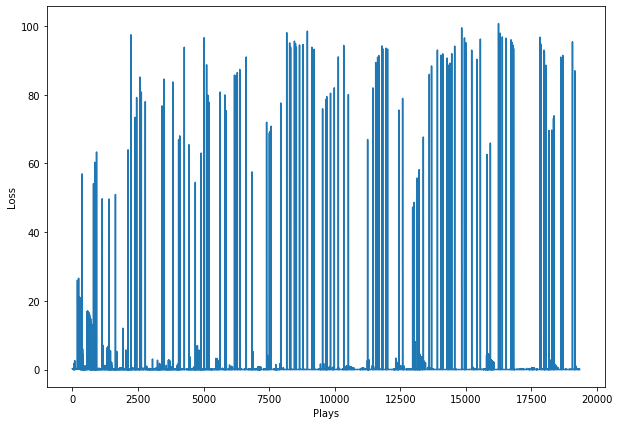

In [8]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Plays")
plt.ylabel("Loss")

In [10]:
len(action_map)

4

In [1]:


from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')



In [2]:
game.display()


array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
game.reward()

-1

In [5]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [ ]:
4